# Quantitative Text Analysis

After importing packages and text data, and defining pre-processing, this code does the following:

1. Analyze all answers from all datasheets together
2. Analyze answers from each individual datasheet
3. Analyze answers on a question-by-question basis

For each of these categories, we explore:
- Term frequency (which words occur most often)
- Collocations (which pairs and triplets of words co-occur most often)
- Lexical diversity (ratio of unique words to total words)

We also conduct topic modeling and calculate TF-IDF cosine similarity to compare across individual datasheets (section 2) and across questions (section 3).



## Load packages and define text processing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
##import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

!pip install gensim
import gensim
from gensim import corpora, models
from gensim.matutils import cossim
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

!pip install pyLDAvis

In [3]:
import warnings
warnings.filterwarnings('ignore')

##load nltk datasets
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /opt/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /opt/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /opt/conda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
##load csv of text data
datasheetsContent = pd.read_excel("datasheetscontent.xlsx")
####print(datasheetsContent)

In [5]:
##text preprocessing

##load resources
lemmatizer = WordNetLemmatizer()
na_words = ["nan", "NA", "N/A", "NAN", "http", "HTTP", ".com", "c"]
na_words = set(na_words)
stop_words = set(stopwords.words('english'))

##define processing function
def process(text):
    ##make text lowercase
    text = text.lower()
    ##tokenize text
    tokens = word_tokenize(text)
    ##keep alphabetic tokens only
    tokens = [word for word in tokens if word.isalpha()]
    ##remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    ##remove na words
    tokens = [word for word in tokens if word not in na_words]
    ##filter out urls
    tokens = [token for token in tokens if not token.startswith('http://') and not token.startswith('https://')]
    ##lemmatize text
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens


# 1. Analyze all answers from all datasheets 

In [6]:
##concatenate all answers from all datasheets into a single string
allAnswersString = " ".join(datasheetsContent['answer'].astype(str))
####print(allAnswersString)

In [7]:
##process text data

lemmatizedWords = process(allAnswersString)
####print(lemmatizedWords)

####allAnswersString = " ".join(lemmatizedWords)
####print(allAnswersString)

### *Word Frequency*

[('dataset', 781), ('data', 596), ('image', 286), ('used', 151), ('yes', 149), ('instance', 142), ('available', 137), ('annotation', 136), ('model', 116), ('people', 114), ('information', 112), ('task', 107), ('paper', 104), ('video', 103), ('research', 101), ('http', 99), ('also', 98), ('using', 97), ('use', 97), ('individual', 94)]


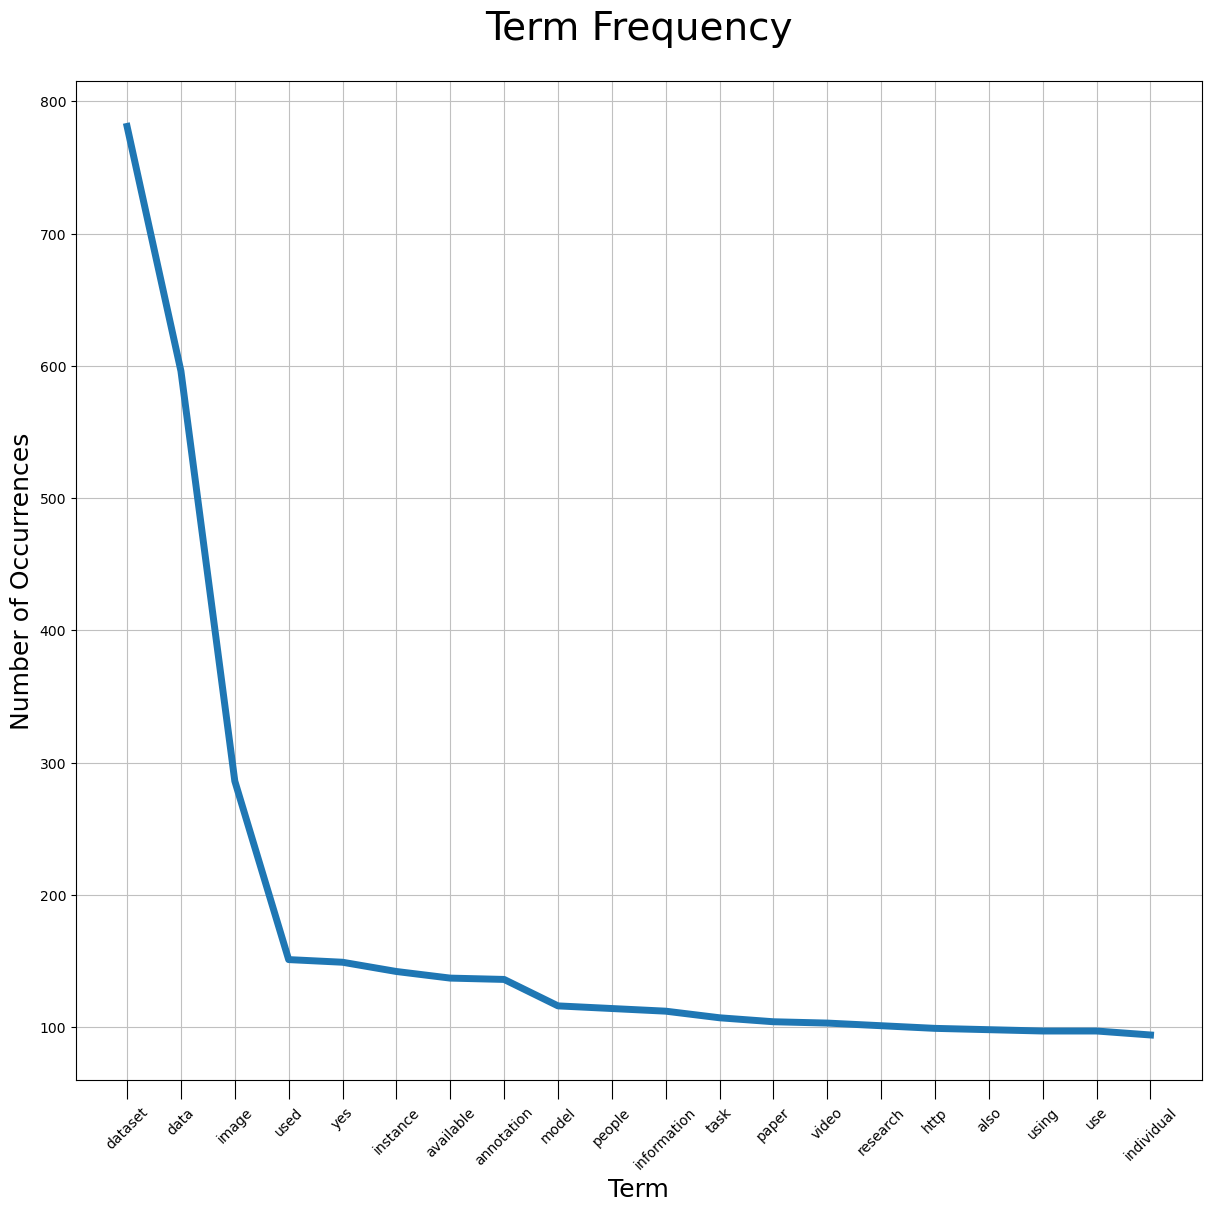

In [8]:
##analyze word frequency

frequencyDistribution = FreqDist(lemmatizedWords)
##print 10 most common words
print(frequencyDistribution.most_common(20))
##visualize word frequencies
fig, ax = plt.subplots(figsize=(12,12), layout="constrained")
plt.title("Term Frequency", fontsize=28, pad = 30)
frequencyDistribution.plot(20, cumulative=False)  
plt.xlabel("Term", fontsize = 18)
plt.ylabel("Number of Occurrences", fontsize = 18)
for line in ax.get_lines():
    line.set_linewidth(5)
ax.tick_params(axis='x', labelrotation=45,  size = 14)
plt.show()



### *Collocations*

In [9]:
##find collocations

##bigrams (pairs of words that occur together often)
bigram_finder = BigramCollocationFinder.from_words(lemmatizedWords)
###only show those that occur more than thrice
bigram_finder.apply_freq_filter(3)
###rank by PMI (Pointwise Mutual Information)
bigram_collocations = bigram_finder.nbest(BigramAssocMeasures.pmi, 40)

print("Top bigram collocations with frequency:")
for bigram in bigram_collocations:
    freq = bigram_finder.ngram_fd[bigram]
    print(f"{bigram}: {freq}")
    
##trigrams (triplets of words that occur together often)
trigram_finder = TrigramCollocationFinder.from_words(lemmatizedWords)
###only show those that occur more than thrice
trigram_finder.apply_freq_filter(3)
###rank by PMI
trigram_collocations = trigram_finder.nbest(TrigramAssocMeasures.pmi, 40)

print("\nTop trigram collocations with frequency:")
for trigram in trigram_collocations:
    freq = trigram_finder.ngram_fd[trigram]
    print(f"{trigram}: {freq}")


Top bigram collocations with frequency:
('chronicling', 'america'): 3
('hong', 'kong'): 3
('ego', 'exo'): 4
('kth', 'royal'): 4
('raesetje', 'sefala'): 4
('california', 'irvine'): 3
('energy', 'consumption'): 3
('mental', 'workload'): 4
('mobile', 'phone'): 5
('nanjing', 'changzhou'): 5
('uv', 'texture'): 4
('bad', 'actor'): 3
('experimentally', 'determined'): 3
('exo', 'top'): 4
('trillion', 'token'): 3
('cause', 'anxiety'): 4
('acm', 'multimedia'): 3
('ethic', 'committee'): 3
('changzhou', 'wuhan'): 5
('insulting', 'threatening'): 6
('personally', 'identifiable'): 4
('beike', 'company'): 3
('chat', 'gpt'): 6
('layer', 'super'): 3
('position', 'title'): 3
('respiratory', 'symptom'): 3
('texture', 'map'): 4
('ata', 'omp'): 9
('control', 'regulatory'): 3
('export', 'control'): 3
('library', 'congress'): 3
('offensive', 'insulting'): 6
('ground', 'truth'): 7
('karolinska', 'institutet'): 4
('unreal', 'engine'): 3
('highly', 'imbalanced'): 3
('pointing', 'gesture'): 3
('huggingface', 'hub

### *Lexical Diversity*

In [10]:
##calculate lexical diversity of all answers across papers/questions
totalWords = len(lemmatizedWords)
uniqueWords = len(set(lemmatizedWords))
lexicalDiversity = uniqueWords / totalWords
print(f"Lexical diversity: {lexicalDiversity}")


Lexical diversity: 0.15954875100725222


### *Keyword search*

In [11]:
##keyword searching
import re

keywordList = ["reflex", "positionality", "identity", "power", "marginalization", "historical", "social", "cultural", "objectivity", "neutral", "accountability", "responsibility"]

for word in keywordList: 
    if word.lower() in allAnswersString.lower():
        print(f"{word} Found")
        count = len(re.findall(rf"{word}", allAnswersString, re.I))
        print(count)
    else:
        print(f"{word} Not Found")
        count = len(re.findall(rf"{word}", allAnswersString, re.I))
        print(count)


reflex Not Found
0
positionality Not Found
0
identity Found
5
power Found
3
marginalization Not Found
0
historical Found
5
social Found
34
cultural Found
1
objectivity Not Found
0
neutral Found
1
accountability Found
1
responsibility Found
3


# 2. Analyze answers from each individual datasheet

In [12]:
##group data by individual papers
paperAnswersString = (
    datasheetsContent.groupby("paperacronym")["answer"]
      .apply(lambda x: " ".join(x.astype(str)))
      .reset_index()
)

###print(paperAnswersString)

In [13]:
##process text data

paperAnswersString["processedTokens"] = paperAnswersString["answer"].apply(process)
####print(paperAnswersString)

groupedTokens = paperAnswersString.groupby('paperacronym')['processedTokens'].sum().reset_index()
###print(groupedTokens)


### *Word Frequency*

[('video', 13), ('yes', 11), ('dataset', 10), ('human', 8), ('paper', 8), ('image', 7), ('uncertainty', 6), ('judgment', 5), ('annotation', 5), ('youtube', 5), ('event', 4), ('instance', 4), ('included', 4), ('limitation', 4), ('section', 4), ('data', 4), ('via', 4), ('detailed', 4), ('used', 4), ('omitted', 3)]


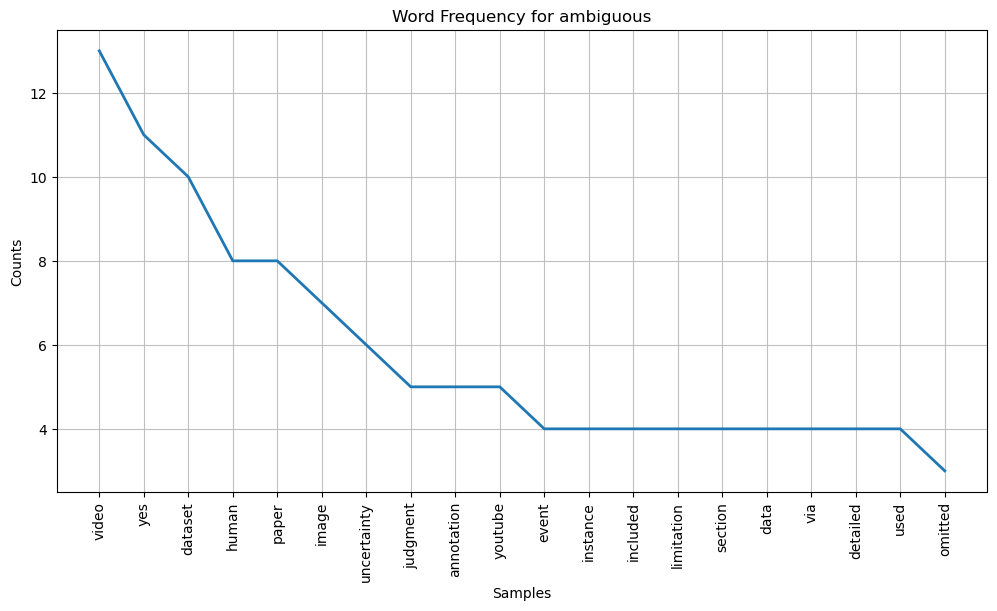

[('dataset', 22), ('data', 18), ('text', 12), ('newspaper', 10), ('content', 10), ('article', 9), ('region', 9), ('scan', 9), ('public', 9), ('domain', 8), ('page', 7), ('harvard', 6), ('university', 6), ('instance', 6), ('individual', 6), ('version', 5), ('contains', 5), ('available', 5), ('huggingface', 5), ('created', 4)]


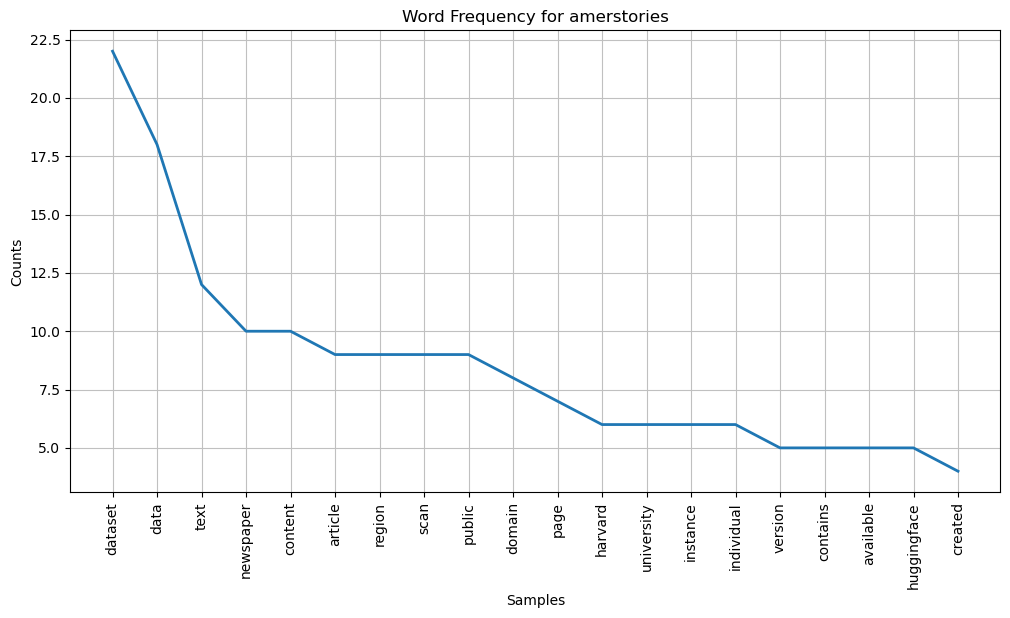

[('dialogue', 19), ('bitod', 10), ('data', 7), ('dataset', 6), ('yes', 6), ('english', 5), ('chinese', 5), ('team', 5), ('annotation', 5), ('http', 5), ('system', 4), ('training', 4), ('user', 4), ('annotator', 4), ('figure', 4), ('github', 4), ('benchmark', 3), ('task', 3), ('hkust', 3), ('conversation', 3)]


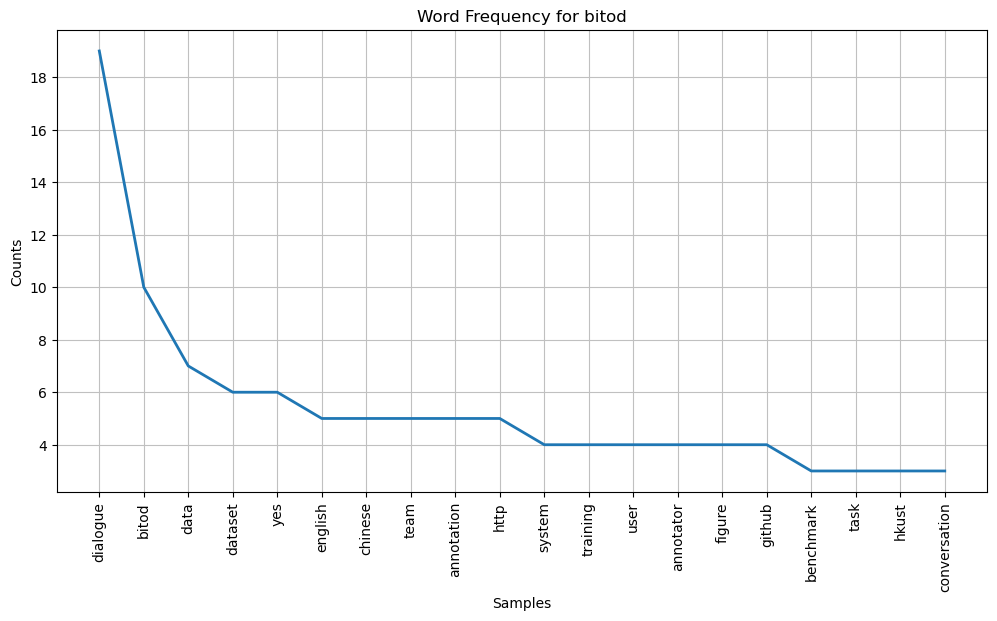

[('dataset', 29), ('simulation', 23), ('data', 9), ('human', 9), ('boiling', 8), ('study', 7), ('used', 6), ('available', 6), ('university', 4), ('physical', 4), ('paper', 4), ('file', 4), ('raw', 4), ('unblocked', 4), ('github', 4), ('created', 3), ('phenomenon', 3), ('california', 3), ('irvine', 3), ('instance', 3)]


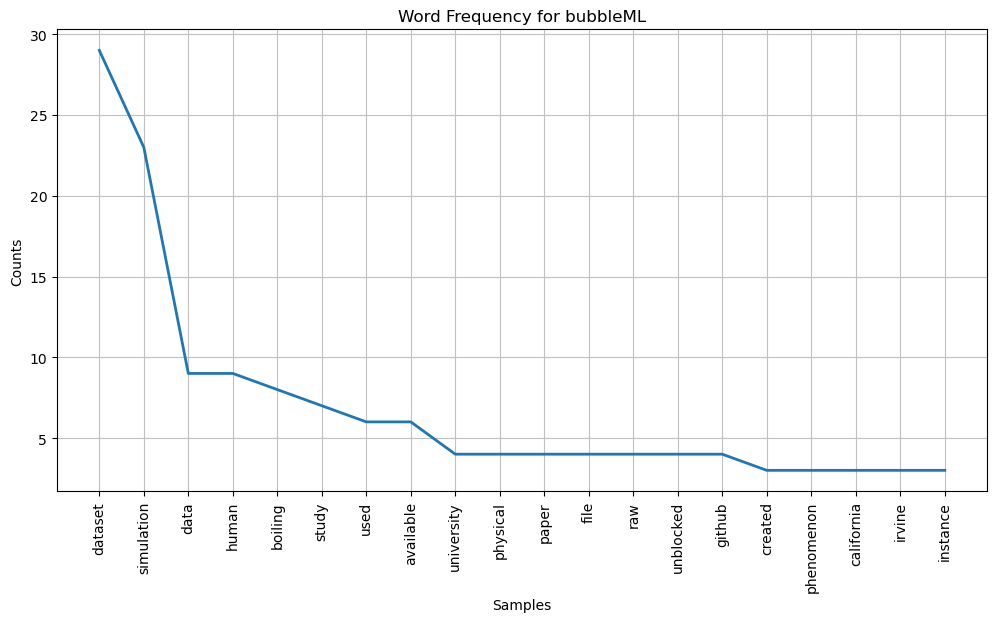

[('datasets', 22), ('data', 22), ('dataset', 22), ('simulator', 16), ('embodied', 13), ('generated', 13), ('expression', 12), ('object', 12), ('verbal', 11), ('sample', 10), ('instance', 10), ('nonverbal', 9), ('image', 9), ('referring', 8), ('three', 8), ('caesar', 7), ('interaction', 7), ('model', 7), ('yes', 7), ('gesture', 6)]


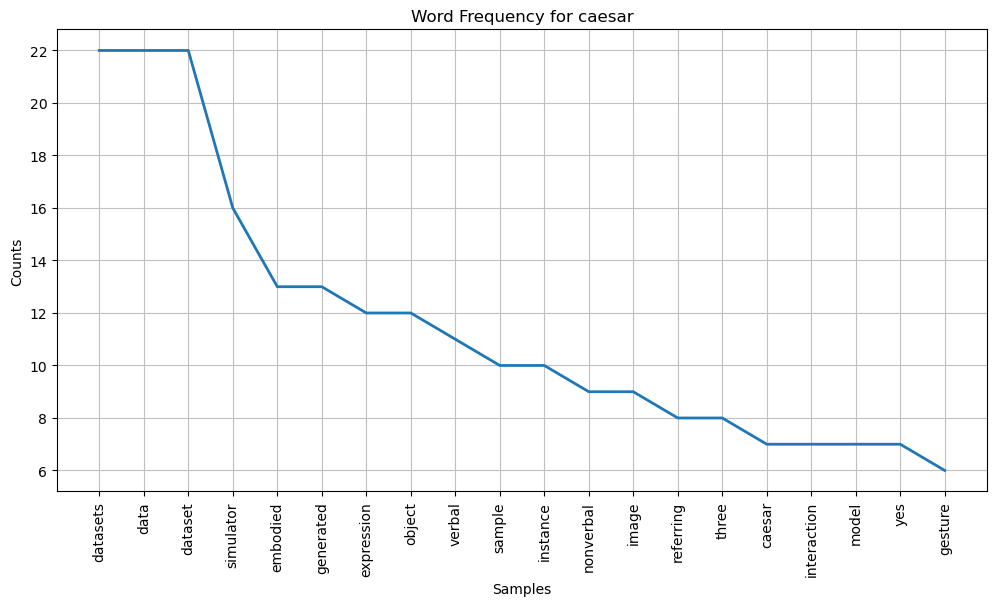

[('annotation', 18), ('dataset', 15), ('information', 13), ('image', 13), ('data', 12), ('datasets', 12), ('chemical', 11), ('research', 10), ('molecular', 10), ('human', 10), ('paper', 8), ('process', 7), ('entity', 7), ('ai', 7), ('corresponding', 7), ('cede', 6), ('lg', 6), ('work', 6), ('however', 5), ('researcher', 5)]


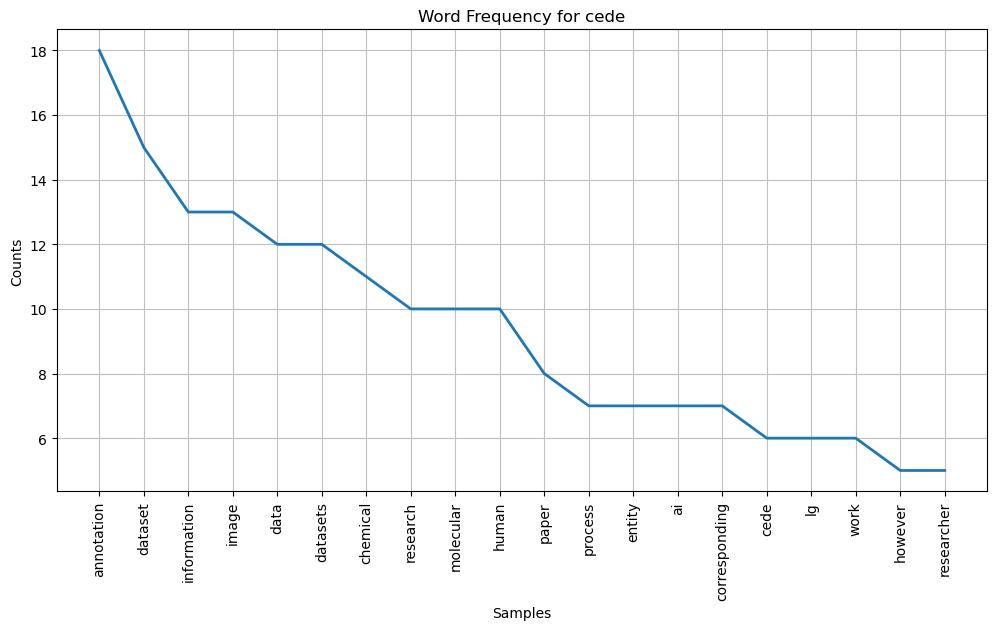

[('change', 52), ('dataset', 41), ('event', 40), ('information', 17), ('image', 13), ('benchmark', 11), ('using', 11), ('label', 10), ('individual', 10), ('satellite', 9), ('road', 9), ('construction', 9), ('contain', 9), ('fire', 8), ('instance', 8), ('imagery', 7), ('forest', 7), ('used', 7), ('available', 7), ('contains', 6)]


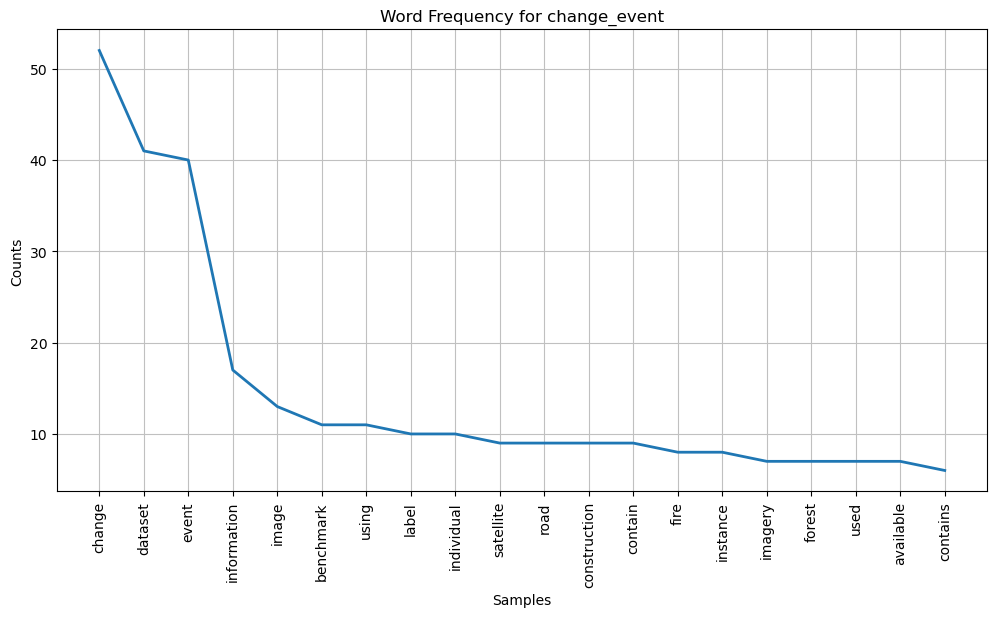

[('data', 72), ('dataset', 37), ('annotation', 26), ('social', 24), ('conference', 23), ('task', 21), ('camera', 21), ('subject', 19), ('video', 19), ('individual', 18), ('conflab', 16), ('wearable', 16), ('collection', 15), ('interaction', 15), ('speaking', 14), ('status', 14), ('recording', 13), ('community', 13), ('person', 13), ('pose', 12)]


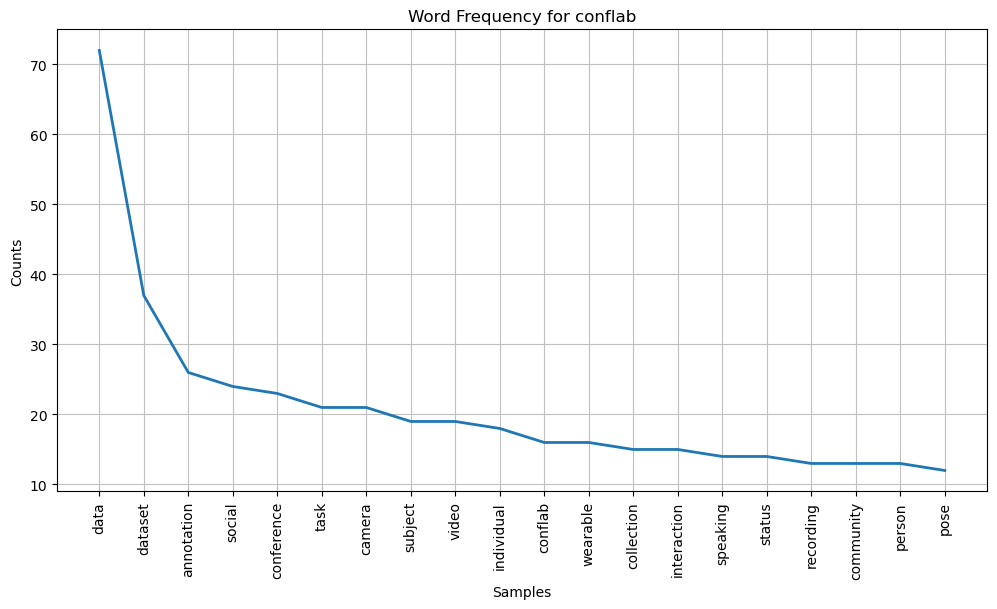

[('data', 35), ('dataset', 19), ('yes', 14), ('user', 13), ('app', 13), ('sound', 11), ('http', 10), ('detection', 8), ('audio', 7), ('sample', 7), ('refer', 7), ('researcher', 6), ('research', 6), ('respiratory', 5), ('participant', 5), ('access', 5), ('directly', 5), ('request', 5), ('please', 5), ('health', 4)]


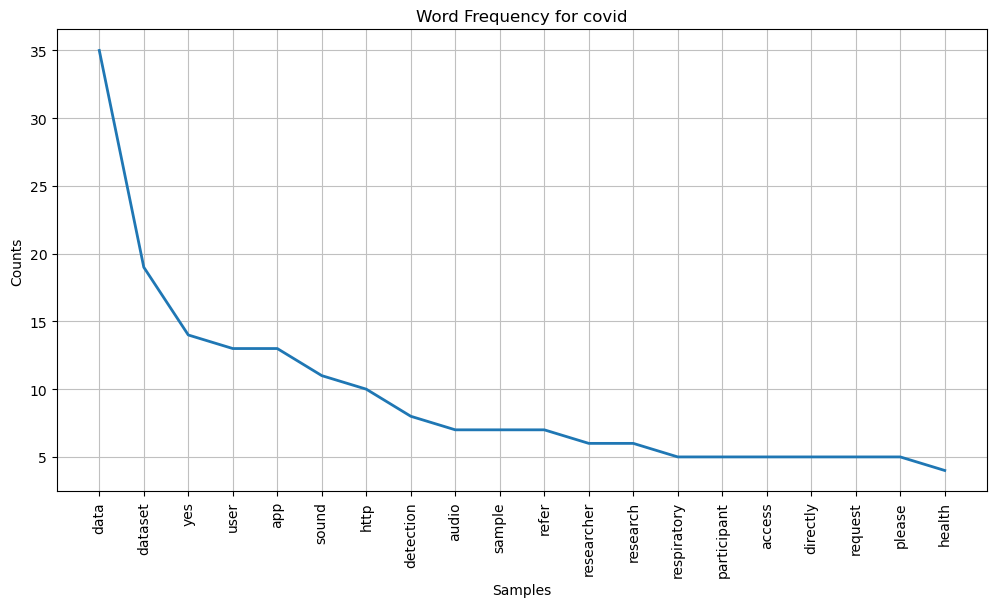

[('data', 57), ('officer', 30), ('request', 24), ('raw', 21), ('chicago', 17), ('foia', 16), ('police', 14), ('record', 13), ('response', 10), ('complaint', 10), ('date', 10), ('repository', 10), ('yes', 10), ('city', 8), ('department', 8), ('award', 8), ('file', 7), ('institute', 7), ('available', 7), ('unit', 7)]


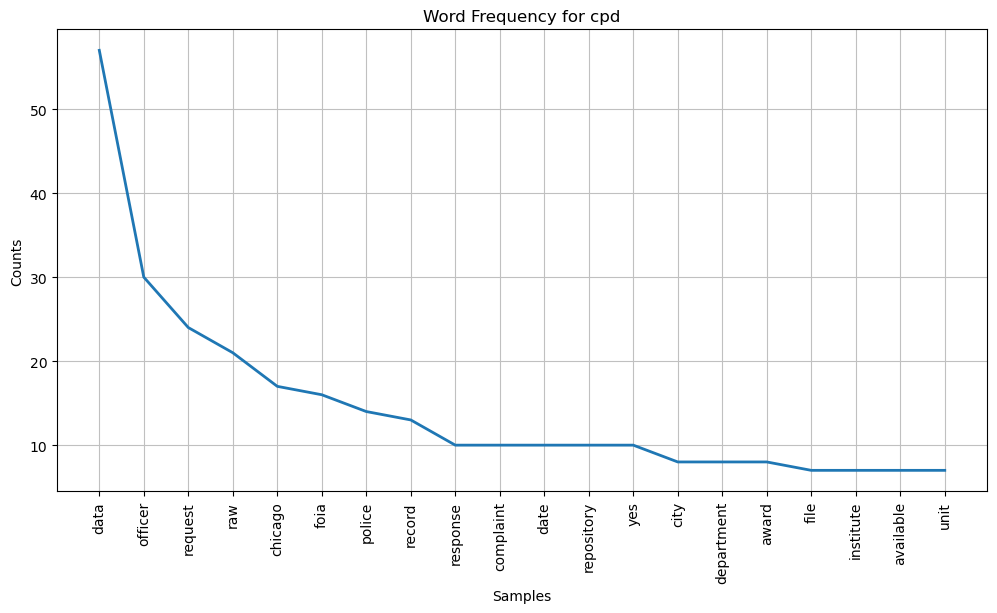

[('claim', 27), ('dataset', 19), ('entity', 13), ('data', 10), ('set', 8), ('false', 7), ('also', 7), ('commonsense', 6), ('development', 6), ('one', 6), ('example', 6), ('reasoning', 5), ('worker', 5), ('model', 4), ('true', 4), ('test', 4), ('people', 4), ('could', 4), ('incorrect', 4), ('however', 4)]


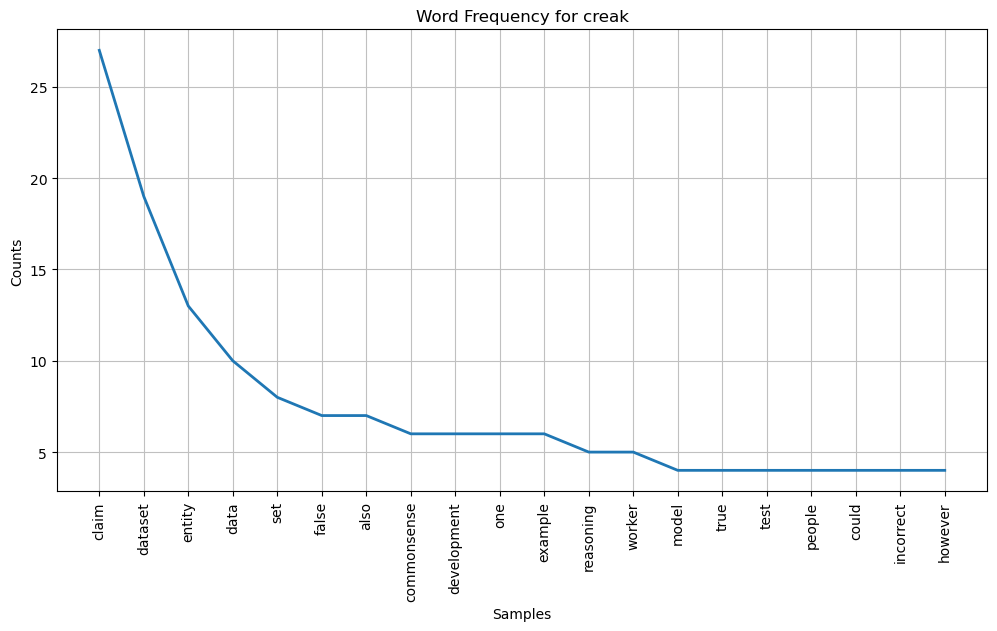

[('dataset', 35), ('image', 31), ('mammogram', 22), ('data', 22), ('screening', 18), ('annotation', 18), ('participant', 17), ('cancer', 16), ('expert', 15), ('masking', 14), ('clinical', 14), ('model', 12), ('contains', 10), ('karolinska', 10), ('mammography', 9), ('mammographic', 8), ('breast', 8), ('hospital', 8), ('collected', 8), ('used', 8)]


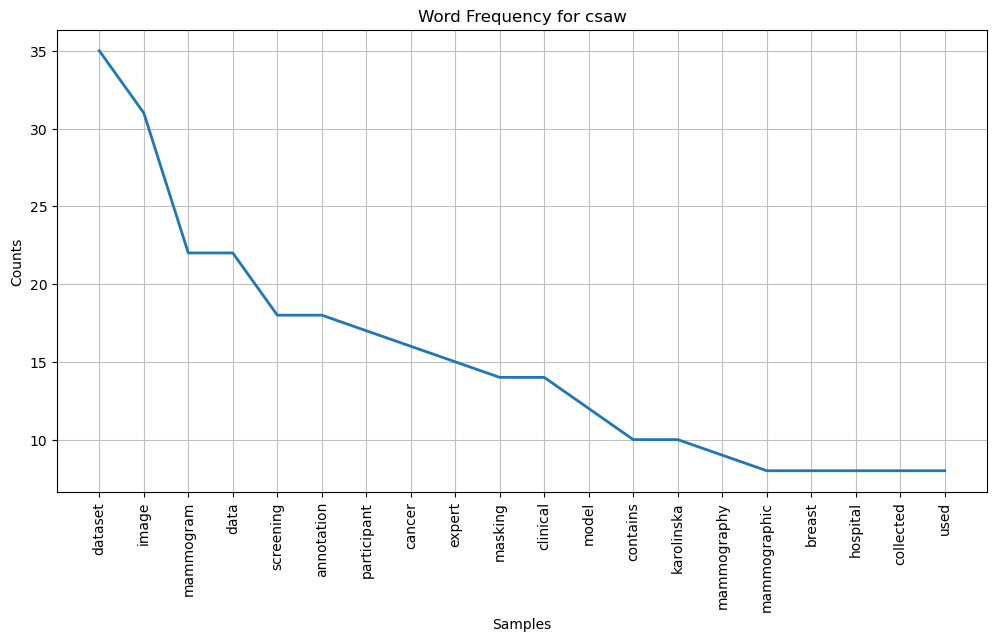

[('ommon', 41), ('p', 41), ('ool', 41), ('dataset', 30), ('image', 28), ('data', 26), ('sample', 23), ('face', 19), ('see', 16), ('download', 16), ('internet', 15), ('http', 15), ('nsfw', 14), ('model', 13), ('common', 10), ('ata', 9), ('omp', 9), ('appendix', 9), ('crawl', 9), ('people', 9)]


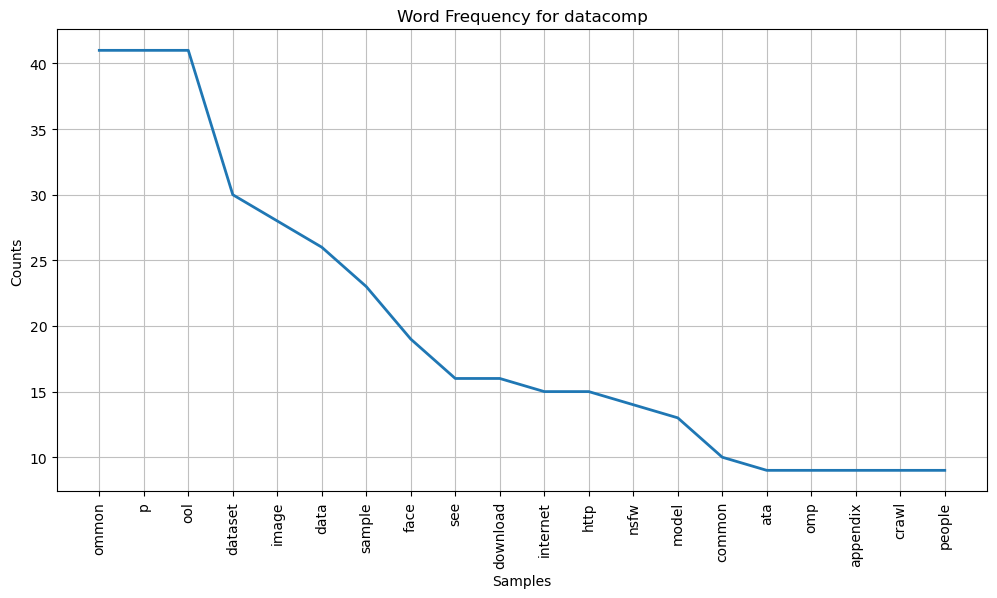

[('dataset', 37), ('flair', 19), ('aerial', 18), ('ign', 17), ('image', 15), ('data', 13), ('cover', 10), ('french', 8), ('domain', 8), ('land', 7), ('imagery', 7), ('resolution', 6), ('et', 6), ('area', 6), ('class', 6), ('yes', 6), ('annotation', 5), ('geographical', 5), ('public', 5), ('provides', 5)]


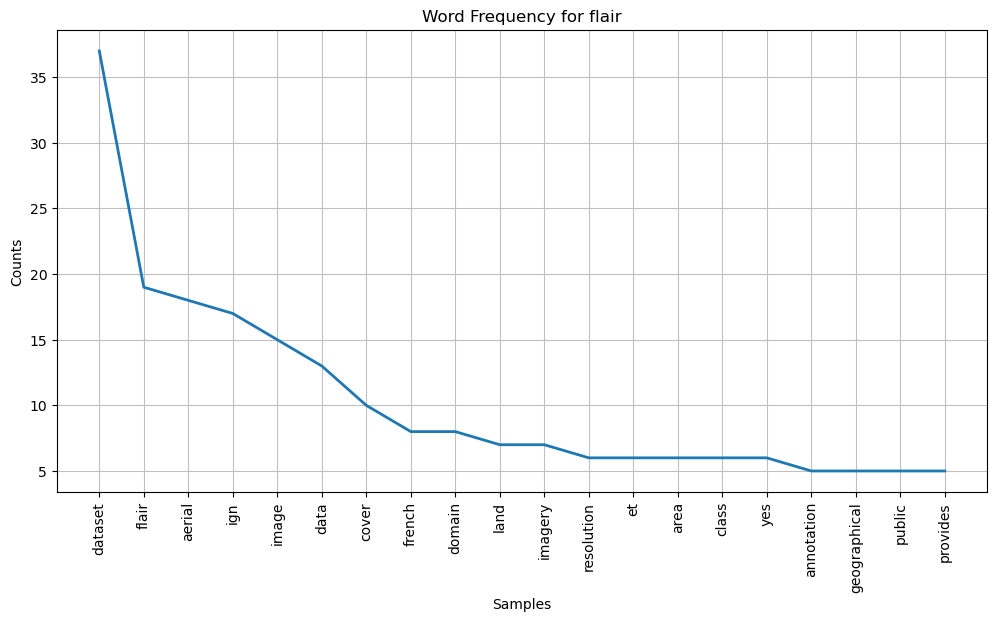

[('speech', 8), ('set', 6), ('yes', 6), ('company', 5), ('subdialect', 4), ('task', 3), ('beike', 3), ('preprocessing', 3), ('chinese', 2), ('mandarin', 2), ('recognition', 2), ('speaker', 2), ('learning', 2), ('transcription', 2), ('presets', 2), ('several', 2), ('preparing', 2), ('training', 2), ('development', 2), ('test', 2)]


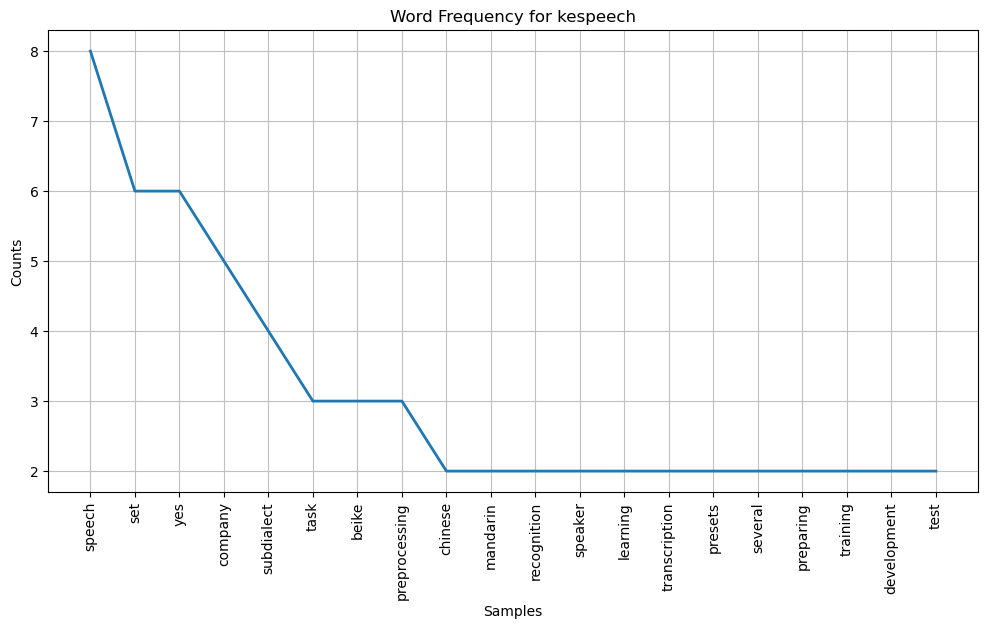

[('image', 27), ('dataset', 26), ('data', 14), ('loveda', 13), ('area', 12), ('set', 11), ('semantic', 9), ('people', 9), ('domain', 7), ('wuhan', 7), ('city', 7), ('segmentation', 6), ('adaptation', 6), ('representative', 6), ('training', 6), ('used', 6), ('unsupervised', 5), ('nanjing', 5), ('changzhou', 5), ('cover', 5)]


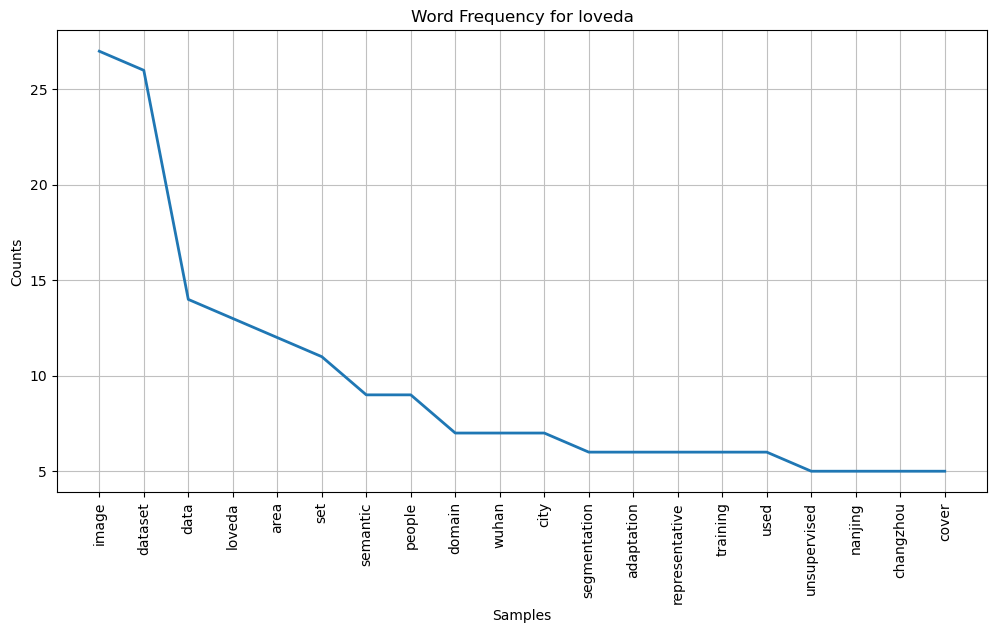

[('document', 20), ('language', 18), ('dataset', 15), ('data', 11), ('commoncrawl', 11), ('sentence', 9), ('content', 7), ('general', 6), ('may', 6), ('google', 5), ('annotated', 5), ('using', 5), ('given', 5), ('level', 4), ('model', 4), ('low', 4), ('version', 4), ('used', 4), ('containing', 4), ('quality', 4)]


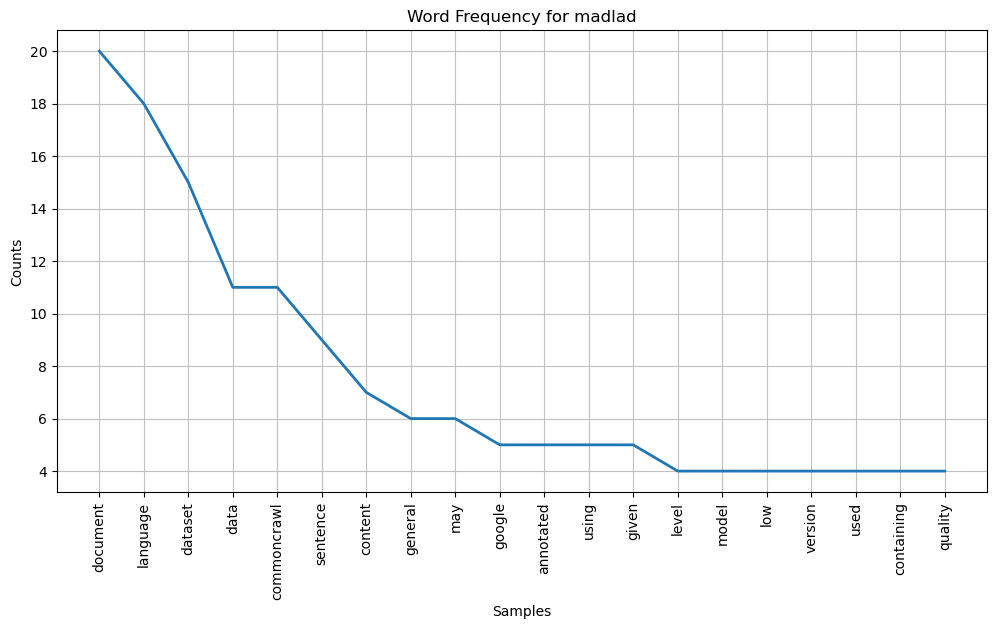

[('dataset', 30), ('see', 20), ('prompt', 20), ('ghost', 19), ('appendix', 14), ('minighosts', 11), ('question', 10), ('output', 10), ('file', 10), ('mathematical', 9), ('used', 8), ('chat', 8), ('version', 8), ('people', 8), ('chatgpt', 7), ('evaluation', 7), ('microghosts', 7), ('made', 6), ('gpt', 6), ('json', 6)]


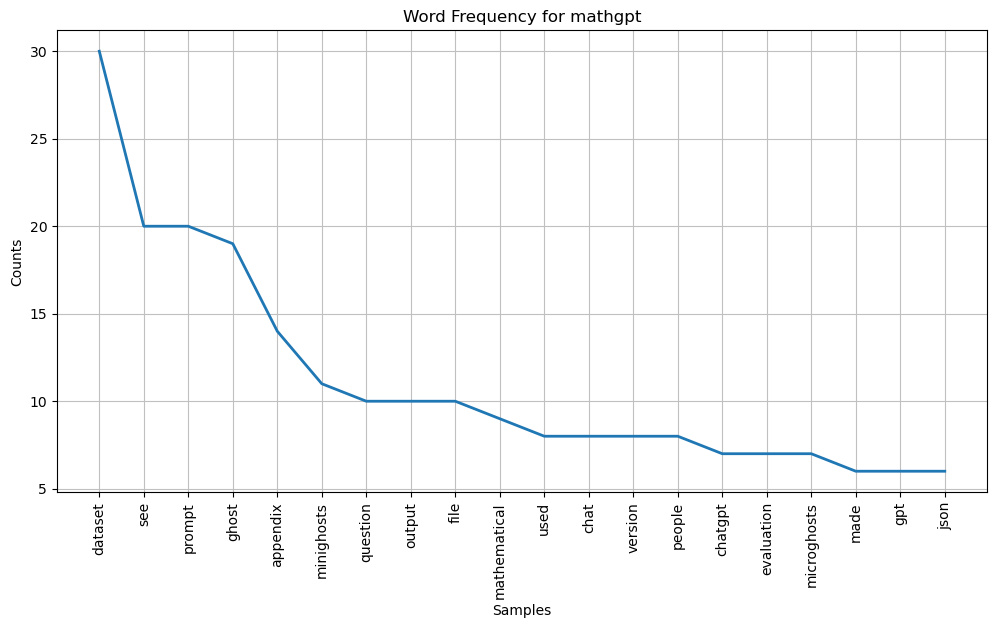

[('data', 39), ('dataset', 30), ('health', 25), ('feature', 24), ('environmental', 19), ('prescription', 19), ('lsoas', 18), ('lsoa', 17), ('available', 15), ('instance', 14), ('level', 13), ('image', 13), ('variable', 13), ('derived', 11), ('sociodemographic', 11), ('publicly', 11), ('census', 10), ('product', 10), ('year', 9), ('missing', 9)]


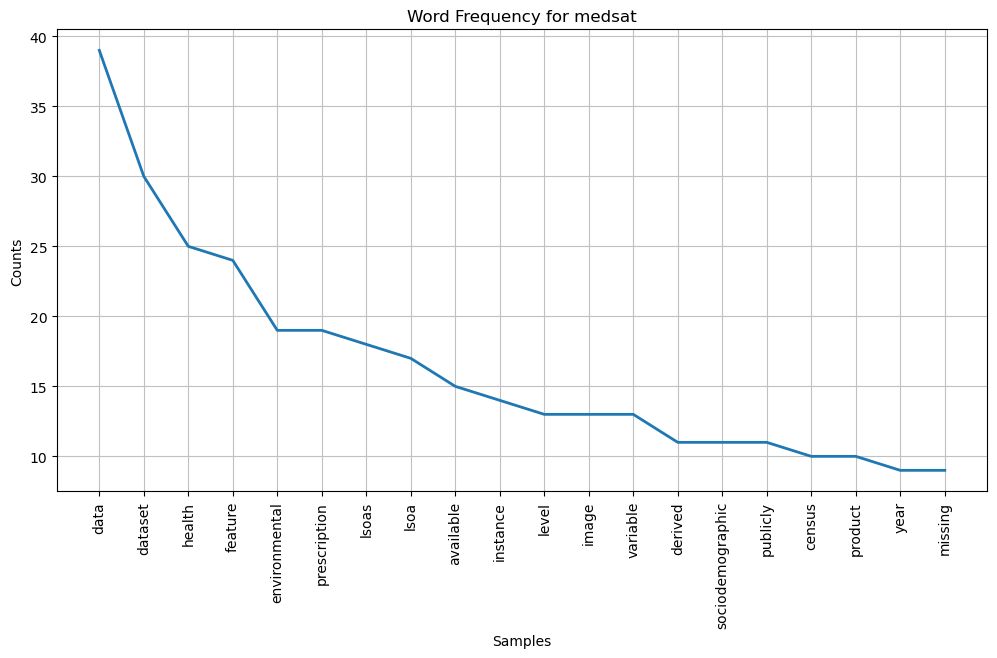

[('dataset', 27), ('data', 20), ('object', 20), ('license', 10), ('individual', 9), ('platform', 9), ('part', 8), ('task', 7), ('github', 7), ('based', 7), ('may', 7), ('content', 7), ('use', 7), ('institute', 6), ('metadata', 6), ('file', 6), ('thingiverse', 6), ('sketchfab', 6), ('ai', 5), ('paper', 5)]


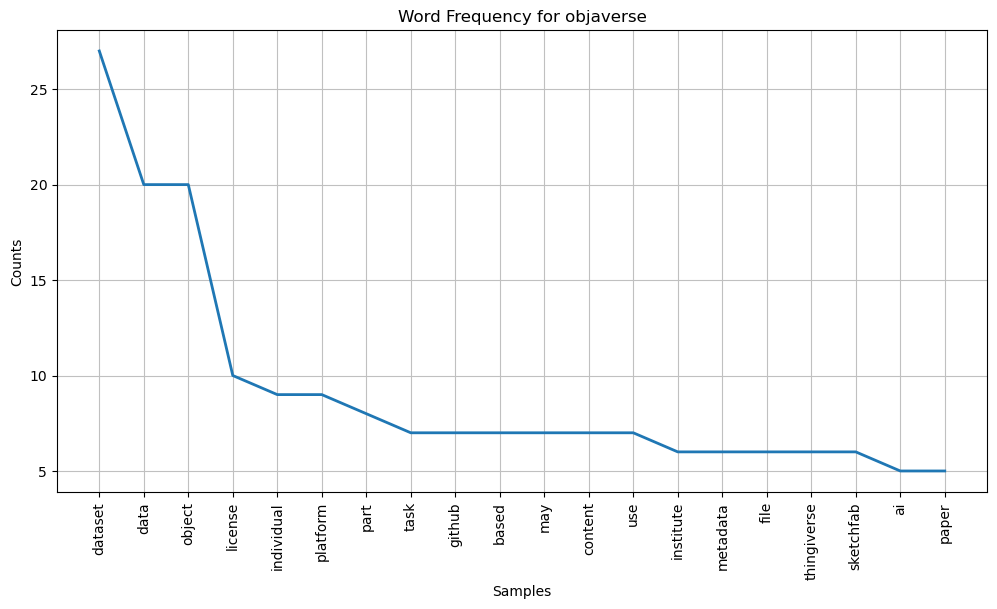

[('dataset', 22), ('protein', 21), ('openproteinset', 15), ('pdb', 15), ('data', 14), ('structure', 14), ('sequence', 13), ('msas', 13), ('database', 9), ('prediction', 8), ('relate', 8), ('people', 8), ('template', 7), ('hit', 7), ('format', 6), ('cluster', 6), ('publicly', 6), ('roda', 6), ('page', 6), ('openfold', 5)]


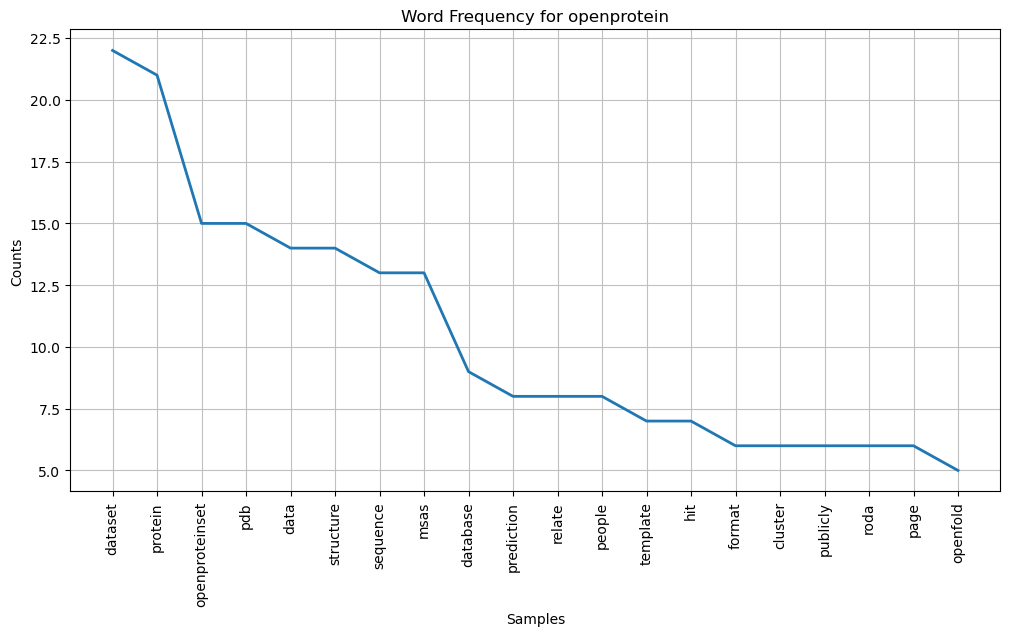

[('puzzle', 16), ('problem', 16), ('dataset', 15), ('github', 10), ('people', 9), ('relate', 7), ('paper', 5), ('python', 4), ('created', 3), ('code', 3), ('one', 3), ('instance', 3), ('template', 3), ('solution', 3), ('however', 3), ('source', 3), ('preprocessing', 3), ('evaluate', 2), ('teach', 2), ('microsoft', 2)]


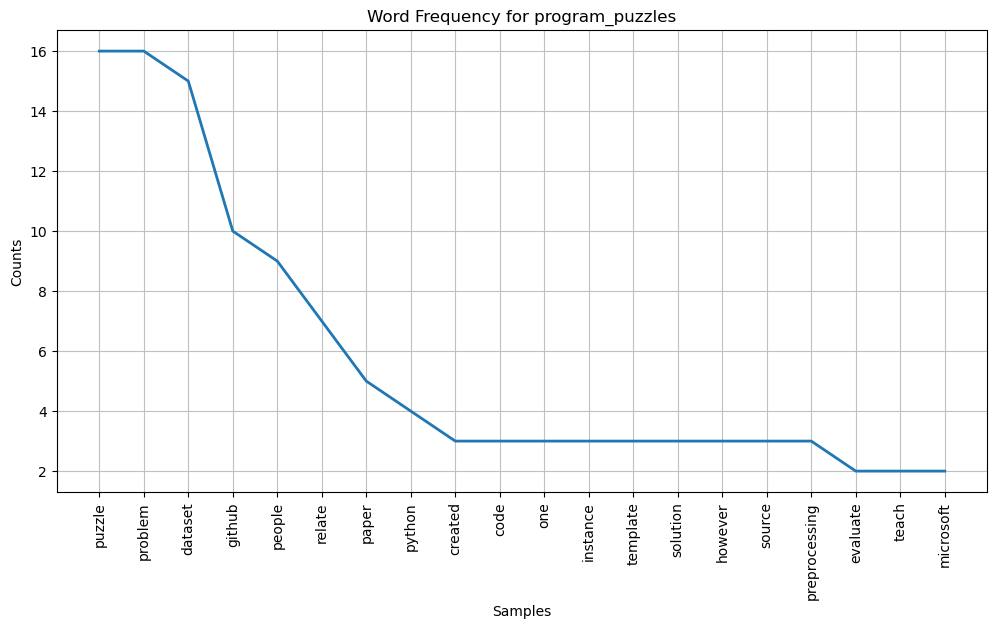

[]


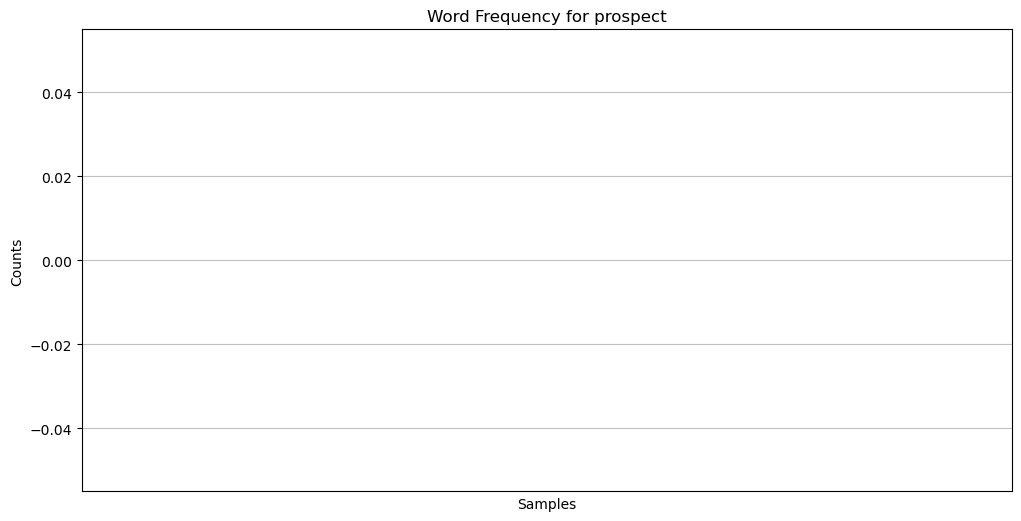

[('pug', 40), ('animal', 14), ('dataset', 14), ('image', 13), ('asset', 13), ('imagenet', 11), ('spar', 10), ('used', 9), ('factor', 8), ('see', 8), ('variation', 7), ('data', 7), ('contains', 6), ('appendix', 6), ('model', 5), ('csv', 5), ('http', 5), ('datasets', 4), ('paper', 4), ('contrast', 4)]


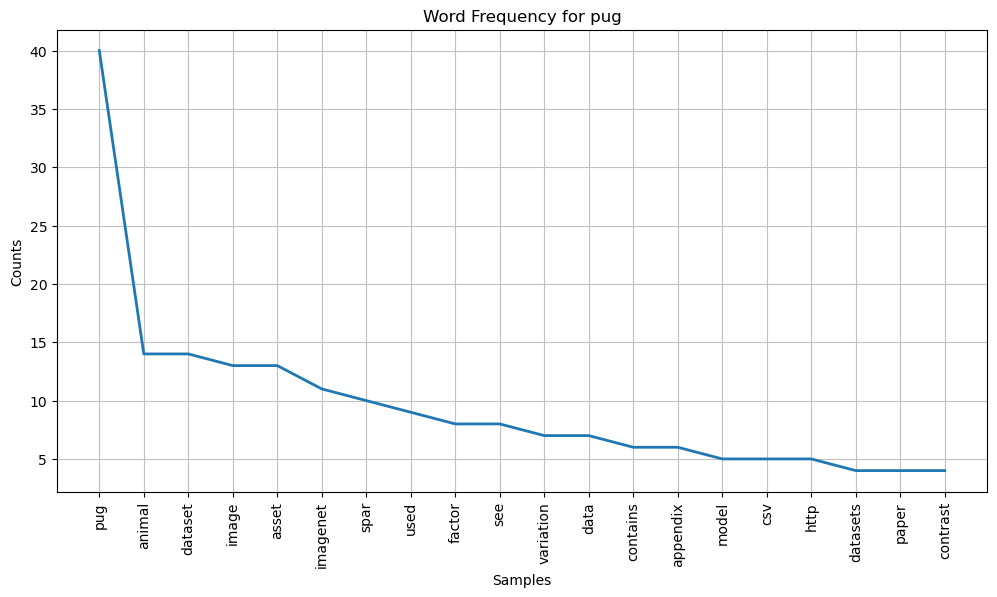

[('dataset', 15), ('refinedweb', 11), ('version', 10), ('commoncrawl', 9), ('data', 9), ('content', 7), ('deduplication', 7), ('language', 6), ('model', 6), ('using', 6), ('use', 6), ('document', 6), ('extract', 6), ('available', 6), ('yes', 6), ('may', 5), ('public', 5), ('source', 4), ('pipeline', 4), ('filtering', 4)]


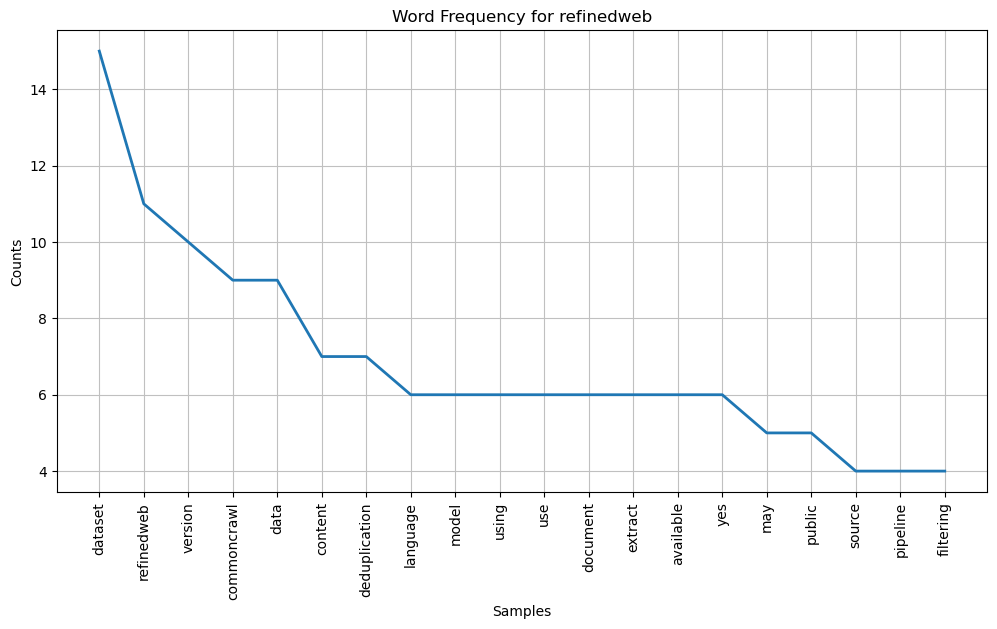

[('data', 29), ('annotation', 23), ('dataset', 19), ('head', 14), ('provide', 12), ('shanghai', 11), ('ai', 11), ('laboratory', 11), ('research', 9), ('yes', 9), ('human', 8), ('different', 8), ('file', 8), ('parameter', 8), ('one', 7), ('synthesis', 7), ('camera', 7), ('landmark', 7), ('subject', 7), ('avatar', 6)]


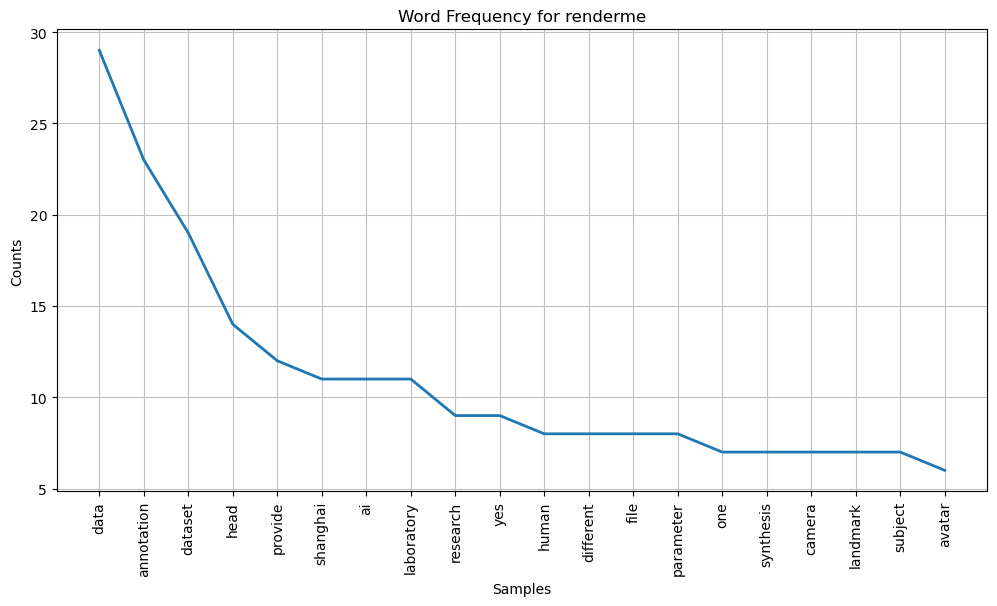

[('dataset', 35), ('data', 24), ('synthetic', 12), ('video', 10), ('physiological', 7), ('created', 7), ('applicable', 7), ('simulation', 6), ('facial', 6), ('label', 6), ('used', 6), ('parameter', 5), ('however', 5), ('contain', 5), ('model', 5), ('engine', 5), ('measurement', 4), ('microsoft', 4), ('possible', 4), ('entirely', 4)]


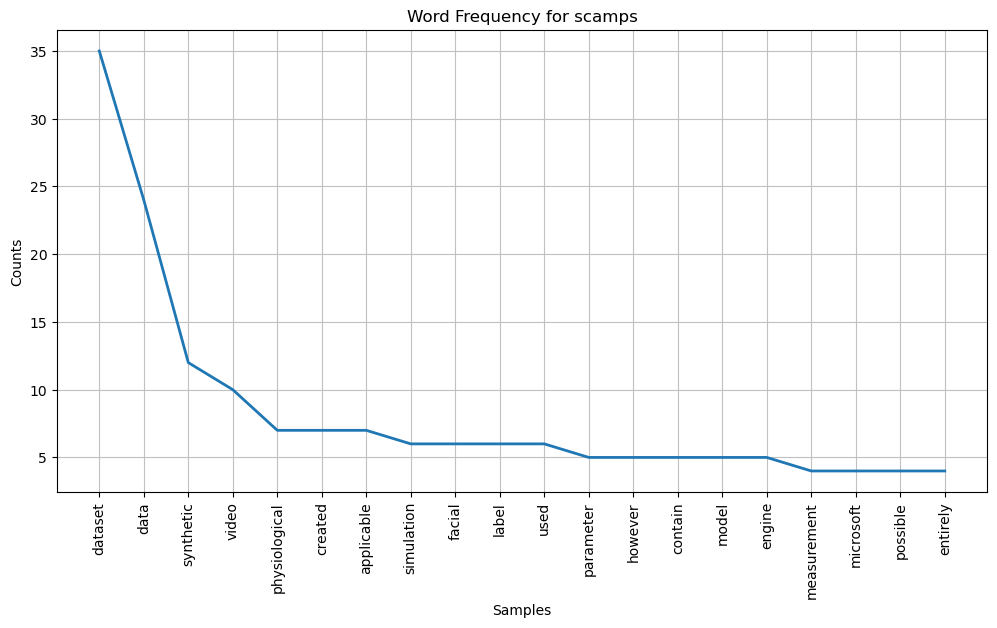

[('pair', 23), ('scigen', 22), ('article', 19), ('annotation', 18), ('table', 14), ('dataset', 13), ('contain', 12), ('data', 12), ('et', 9), ('expert', 8), ('instance', 8), ('training', 8), ('extracted', 8), ('relate', 8), ('people', 8), ('step', 8), ('generation', 7), ('text', 7), ('paper', 7), ('manual', 7)]


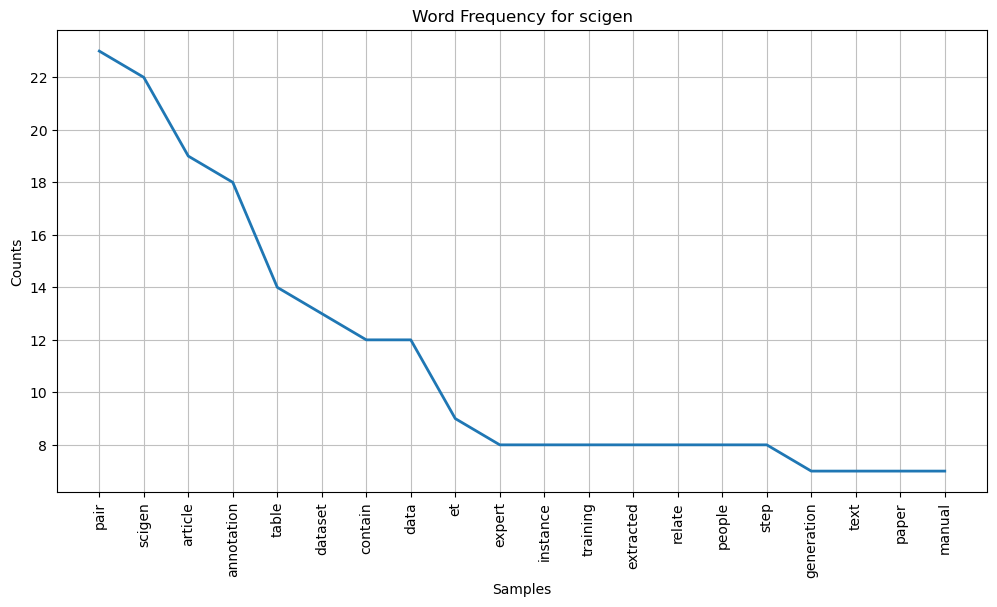

[('video', 39), ('pose', 24), ('dataset', 20), ('language', 16), ('signcorpus', 13), ('keypoints', 13), ('sign', 12), ('data', 10), ('youtube', 10), ('releasing', 9), ('also', 8), ('instance', 7), ('file', 7), ('channel', 7), ('used', 6), ('well', 6), ('value', 6), ('pretraining', 5), ('metadata', 5), ('purpose', 5)]


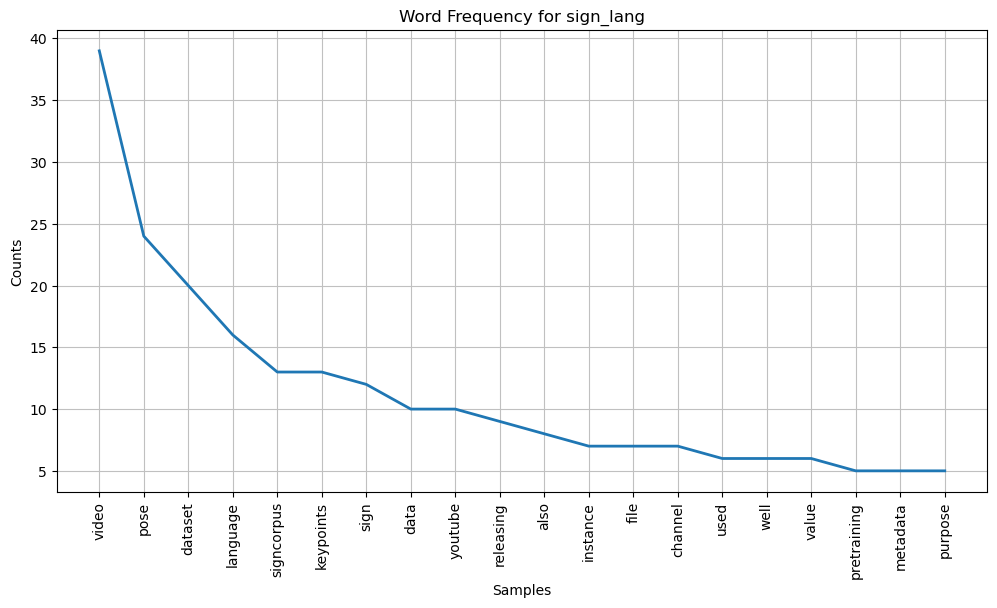

[('dataset', 92), ('building', 40), ('image', 38), ('satellite', 33), ('south', 30), ('data', 28), ('africa', 17), ('used', 17), ('neighbourhood', 16), ('type', 16), ('use', 15), ('township', 14), ('mask', 14), ('using', 13), ('african', 13), ('source', 13), ('created', 12), ('also', 12), ('available', 12), ('research', 12)]


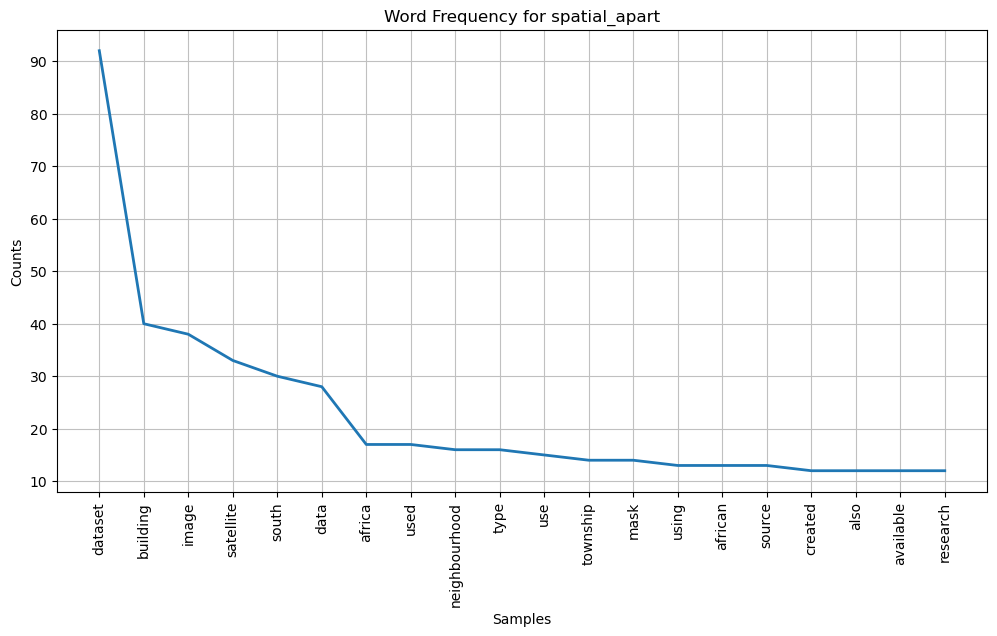

[('speech', 30), ('description', 29), ('model', 23), ('dataset', 21), ('text', 21), ('object', 17), ('transcribed', 15), ('language', 14), ('data', 13), ('spoken', 12), ('image', 12), ('instance', 12), ('using', 9), ('collected', 8), ('evaluated', 8), ('written', 7), ('set', 6), ('amazon', 6), ('mechanical', 6), ('turk', 6)]


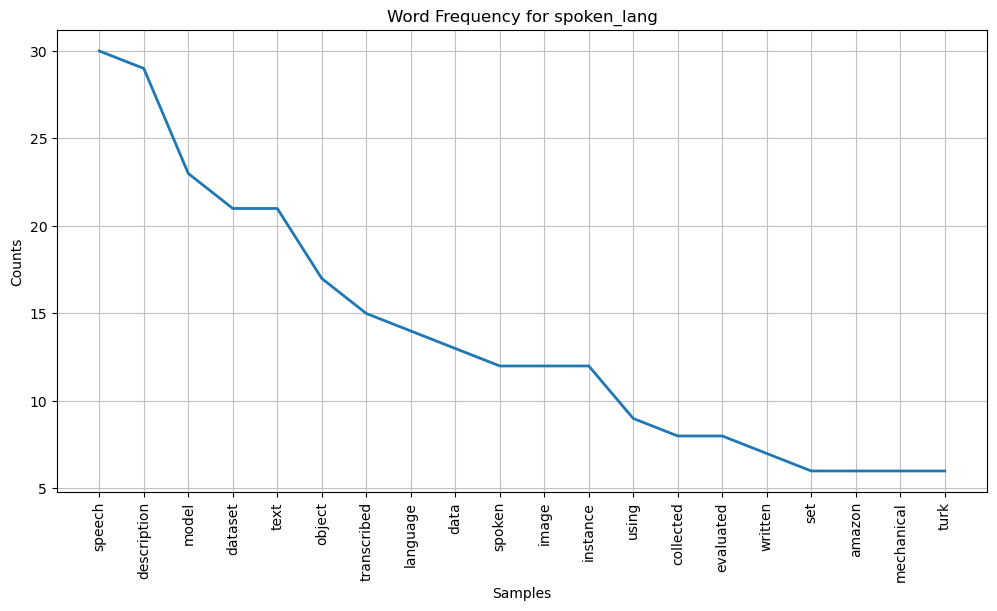

[('video', 14), ('charade', 10), ('question', 9), ('license', 9), ('star', 8), ('yes', 7), ('action', 7), ('genome', 7), ('situation', 6), ('data', 6), ('homepage', 6), ('dataset', 6), ('reasoning', 5), ('answer', 5), ('generated', 5), ('provide', 5), ('situated', 4), ('id', 4), ('instance', 4), ('mit', 4)]


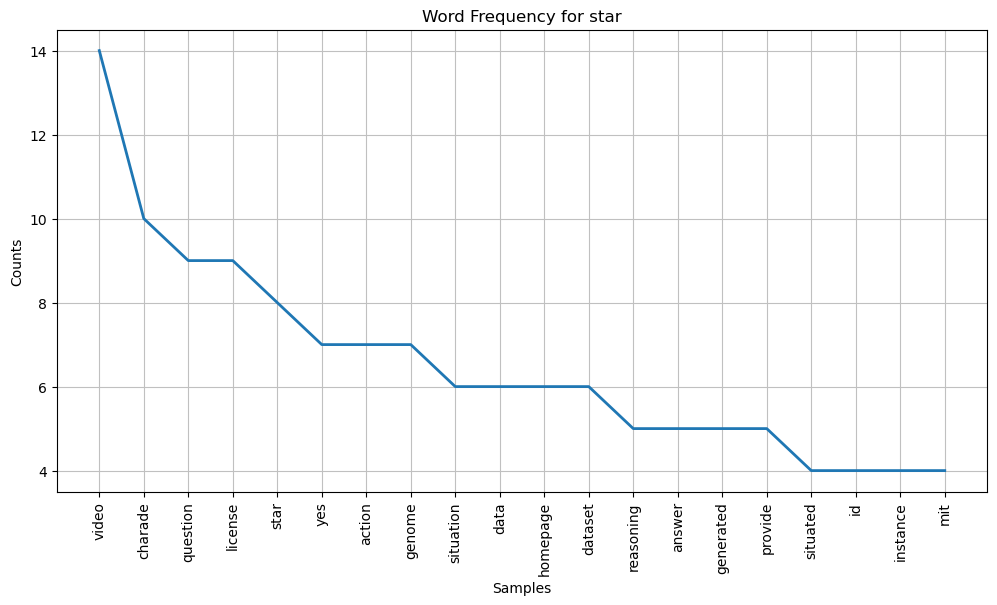

[('data', 39), ('participant', 20), ('dataset', 16), ('yes', 16), ('fnirs', 15), ('subject', 14), ('experimental', 14), ('available', 13), ('tuft', 12), ('collected', 10), ('task', 9), ('website', 9), ('user', 8), ('study', 8), ('recording', 8), ('individual', 8), ('released', 8), ('using', 7), ('session', 7), ('sensor', 7)]


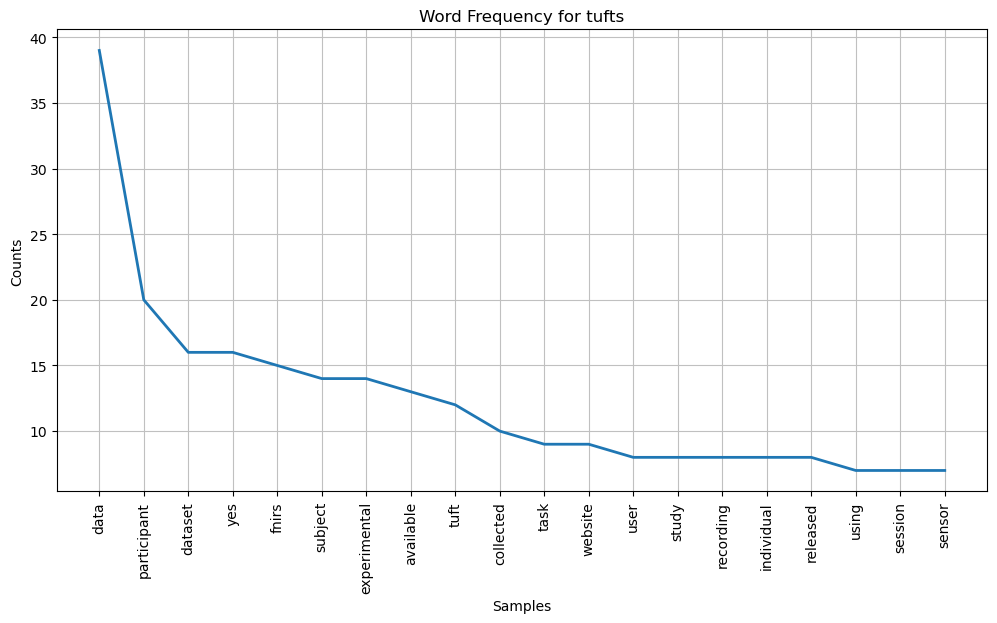

[('image', 10), ('category', 8), ('human', 7), ('label', 7), ('author', 6), ('gold', 5), ('dataset', 5), ('set', 4), ('sample', 4), ('paper', 3), ('corresponding', 3), ('open', 3), ('test', 3), ('yes', 3), ('process', 3), ('data', 3), ('visalign', 2), ('visual', 2), ('perception', 2), ('information', 2)]


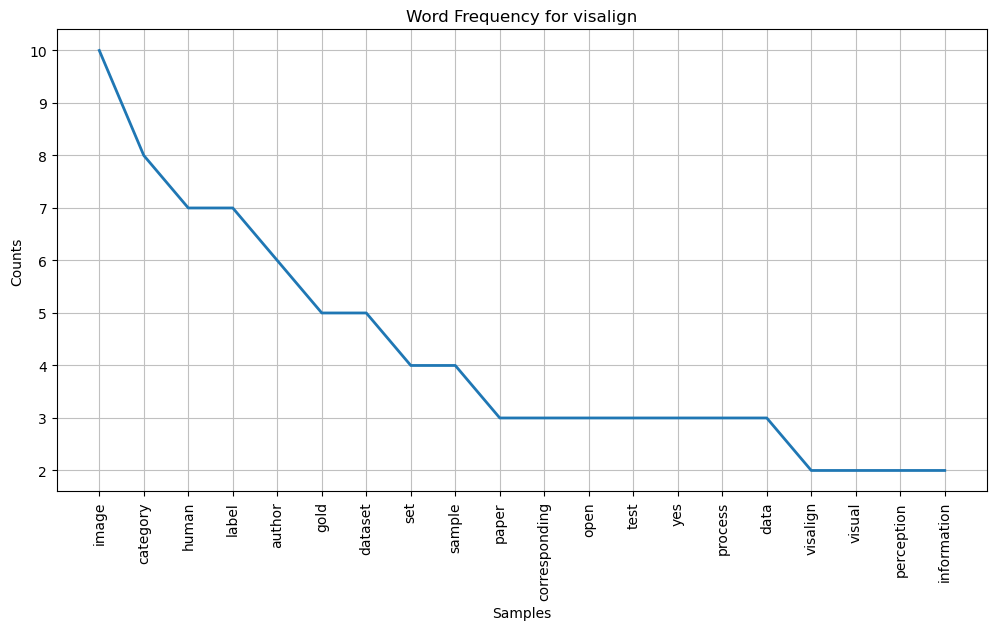

[('image', 48), ('dataset', 34), ('church', 30), ('style', 21), ('class', 12), ('label', 12), ('bounding', 11), ('box', 11), ('architectural', 10), ('provided', 10), ('common', 9), ('relate', 9), ('people', 9), ('wikichurches', 8), ('subset', 8), ('building', 7), ('one', 7), ('wikidata', 7), ('file', 7), ('split', 7)]


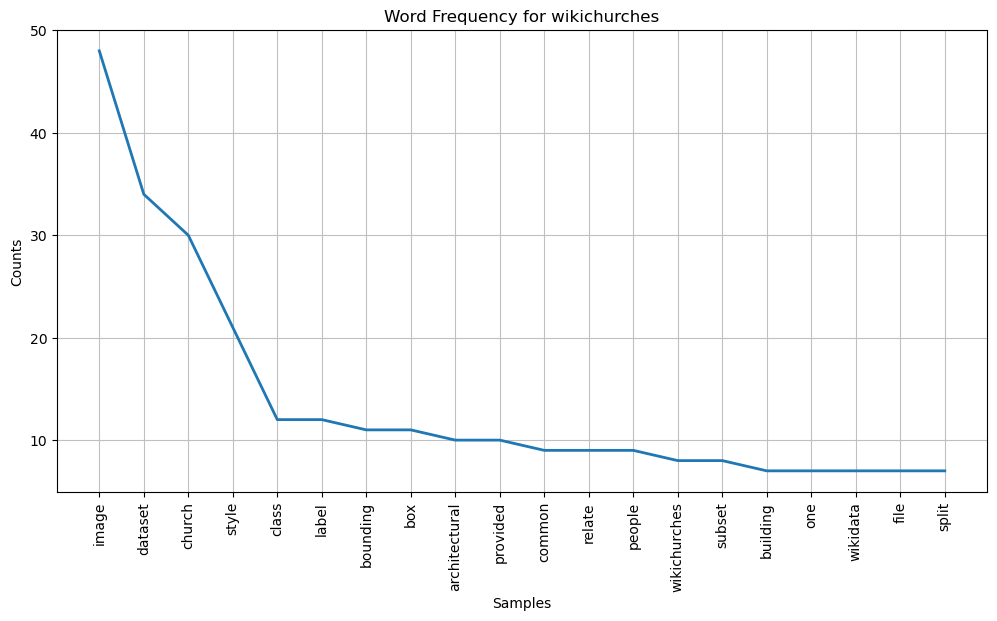

In [14]:
##analyze word frequency for each paper

##define function to plot frequency distribution of top 10 words
def plotWordFrequency(tokens, title, num_words=20):
    frequencyDistribution = FreqDist(tokens)
    print(frequencyDistribution.most_common(20))
    plt.figure(figsize=(12,6))
    frequencyDistribution.plot(num_words, cumulative=False)
    plt.title(title)
    plt.show()

##generate frequency plot for each paper
for _, row in groupedTokens.iterrows():
    paper = row['paperacronym']
    tokens = row['processedTokens']
    plotWordFrequency(tokens, f'Word Frequency for {paper}')


### *Collocations*

In [15]:
##get collocations for each paper

##define function to get bigrams
def get_bigram(tokens, top_n):
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2) ##with minimum frequency of 2
    collocations = finder.nbest(BigramAssocMeasures.pmi, top_n)
    return [(c, finder.ngram_fd[c]) for c in collocations]

##define function to get trigrams
def get_trigram(tokens, top_n):
    finder = TrigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    collocations = finder.nbest(TrigramAssocMeasures.pmi, top_n)
    return [(c, finder.ngram_fd[c]) for c in collocations]


##for loop; apply the collocations functions to each paper; show top 10 results (top_n)
for _, row in groupedTokens.iterrows():
    paper = row['paperacronym']
    tokens = row['processedTokens']
    
    print(f"\n Paper: {paper} ")
    
    bigrams = get_bigram(tokens, top_n=10)
    print("Top bigrams:")
    for collocation, freq in bigrams:
        print(f"{collocation}: {freq}")
    
    trigrams = get_trigram(tokens, top_n=10)
    print("Top trigrams:")
    for collocation, freq in trigrams:
        print(f"{collocation}: {freq}")


 Paper: ambiguous 
Top bigrams:
('amazon', 'mechanical'): 3
('ground', 'truth'): 3
('mechanical', 'turk'): 3
('publicly', 'available'): 2
('event', 'type'): 3
('limitation', 'listed'): 2
('content', 'publicly'): 2
('collection', 'limitation'): 2
('possible', 'instance'): 2
('truth', 'event'): 2
Top trigrams:
('amazon', 'mechanical', 'turk'): 3
('ground', 'truth', 'event'): 2
('truth', 'event', 'type'): 2
('via', 'amazon', 'mechanical'): 2
('collection', 'limitation', 'detailed'): 2
('limitation', 'detailed', 'section'): 2
('dataset', 'collection', 'limitation'): 2
('detailed', 'section', 'paper'): 2
('human', 'uncertainty', 'judgment'): 2
('yes', 'dataset', 'collection'): 2

 Paper: amerstories 
Top bigrams:
('melissa', 'dell'): 2
('third', 'party'): 2
('caption', 'byline'): 3
('chronicling', 'america'): 3
('cover', 'many'): 2
('drawn', 'entirely'): 2
('library', 'congress'): 3
('science', 'initiative'): 2
('conducted', 'preprocessing'): 3
('new', 'york'): 2
Top trigrams:
('cover', 'm

### *Lexical Diversity*

In [16]:
##calculate lexical diversity of answers for each paper

##define function to calculate lexical diversity
def lexicalDiversity(tokens):
    totalWords = len(tokens)
    uniqueWords = len(set(tokens))
    return uniqueWords / totalWords if totalWords > 0 else 0

##apply to each paper
groupedTokens['lexicalDiversity'] = groupedTokens['processedTokens'].apply(lexicalDiversity)

print(groupedTokens[['paperacronym', 'lexicalDiversity']])


       paperacronym  lexicalDiversity
0         ambiguous          0.548589
1       amerstories          0.519862
2             bitod          0.549550
3          bubbleML          0.572816
4            caesar          0.406685
5              cede          0.495000
6      change_event          0.458977
7           conflab          0.411517
8             covid          0.516181
9               cpd          0.366864
10            creak          0.573386
11             csaw          0.448760
12         datacomp          0.415936
13            flair          0.523871
14         kespeech          0.625899
15           loveda          0.466790
16           madlad          0.528037
17          mathgpt          0.486264
18           medsat          0.463830
19        objaverse          0.516432
20      openprotein          0.454894
21  program_puzzles          0.560440
22         prospect          0.000000
23              pug          0.447537
24       refinedweb          0.589958
25         r

### *TF-IDF and Cosine Similarity*

In [17]:
##calculate TF-IDF (term frequency-inverse document frequency) to view word importance in each paper, then use cosine similarity to measure how alike the papers are

##make it into a single string
groupedTokens['text'] = groupedTokens['processedTokens'].apply(lambda x: ' '.join(x))
##generate tf-idf vectors
vectorizer = TfidfVectorizer()
tfidfMatrix = vectorizer.fit_transform(groupedTokens['text'])
##calculate cosine similarity and display as a dataframe
cosineSimilarity = cosine_similarity(tfidfMatrix)
cosineSimilarityDataframe = pd.DataFrame(cosineSimilarity, index=groupedTokens['paperacronym'], columns=groupedTokens['paperacronym'])
#print(cosineSimilarityDataframe)

##style dataframe printout for easier interpretation
def bold_if_above_threshold(value, threshold):
    if value > threshold:
        return 'font-weight: bold'
    else:
        return ''   
styledCosineSimilarityDataframe = cosineSimilarityDataframe.style.applymap(lambda x: bold_if_above_threshold(x, 0.2))
print("Cosine Similarity Across Papers with values > 0.2 bolded:" )
styledCosineSimilarityDataframe


Cosine Similarity Across Papers with values > 0.2 bolded:


### *Topic Modeling*

In [18]:
##create dictionary for LDA
texts = groupedTokens['processedTokens'].tolist() ##makes each paper's text content into a list of words
dictionary = corpora.Dictionary(texts) ##maps unique IDs to each unique word in the dataset
corpus = [dictionary.doc2bow(text) for text in texts] ##bag of words format; every document (in this case, papers) is represented as a list of each word ID and count of its occurences in that document


##train LDA model
numTopics = 10  ##choose a number of topics to elicit
lda = models.LdaModel(corpus, num_topics=numTopics, id2word=dictionary, random_state=42)

##evaluate LDA model
##first calculate perplexity (lower perplexity = how well our number of topics captures the actual distribution of words in the document = better)
perplexity_score = lda.log_perplexity(corpus)
print(f'Perplexity: {perplexity_score}')
##calculate coherence (higher coherence = higher word similarity across the topic = better)
coherence_model_lda = CoherenceModel(
    model=lda,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence: {coherence_score}')


##view topics (global topics across all papers)
print("\nLDA Topics:")
for idx, topic in lda.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")


Perplexity: -8.335415109775894
Coherence: 0.23578891601654933

LDA Topics:
Topic 1: 0.032*"dataset" + 0.018*"data" + 0.010*"image" + 0.006*"available" + 0.005*"model" + 0.005*"church" + 0.004*"people" + 0.004*"instance" + 0.004*"yes" + 0.004*"see"
Topic 2: 0.029*"data" + 0.027*"dataset" + 0.011*"image" + 0.007*"pug" + 0.006*"available" + 0.005*"used" + 0.005*"instance" + 0.005*"video" + 0.005*"http" + 0.005*"research"
Topic 3: 0.032*"dataset" + 0.023*"data" + 0.009*"image" + 0.006*"used" + 0.005*"yes" + 0.005*"also" + 0.005*"instance" + 0.005*"using" + 0.004*"building" + 0.004*"available"
Topic 4: 0.022*"dataset" + 0.019*"data" + 0.010*"image" + 0.009*"yes" + 0.008*"instance" + 0.006*"video" + 0.006*"paper" + 0.005*"used" + 0.005*"annotation" + 0.005*"available"
Topic 5: 0.027*"data" + 0.021*"dataset" + 0.009*"image" + 0.005*"used" + 0.005*"video" + 0.005*"request" + 0.005*"raw" + 0.005*"officer" + 0.005*"annotation" + 0.004*"available"
Topic 6: 0.030*"dataset" + 0.017*"data" + 0.011*"

In [19]:
import warnings
warnings.filterwarnings('ignore')

##fancy interactive topic modeling viz
####THROWS A LOT OF WARNINGS BECAUSE THE PACKAGE SOURCE CODE USES AN OLD DATETIME VERSION

import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

##optional export to html
####pyLDAvis.save_html(vis, 'lda_visualization.html')


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

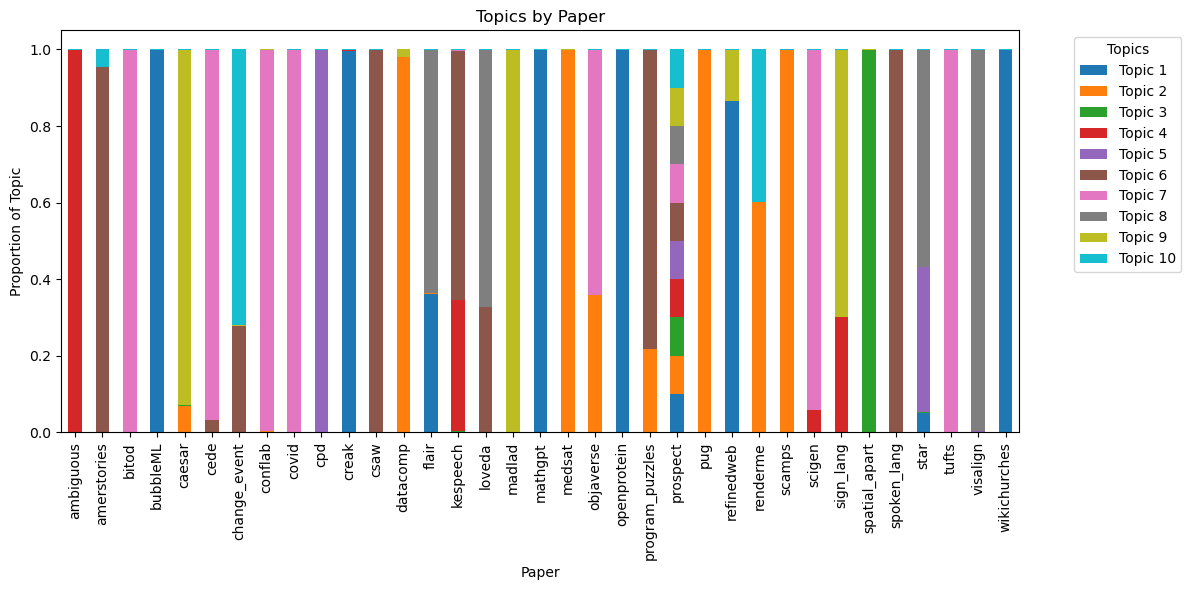

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

In [20]:
##plot proportion of topics in each paper

paperTopics = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]

##make dataframe of the probability of each topic occuring in each document
topicDistributions = pd.DataFrame(
    [[topic_prob for topic_id, topic_prob in doc] for doc in paperTopics],
    columns=[f'Topic {i+1}' for i in range(numTopics)]
)

##identifying each document by paperacronym
topicDistributions['paperacronym'] = groupedTokens['paperacronym'].values
##set paperacronym as index
topicDistributions.set_index('paperacronym', inplace=True)

##make stacked barplot
topicDistributions.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')
plt.ylabel("Proportion of Topic")
plt.xlabel("Paper")
plt.title("Topics by Paper")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Analyze answers on a question-by-question basis

In [21]:
##group data by questions
questionAnswersString = (
    datasheetsContent.groupby("questionum")["answer"]
      .apply(lambda x: " ".join(x.astype(str)))
      .reset_index()
)

###print(questionAnswersString)

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

In [22]:
##process text data

questionAnswersString["processedTokens"] = questionAnswersString["answer"].apply(process)
###print(groupedAnswersString)

groupedQuestionTokens = questionAnswersString.groupby('questionum')['processedTokens'].sum().reset_index()
###print(groupedQuestionTokens)


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

### *Word Frequency*

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 43), ('data', 40), ('model', 25), ('datasets', 23), ('created', 22), ('task', 21), ('language', 18), ('research', 15), ('benchmark', 14), ('health', 13), ('generation', 10), ('human', 10), ('image', 9), ('enable', 8), ('existing', 8), ('reasoning', 8), ('new', 8), ('system', 8), ('training', 8), ('available', 8)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


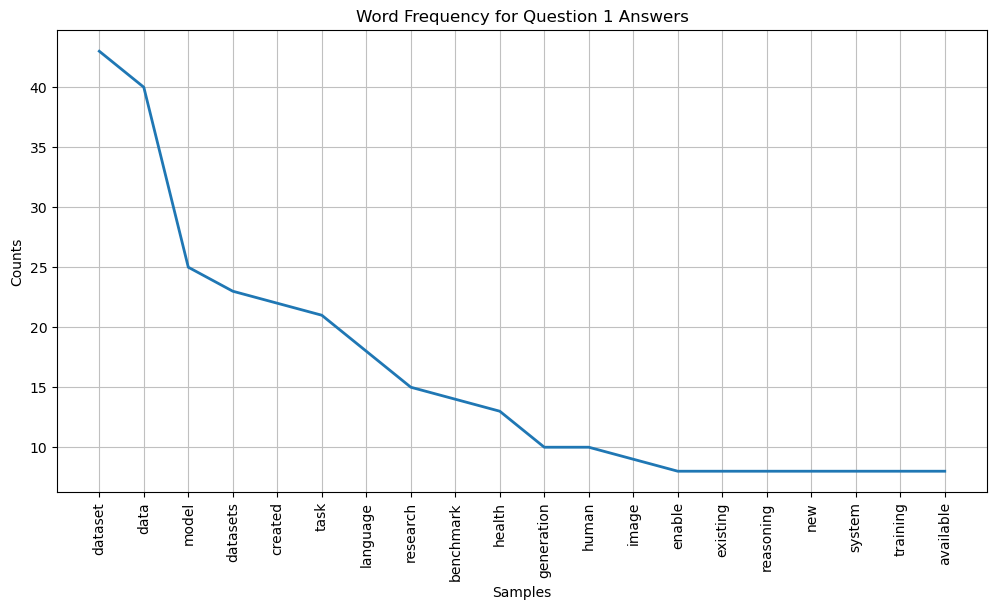

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('university', 29), ('dataset', 23), ('created', 21), ('ai', 15), ('researcher', 14), ('research', 12), ('laboratory', 12), ('data', 10), ('shanghai', 10), ('lab', 7), ('team', 7), ('author', 6), ('institute', 6), ('sensetime', 6), ('computer', 5), ('department', 5), ('information', 5), ('technology', 5), ('south', 5), ('science', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

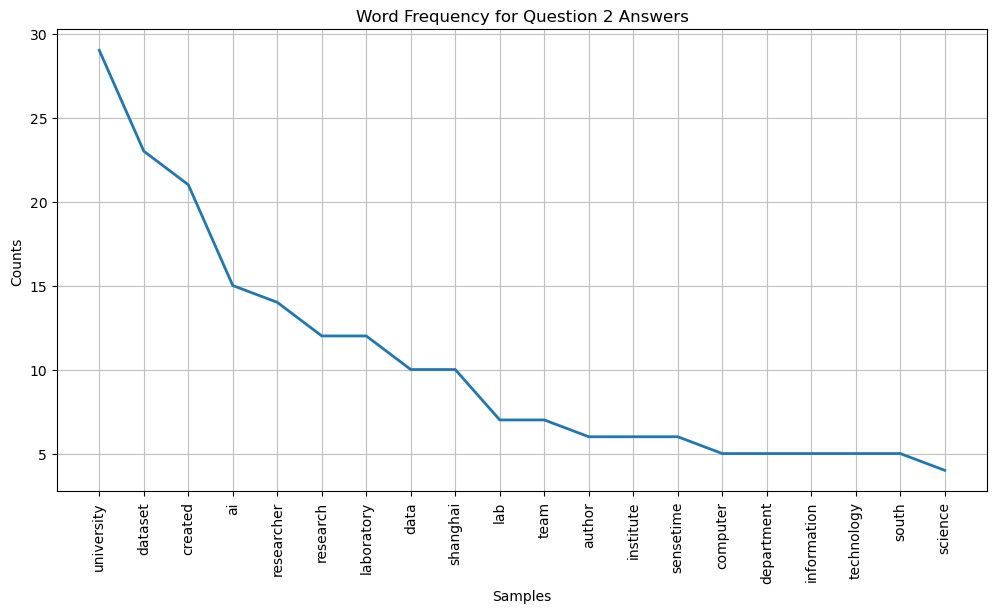

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('research', 16), ('funded', 16), ('dataset', 12), ('grant', 11), ('work', 9), ('science', 8), ('national', 7), ('foundation', 7), ('provided', 7), ('ai', 6), ('institute', 6), ('supported', 6), ('microsoft', 5), ('program', 5), ('number', 5), ('compute', 5), ('project', 4), ('learning', 4), ('google', 4), ('funding', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

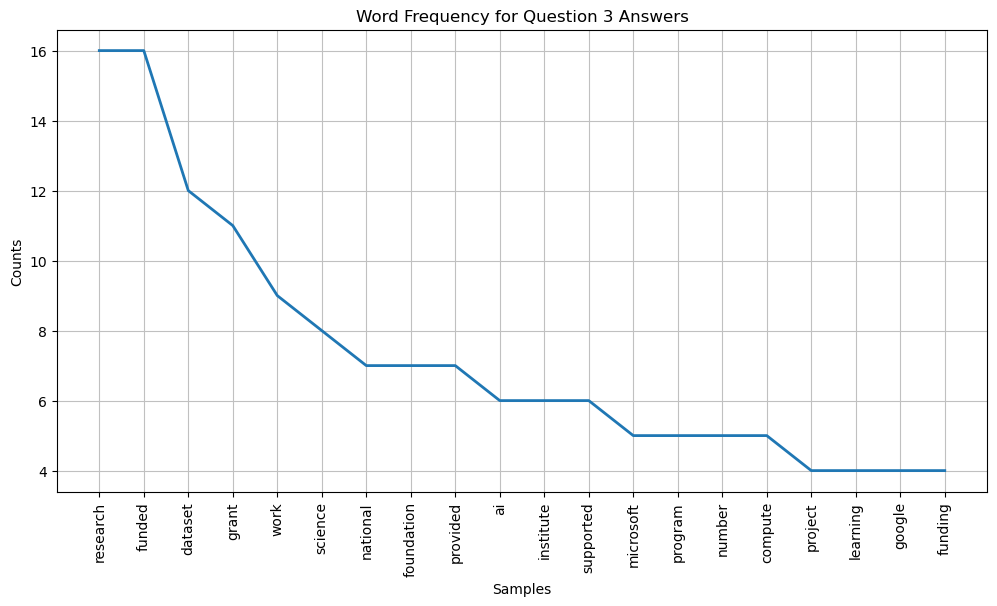

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('model', 5), ('deduplication', 5), ('change', 4), ('filtering', 4), ('datasets', 3), ('refinedweb', 3), ('resolution', 2), ('used', 2), ('higher', 2), ('commoncrawl', 2), ('using', 2), ('pipeline', 2), ('combine', 2), ('content', 2), ('heuristic', 2), ('trillion', 2), ('token', 2), ('strict', 2), ('language', 2), ('use', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


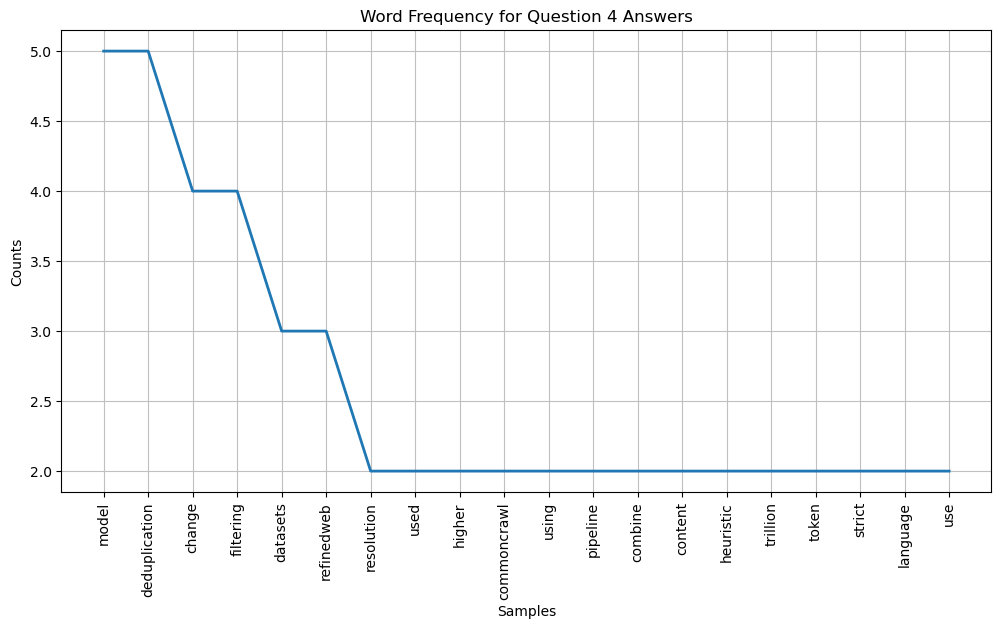

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('image', 32), ('instance', 31), ('dataset', 18), ('annotation', 10), ('video', 10), ('data', 10), ('corresponding', 9), ('contains', 9), ('satellite', 9), ('also', 8), ('change', 8), ('officer', 7), ('consists', 6), ('one', 6), ('metadata', 6), ('type', 6), ('event', 6), ('class', 6), ('object', 6), ('year', 6)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

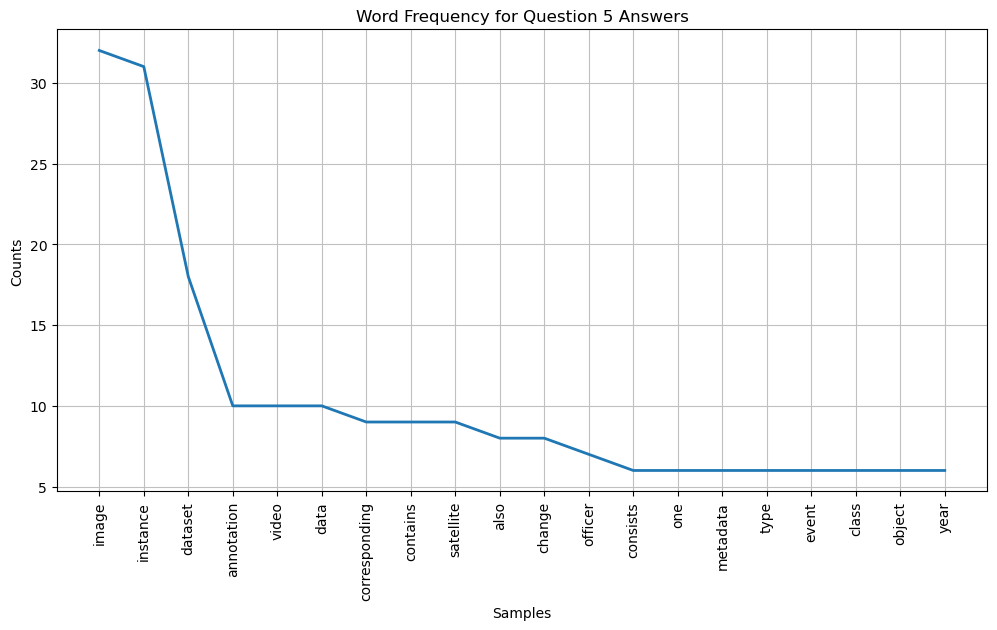

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('image', 29), ('annotation', 22), ('instance', 19), ('dataset', 15), ('total', 13), ('data', 12), ('contains', 10), ('video', 10), ('also', 9), ('camera', 9), ('subject', 8), ('hz', 8), ('annotated', 7), ('see', 7), ('time', 6), ('consists', 6), ('study', 6), ('appendix', 6), ('participant', 6), ('set', 6)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


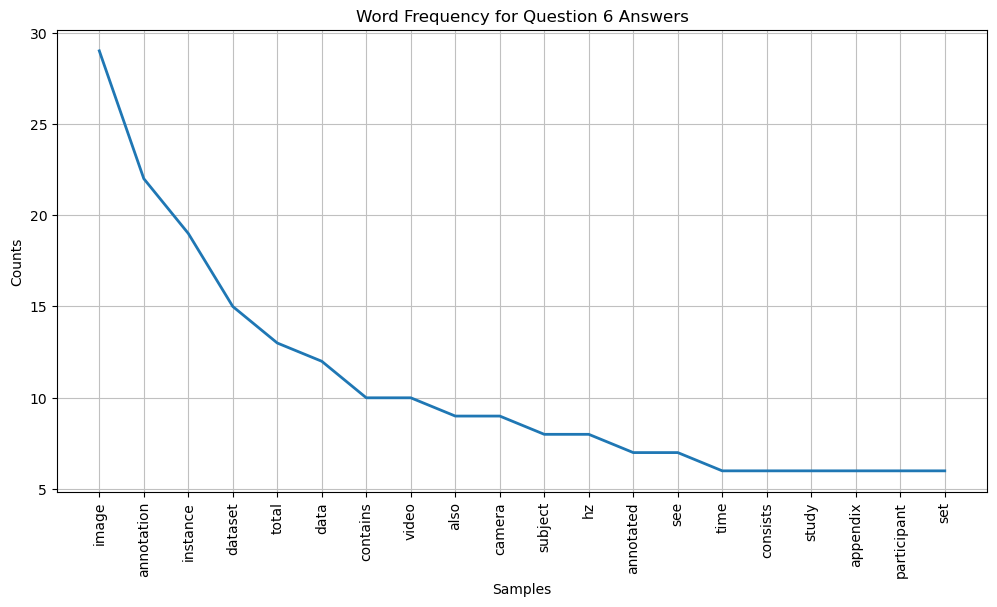

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 28), ('sample', 25), ('data', 19), ('instance', 14), ('possible', 13), ('representative', 10), ('image', 9), ('set', 9), ('sampled', 9), ('larger', 8), ('cover', 8), ('mammogram', 8), ('language', 7), ('city', 7), ('using', 7), ('contains', 7), ('however', 6), ('entity', 6), ('reason', 6), ('distribution', 6)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

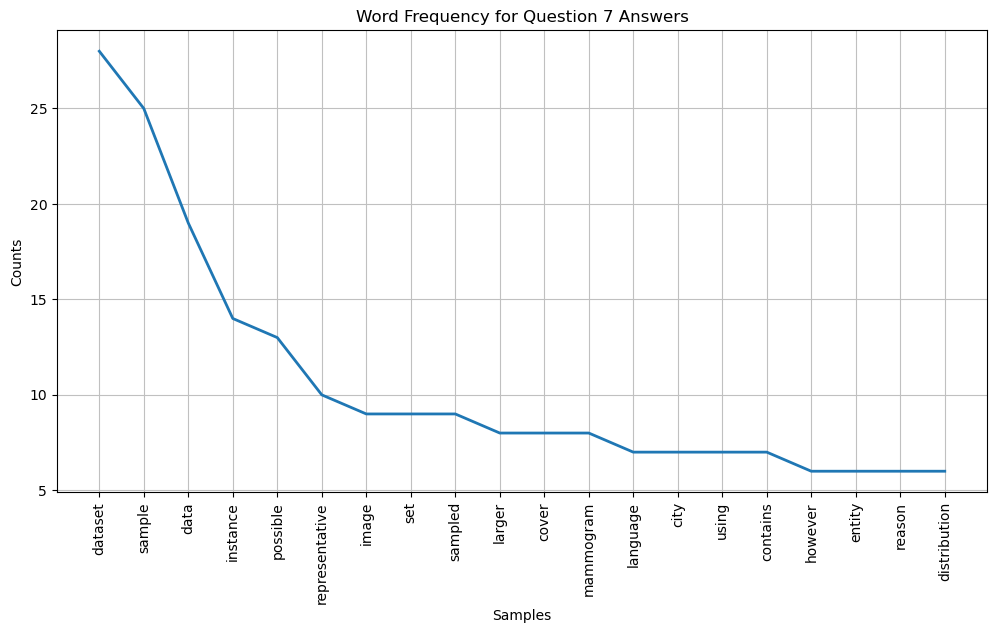

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('image', 35), ('instance', 22), ('consists', 13), ('id', 13), ('file', 11), ('corresponding', 10), ('contains', 9), ('data', 9), ('video', 9), ('dataset', 8), ('metadata', 8), ('number', 8), ('object', 8), ('date', 8), ('raw', 8), ('table', 7), ('annotation', 7), ('mask', 7), ('change', 7), ('satellite', 7)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

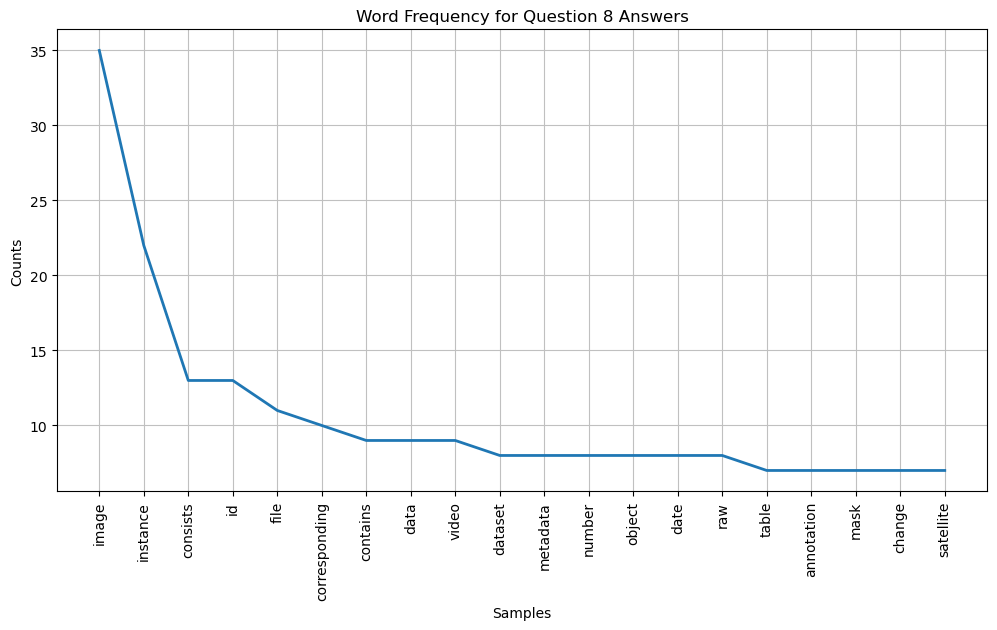

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('label', 19), ('image', 11), ('yes', 11), ('associated', 8), ('annotation', 8), ('target', 7), ('instance', 7), ('one', 6), ('file', 6), ('prescription', 6), ('used', 5), ('provide', 5), ('level', 5), ('csv', 5), ('however', 4), ('text', 4), ('labeled', 4), ('annotated', 4), ('data', 4), ('included', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

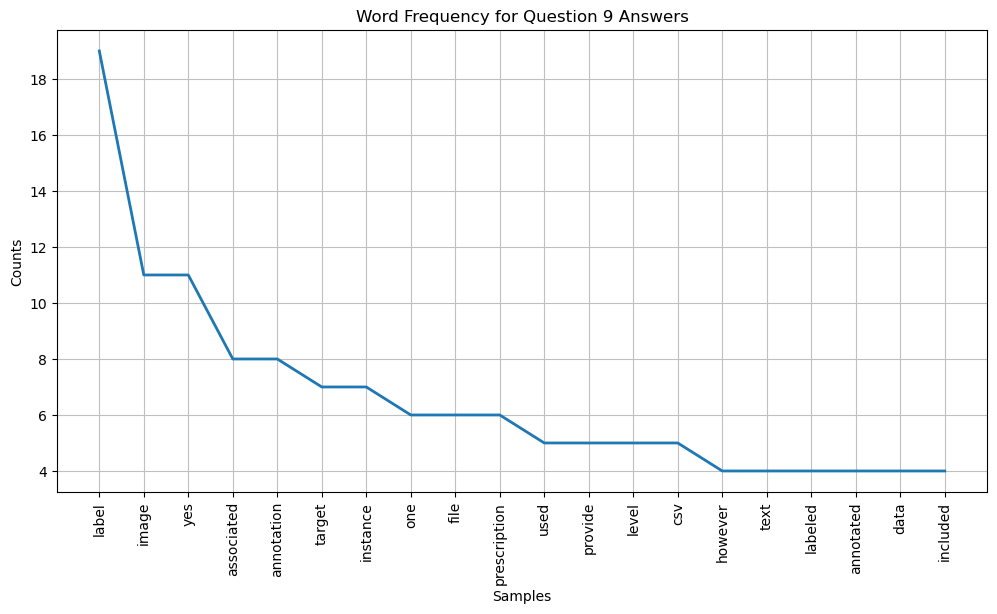

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('missing', 22), ('information', 12), ('instance', 11), ('data', 11), ('lsoas', 9), ('dataset', 6), ('included', 6), ('feature', 6), ('product', 6), ('camera', 5), ('lsoa', 4), ('value', 4), ('shapefiles', 4), ('individual', 3), ('file', 3), ('provide', 3), ('outcome', 3), ('census', 3), ('due', 3), ('video', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

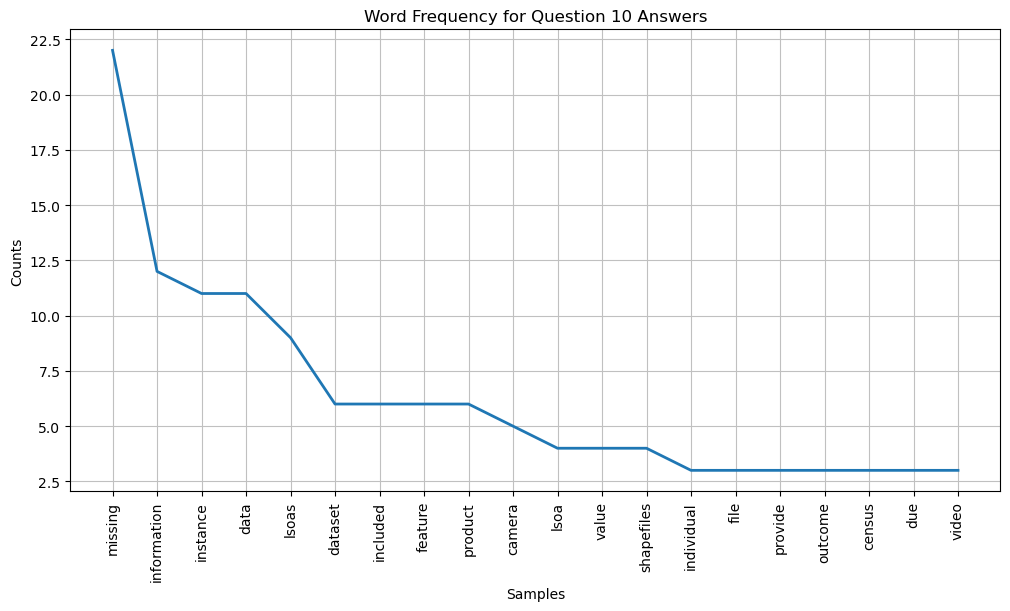

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('instance', 12), ('image', 11), ('data', 10), ('explicitly', 6), ('explicit', 5), ('subject', 5), ('yes', 4), ('area', 4), ('relationship', 4), ('id', 4), ('associated', 4), ('paper', 3), ('related', 3), ('annotation', 3), ('independent', 3), ('provide', 3), ('officer', 3), ('record', 3), ('individual', 3), ('number', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

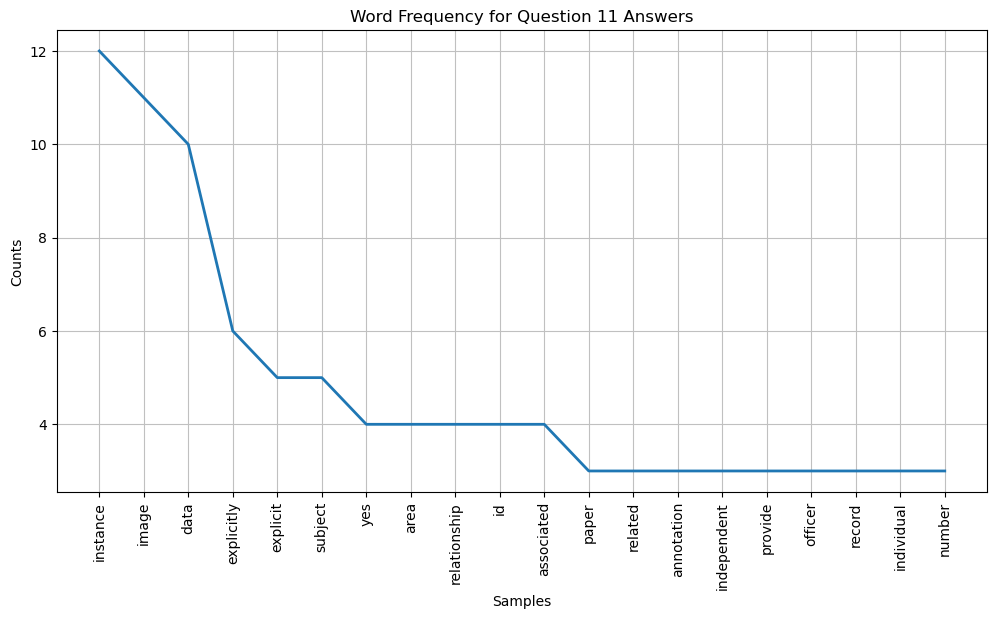

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('split', 44), ('set', 23), ('training', 22), ('image', 22), ('test', 21), ('data', 19), ('validation', 14), ('dataset', 12), ('task', 11), ('used', 11), ('class', 11), ('subset', 10), ('testing', 9), ('recommended', 8), ('provided', 7), ('different', 7), ('provide', 7), ('area', 7), ('label', 7), ('yes', 6)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

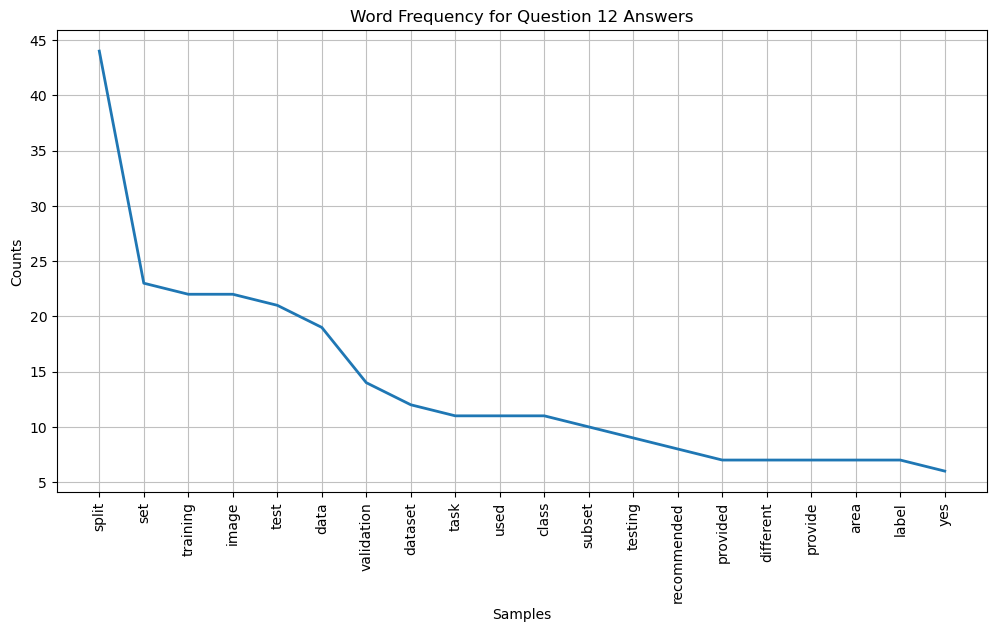

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('error', 25), ('may', 17), ('noise', 15), ('dataset', 15), ('data', 14), ('image', 10), ('source', 9), ('township', 9), ('building', 8), ('quality', 7), ('annotation', 6), ('however', 6), ('also', 6), ('feature', 6), ('change', 5), ('label', 5), ('pose', 5), ('known', 4), ('extracted', 4), ('result', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

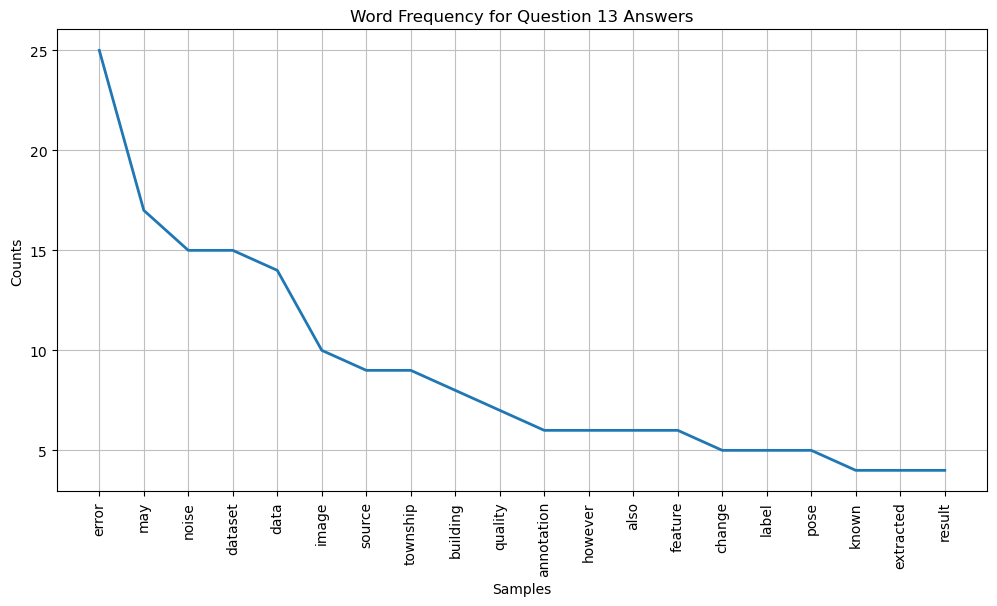

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 37), ('data', 12), ('source', 10), ('image', 10), ('video', 8), ('original', 8), ('provided', 7), ('release', 6), ('external', 6), ('yes', 6), ('link', 6), ('available', 5), ('resource', 5), ('file', 5), ('publicly', 4), ('distributed', 4), ('part', 4), ('http', 4), ('user', 4), ('license', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

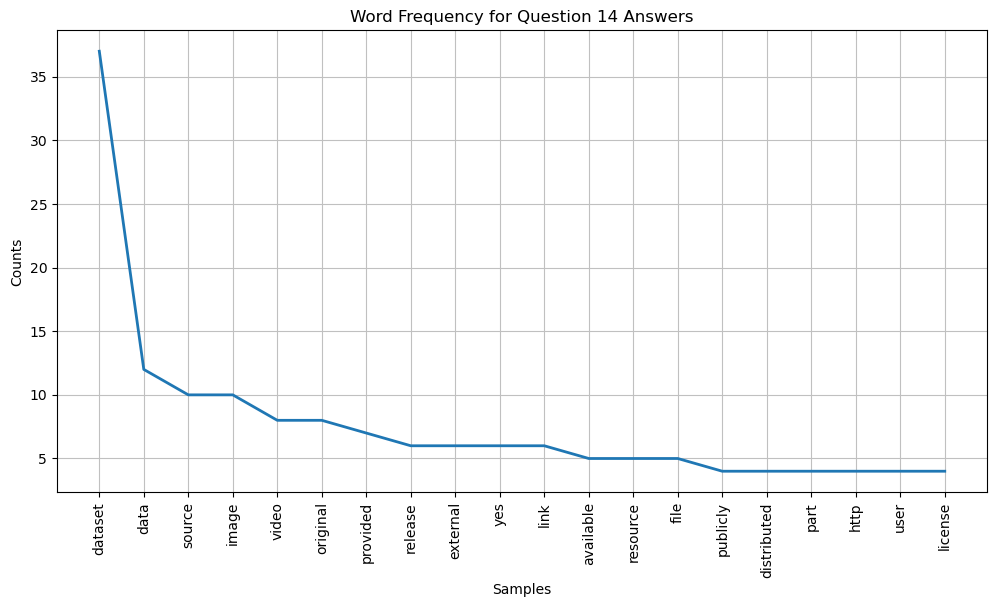

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 22), ('dataset', 17), ('confidential', 12), ('contain', 10), ('information', 8), ('video', 7), ('available', 6), ('public', 6), ('building', 5), ('contains', 4), ('publicly', 4), ('considered', 3), ('possible', 3), ('individual', 3), ('image', 2), ('datasets', 2), ('used', 2), ('previous', 2), ('platform', 2), ('use', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

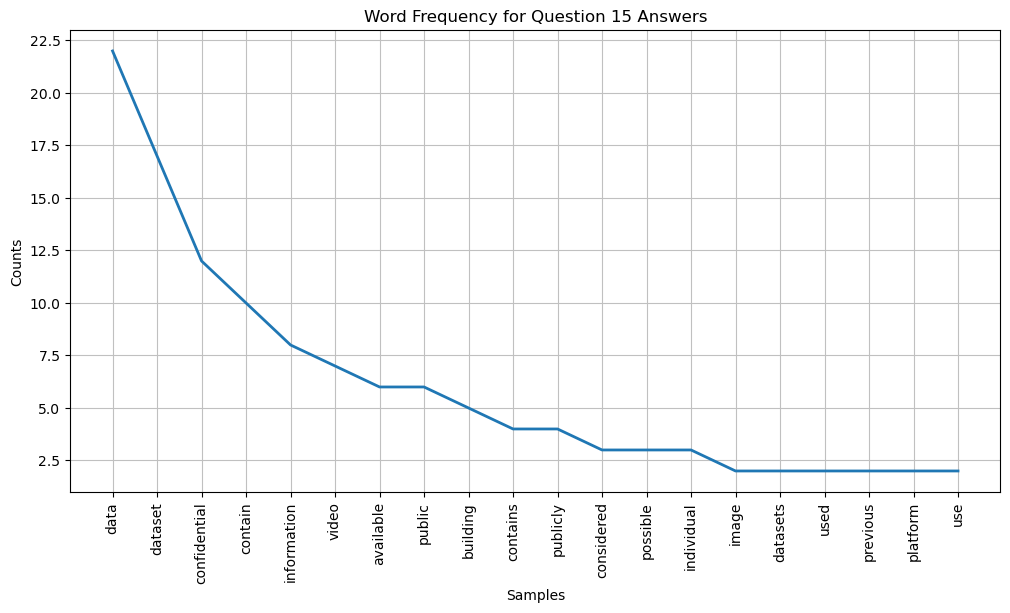

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 11), ('offensive', 9), ('data', 9), ('contains', 7), ('content', 7), ('insulting', 6), ('threatening', 6), ('contain', 5), ('may', 4), ('yes', 4), ('might', 4), ('cause', 4), ('anxiety', 4), ('video', 4), ('table', 3), ('image', 3), ('likely', 3), ('otherwise', 3), ('toxic', 3), ('even', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

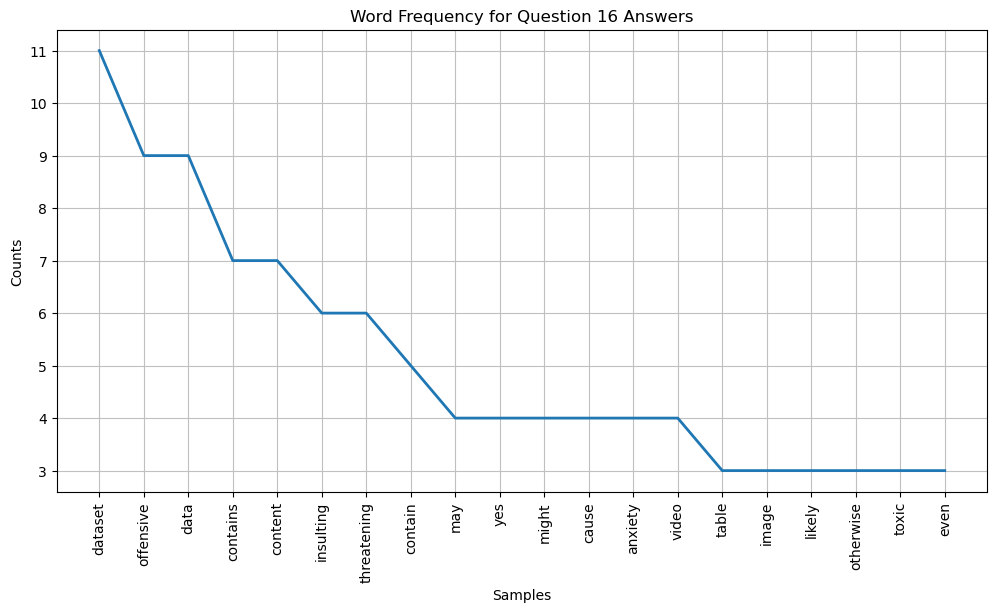

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 26), ('people', 18), ('subpopulation', 14), ('age', 14), ('gender', 11), ('relate', 7), ('data', 7), ('identify', 7), ('information', 6), ('face', 5), ('contains', 5), ('yes', 5), ('ethnicity', 5), ('group', 5), ('may', 4), ('participant', 4), ('individual', 4), ('census', 4), ('screening', 4), ('record', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

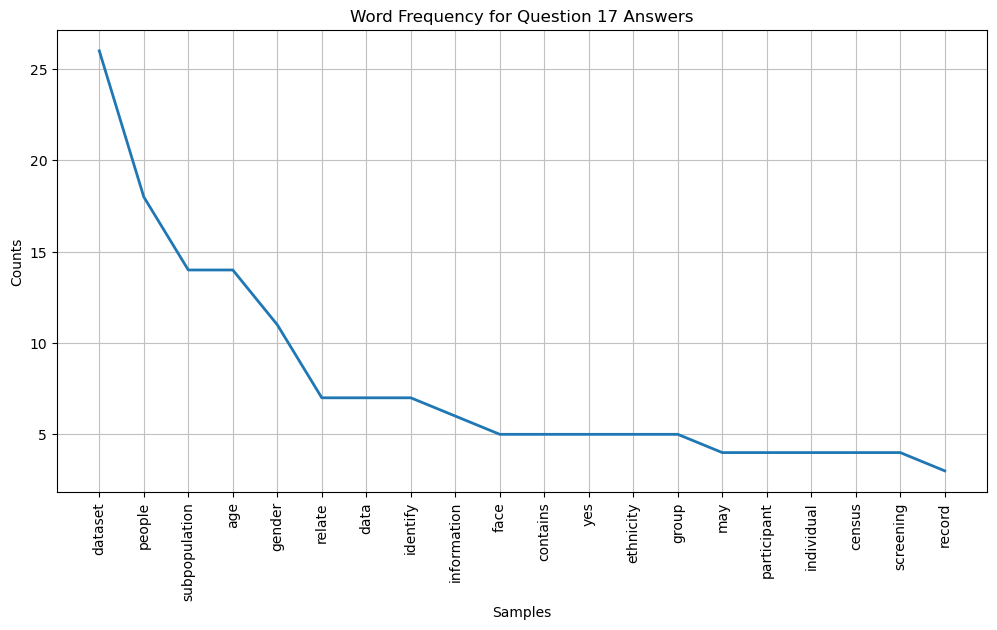

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 16), ('individual', 13), ('people', 11), ('may', 10), ('possible', 10), ('identify', 9), ('relate', 7), ('information', 7), ('data', 5), ('name', 5), ('human', 4), ('identified', 4), ('face', 4), ('video', 4), ('used', 3), ('also', 3), ('yes', 3), ('case', 3), ('recording', 3), ('conference', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

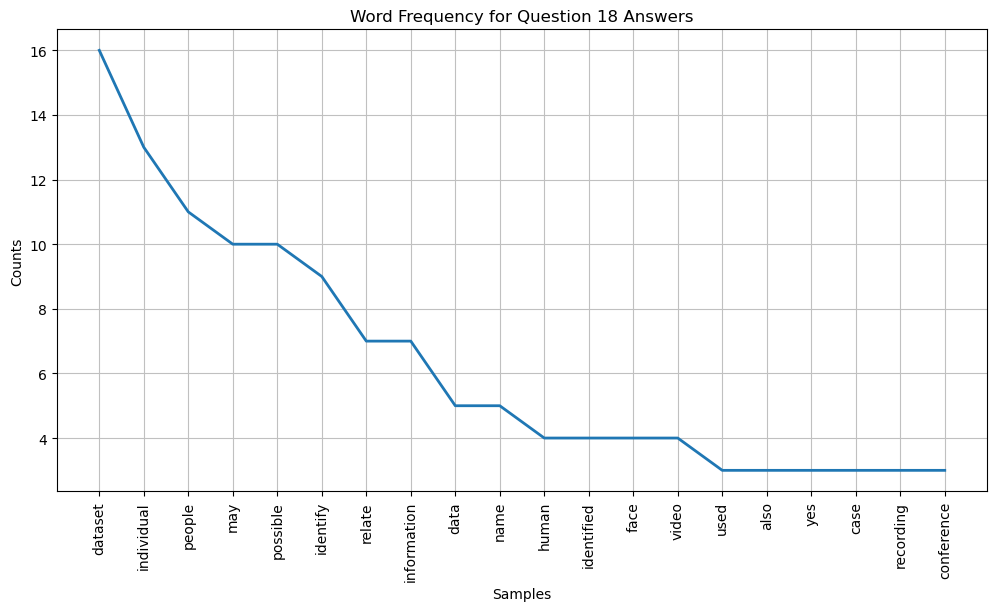

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 21), ('dataset', 18), ('people', 11), ('sensitive', 8), ('relate', 7), ('information', 7), ('ea', 5), ('ommon', 4), ('p', 4), ('ool', 4), ('image', 4), ('census', 4), ('claim', 4), ('human', 3), ('contain', 3), ('contains', 3), ('yes', 3), ('available', 3), ('public', 3), ('filtering', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

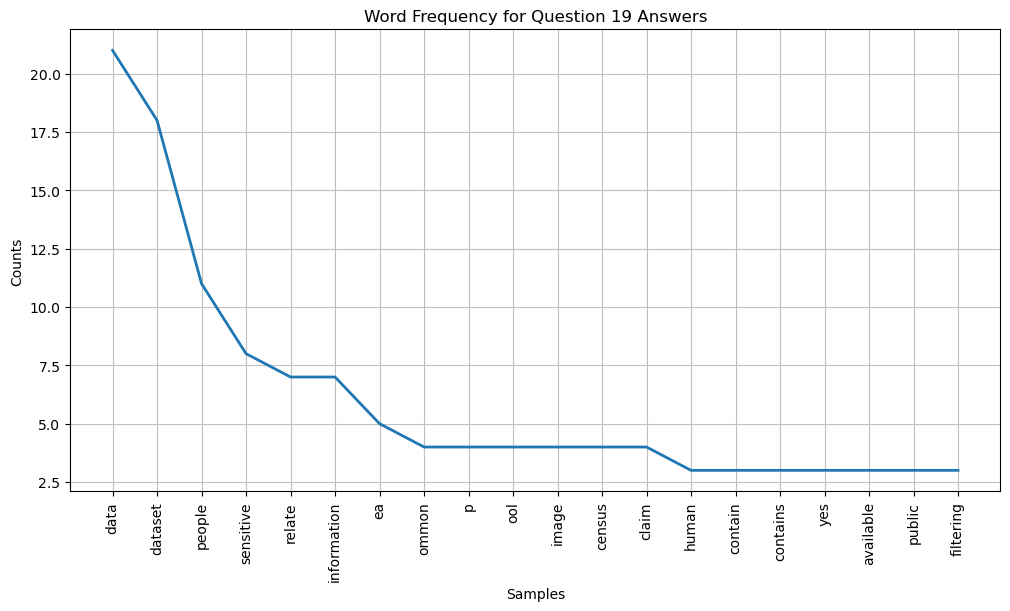

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('research', 2), ('ommon', 1), ('p', 1), ('ool', 1), ('artifact', 1), ('hope', 1), ('useful', 1), ('studying', 1), ('make', 1), ('datasets', 1), ('safer', 1), ('call', 1), ('responsible', 1), ('usage', 1), ('dataset', 1), ('purpose', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

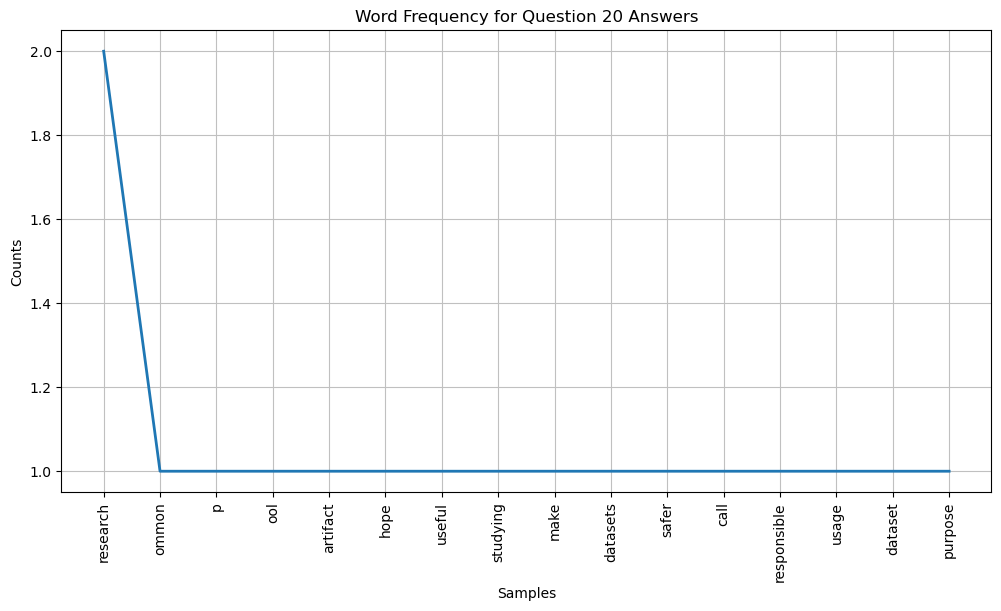

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 26), ('image', 15), ('dataset', 11), ('collected', 9), ('directly', 9), ('using', 8), ('available', 7), ('paper', 6), ('annotation', 6), ('information', 6), ('subject', 6), ('category', 6), ('source', 5), ('provided', 5), ('obtained', 5), ('individual', 5), ('sensing', 4), ('publicly', 4), ('label', 4), ('manually', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

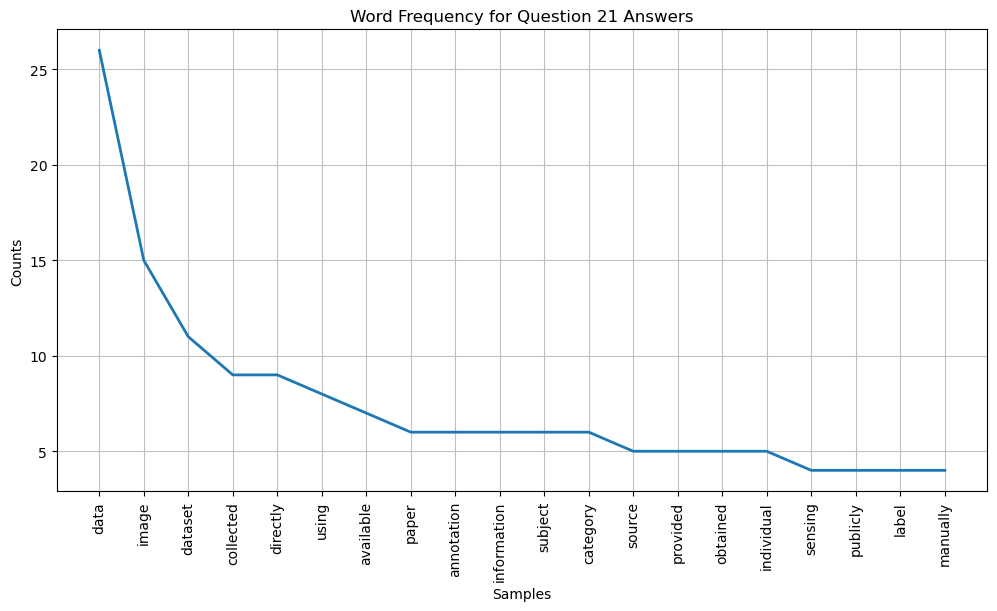

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 27), ('used', 13), ('image', 13), ('using', 13), ('annotation', 11), ('collection', 11), ('expert', 8), ('collected', 7), ('process', 7), ('manually', 6), ('manual', 6), ('pair', 6), ('see', 6), ('two', 5), ('google', 5), ('validation', 5), ('detail', 5), ('documented', 5), ('system', 5), ('instance', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

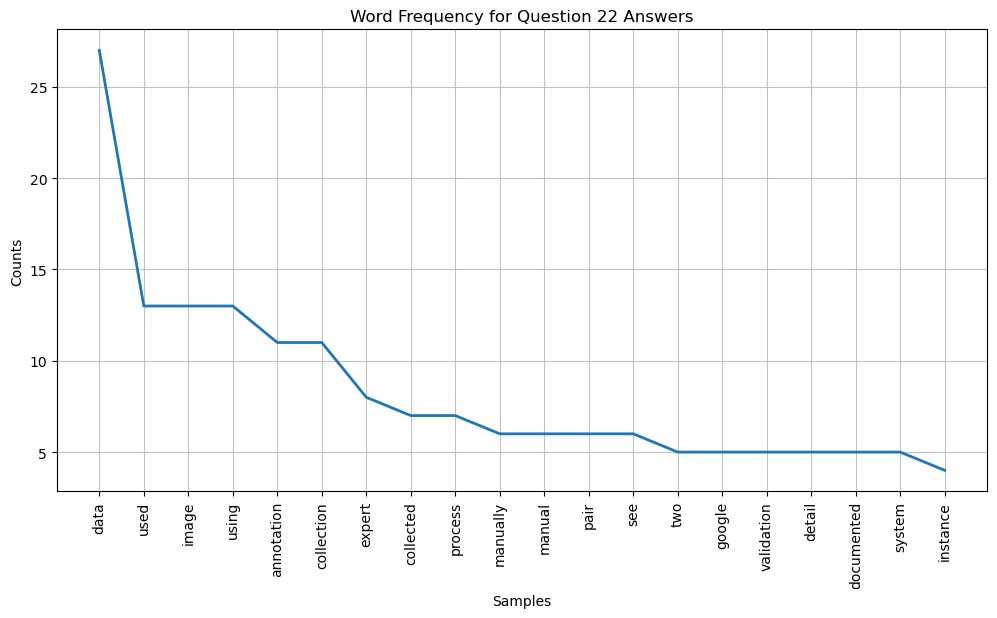

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 10), ('data', 7), ('sampling', 6), ('possible', 6), ('subset', 6), ('sampled', 6), ('sample', 5), ('selected', 4), ('set', 4), ('image', 4), ('randomly', 4), ('pug', 4), ('combination', 4), ('prompt', 4), ('minighosts', 4), ('problem', 3), ('larger', 3), ('representative', 3), ('different', 3), ('based', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


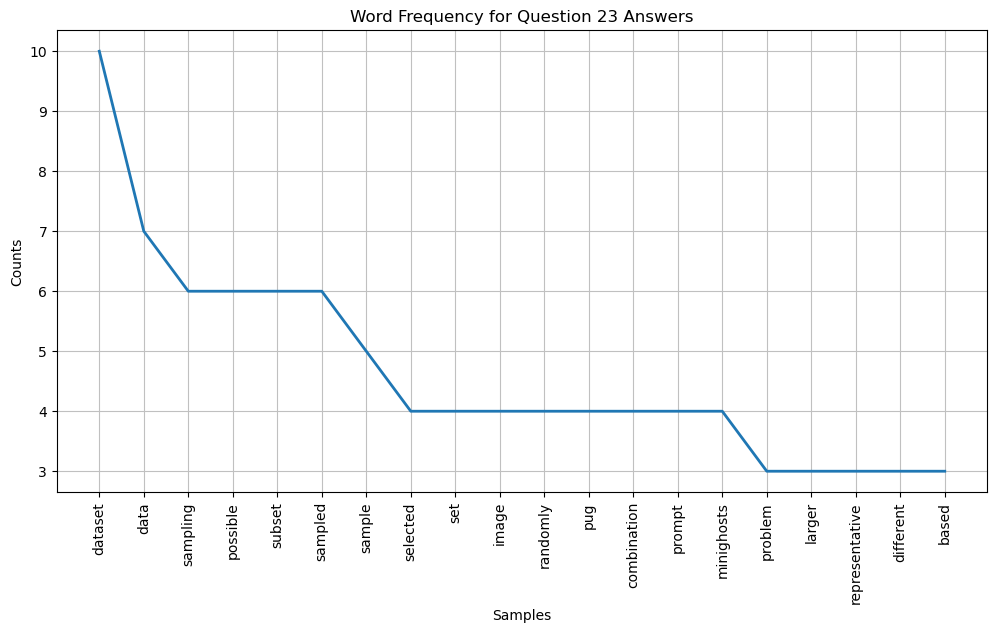

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 19), ('dataset', 11), ('collection', 10), ('author', 9), ('annotation', 9), ('event', 9), ('annotator', 8), ('student', 8), ('involved', 8), ('compensated', 8), ('conference', 8), ('paid', 7), ('research', 7), ('process', 7), ('researcher', 6), ('mechanical', 6), ('turk', 6), ('human', 5), ('change', 5), ('volunteer', 5)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

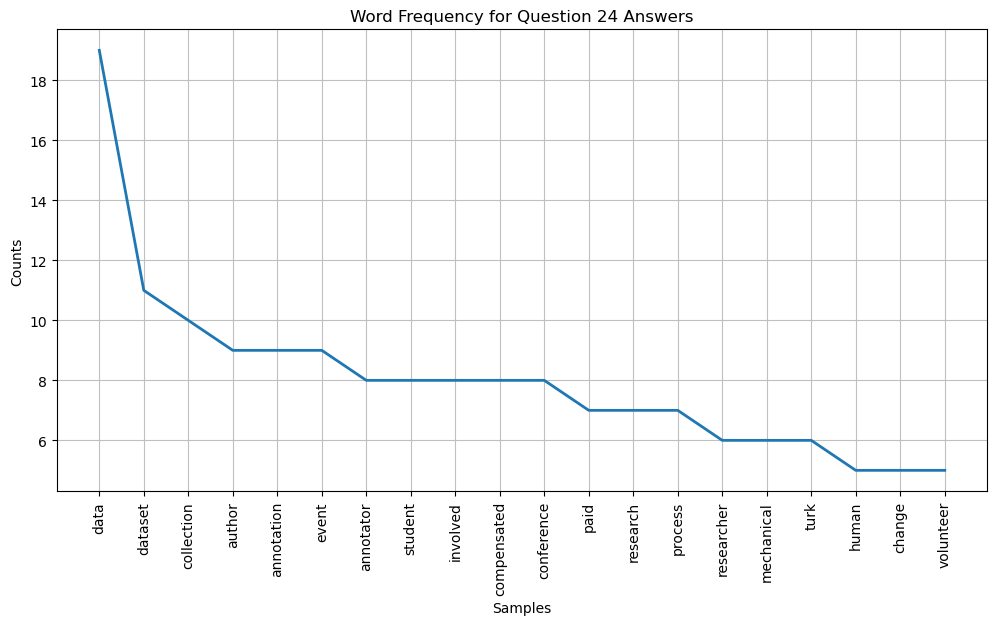

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 33), ('collected', 16), ('dataset', 11), ('annotation', 8), ('time', 8), ('creation', 6), ('created', 5), ('january', 5), ('june', 5), ('july', 5), ('using', 5), ('timeframe', 5), ('record', 5), ('collection', 5), ('image', 4), ('obtained', 4), ('day', 4), ('pertains', 4), ('aerial', 4), ('version', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

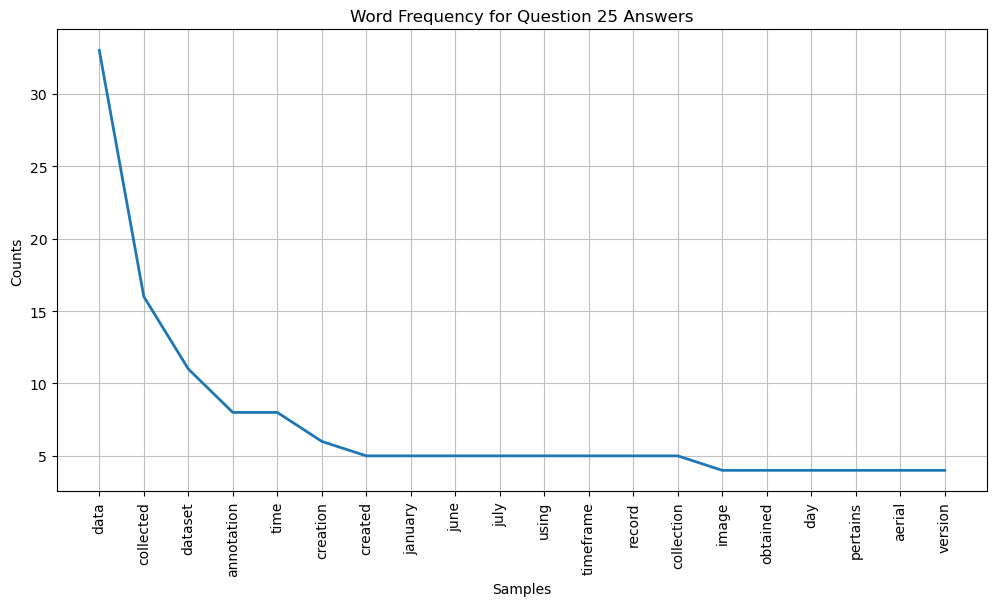

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('review', 17), ('data', 13), ('process', 9), ('dataset', 7), ('ethical', 7), ('approved', 7), ('collection', 6), ('conducted', 6), ('university', 6), ('board', 6), ('study', 5), ('user', 4), ('irb', 4), ('ethic', 4), ('yes', 4), ('institutional', 4), ('also', 4), ('subject', 4), ('research', 4), ('information', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

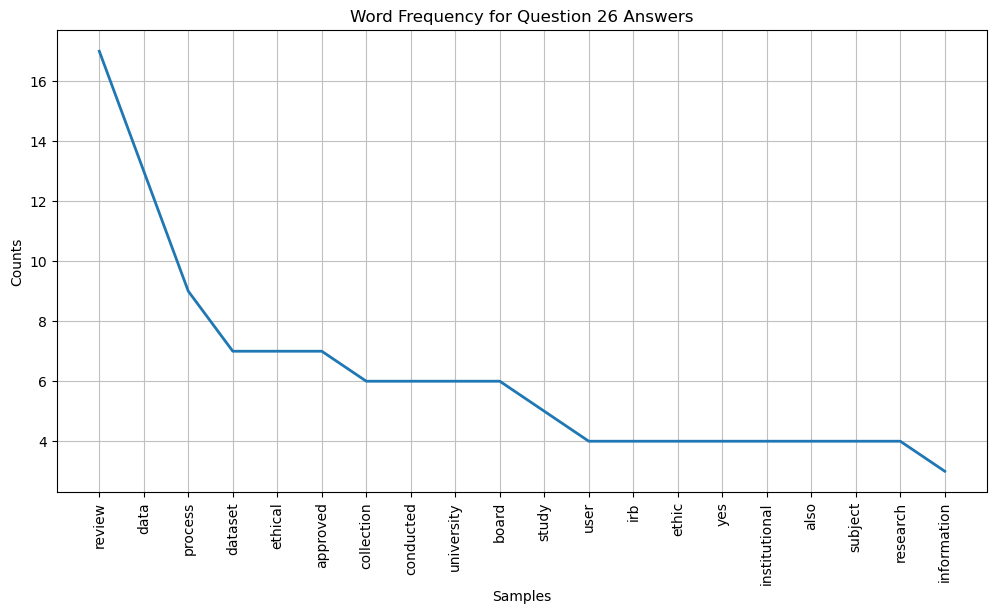

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 18), ('collected', 11), ('people', 10), ('dataset', 9), ('http', 7), ('relate', 5), ('via', 5), ('public', 4), ('human', 3), ('individual', 3), ('website', 3), ('institute', 3), ('directly', 3), ('amazon', 3), ('mechanical', 3), ('turk', 3), ('synthetic', 3), ('crawled', 3), ('youtube', 3), ('contain', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

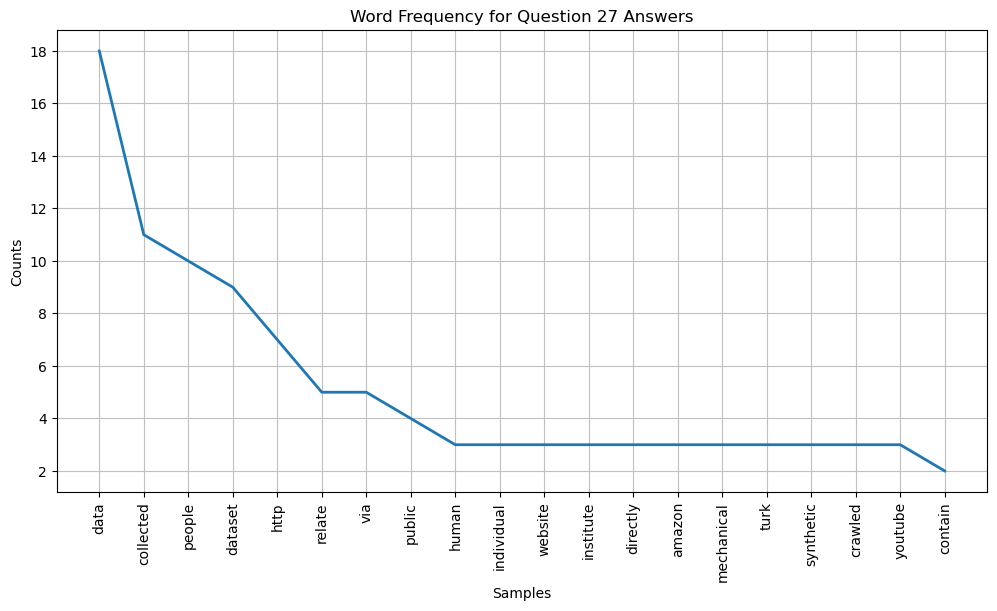

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 14), ('data', 14), ('people', 9), ('individual', 9), ('collection', 7), ('relate', 5), ('notified', 5), ('building', 5), ('figure', 5), ('yes', 4), ('using', 4), ('information', 3), ('informed', 3), ('collected', 3), ('participant', 3), ('sign', 3), ('description', 3), ('consent', 3), ('event', 3), ('http', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


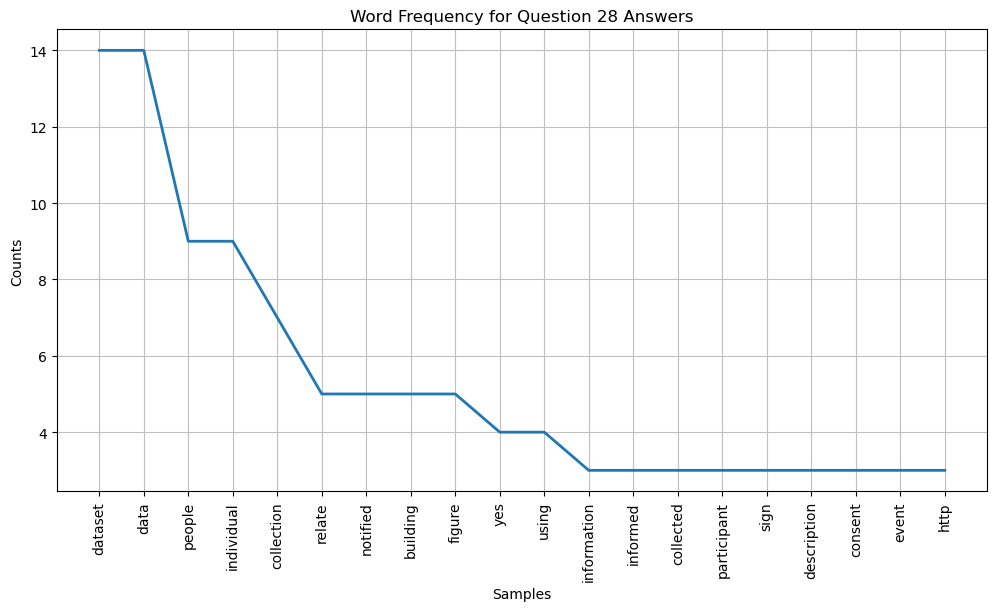

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 13), ('dataset', 10), ('consent', 10), ('people', 8), ('yes', 7), ('individual', 6), ('form', 6), ('relate', 5), ('collection', 5), ('statistic', 5), ('act', 5), ('http', 4), ('information', 3), ('image', 3), ('access', 3), ('agreement', 3), ('human', 2), ('usage', 2), ('download', 2), ('use', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

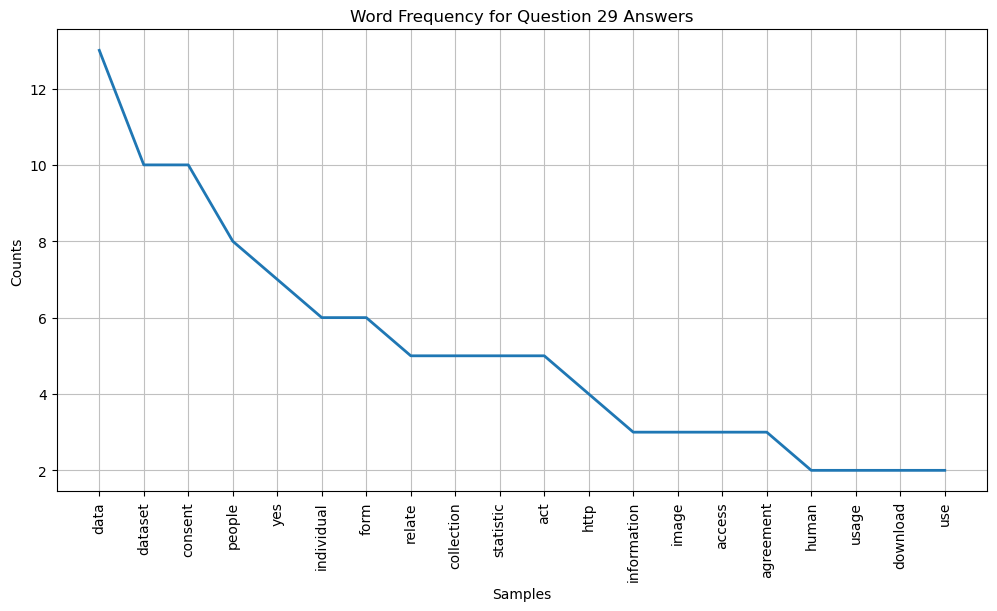

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 10), ('data', 8), ('people', 7), ('relate', 5), ('individual', 5), ('applicable', 5), ('http', 3), ('user', 3), ('request', 3), ('see', 3), ('yes', 3), ('consent', 3), ('form', 3), ('collection', 3), ('human', 2), ('information', 2), ('also', 2), ('content', 2), ('contacting', 2), ('section', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

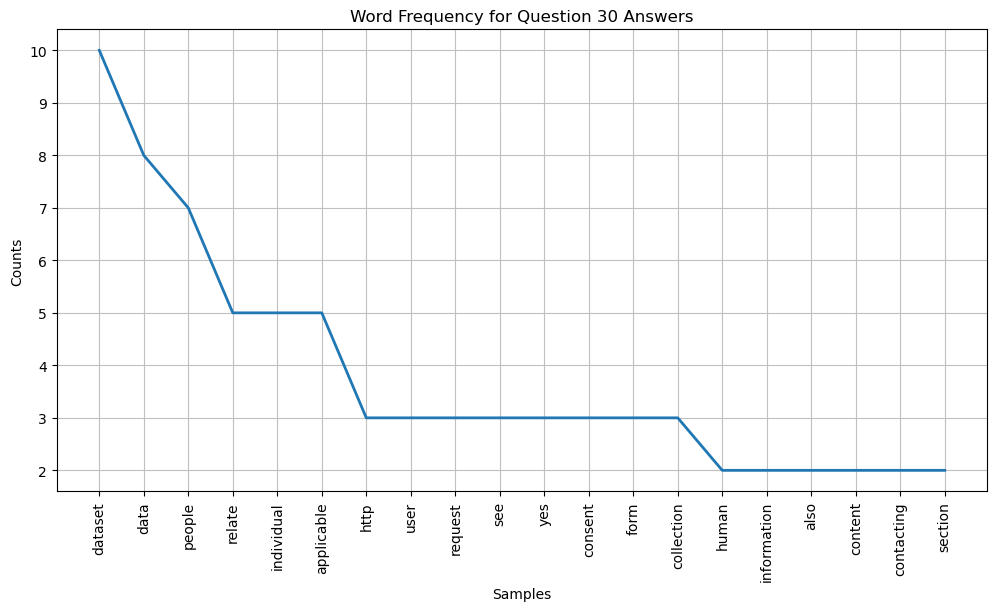

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 15), ('people', 8), ('data', 6), ('relate', 5), ('u', 4), ('analysis', 4), ('conduct', 3), ('ommon', 3), ('p', 3), ('ool', 3), ('also', 3), ('face', 3), ('conducted', 3), ('human', 2), ('information', 2), ('individual', 2), ('see', 2), ('detail', 2), ('study', 2), ('nsfw', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

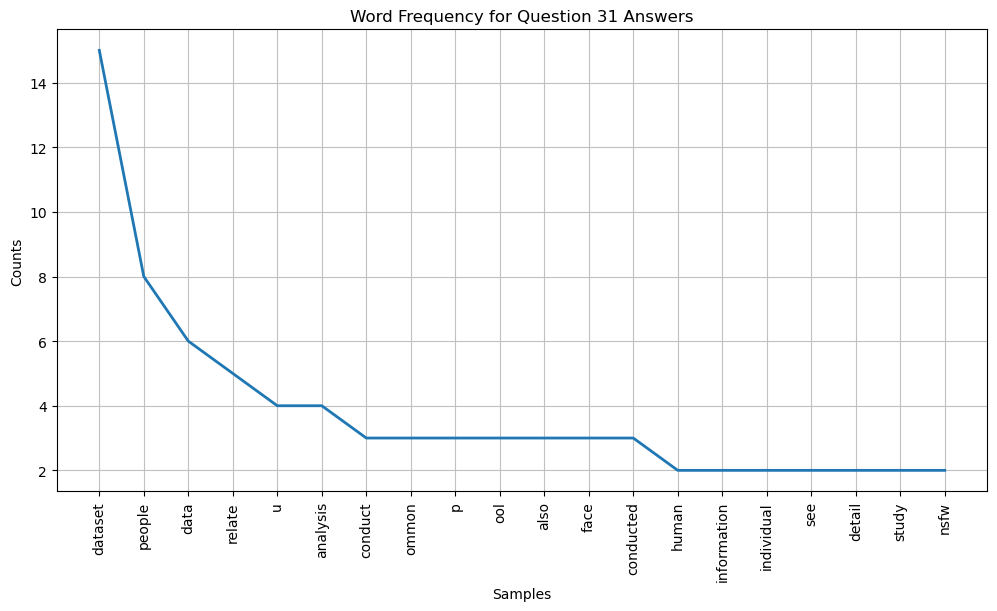

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('cost', 4), ('equipment', 3), ('energy', 3), ('consumption', 3), ('future', 2), ('conflab', 2), ('flight', 2), ('accommodation', 2), ('resulted', 2), ('six', 2), ('hope', 1), ('work', 1), ('use', 1), ('ommon', 1), ('p', 1), ('ool', 1), ('study', 1), ('construct', 1), ('safer', 1), ('datasets', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

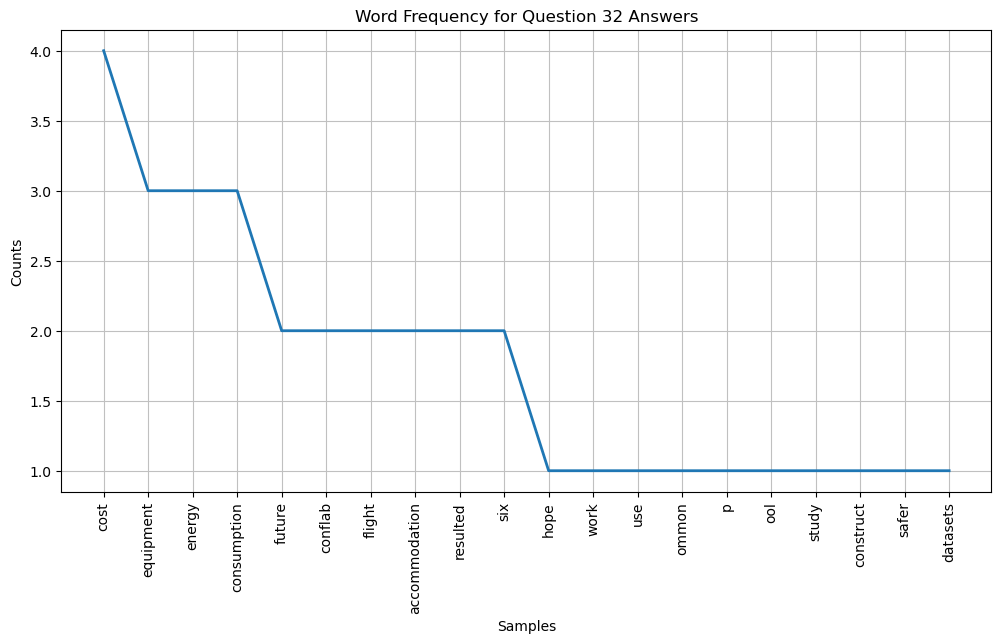

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('image', 21), ('data', 18), ('preprocessing', 17), ('dataset', 13), ('building', 9), ('section', 8), ('step', 8), ('raw', 8), ('quality', 7), ('removed', 7), ('yes', 6), ('cloud', 6), ('filter', 6), ('done', 6), ('simulation', 6), ('manually', 6), ('annotation', 5), ('pair', 5), ('see', 5), ('change', 5)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

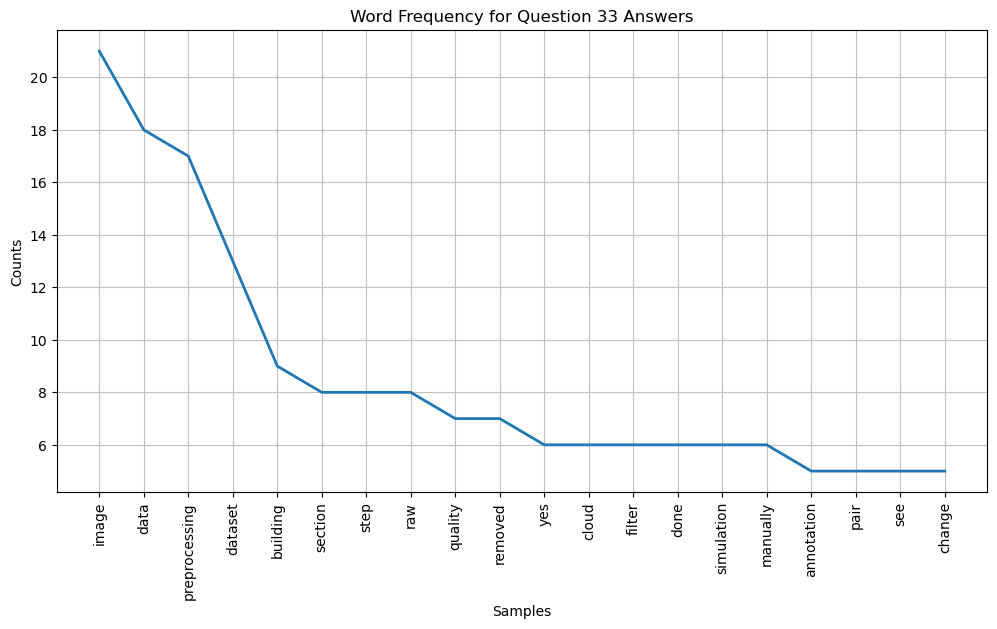

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 22), ('raw', 19), ('preprocessing', 12), ('dataset', 10), ('yes', 7), ('image', 6), ('saved', 6), ('available', 6), ('output', 5), ('used', 4), ('provided', 3), ('simulation', 3), ('request', 3), ('due', 3), ('source', 3), ('original', 3), ('case', 3), ('error', 2), ('change', 2), ('event', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

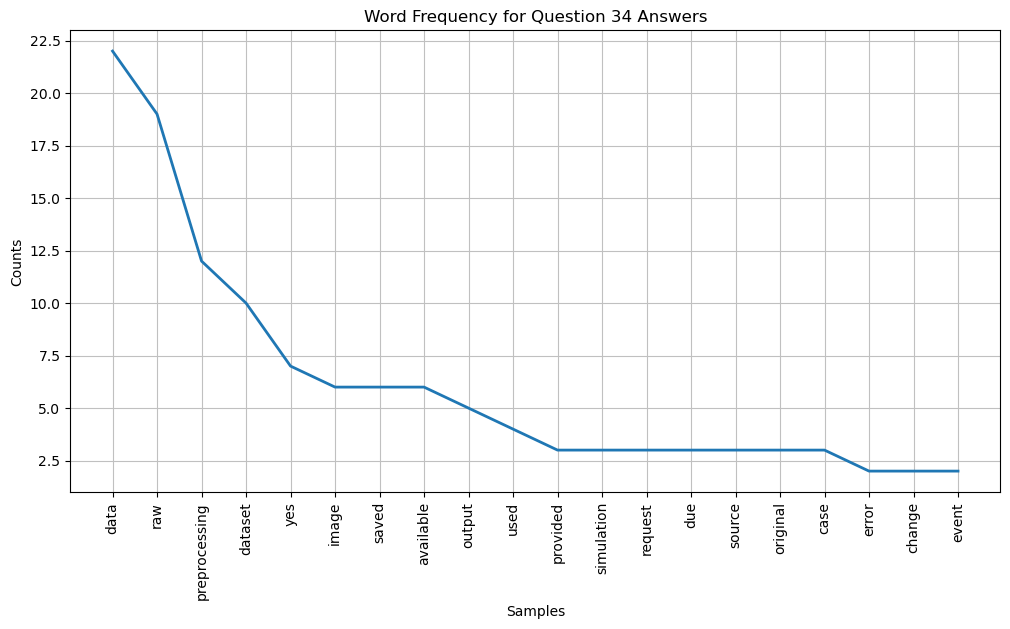

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('preprocessing', 15), ('http', 13), ('available', 9), ('data', 7), ('software', 7), ('done', 6), ('yes', 6), ('python', 6), ('cleaning', 5), ('used', 5), ('code', 4), ('annotation', 3), ('process', 3), ('github', 3), ('use', 3), ('detector', 3), ('dataset', 3), ('script', 3), ('step', 2), ('manually', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

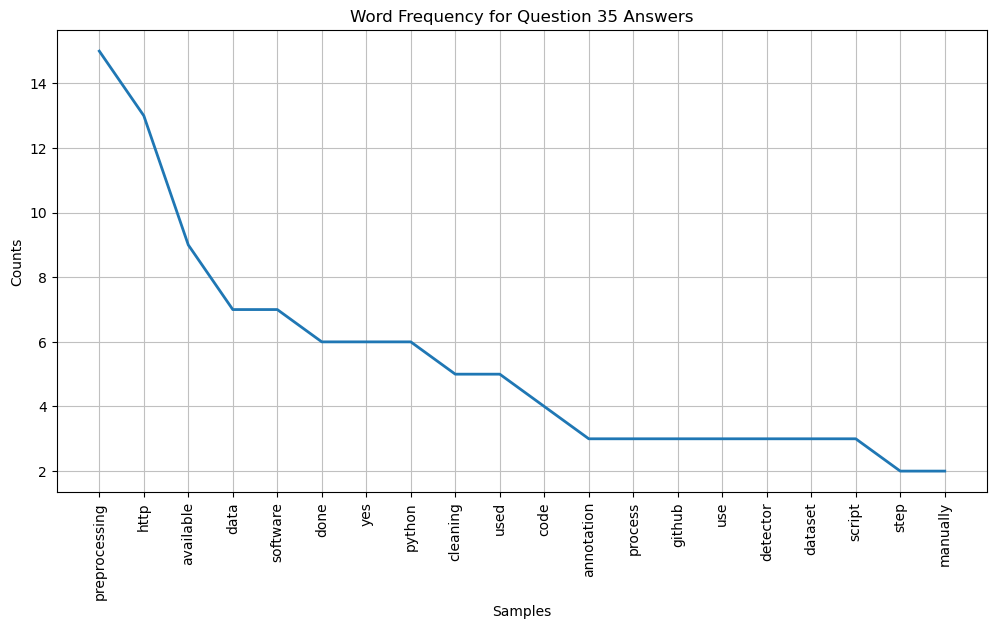

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 3), ('collection', 2), ('ommon', 1), ('p', 1), ('ool', 1), ('ata', 1), ('omp', 1), ('would', 1), ('possible', 1), ('without', 1), ('tool', 1), ('developed', 1), ('source', 1), ('community', 1), ('process', 1), ('indeed', 1), ('achieves', 1), ('initial', 1), ('goal', 1), ('creating', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

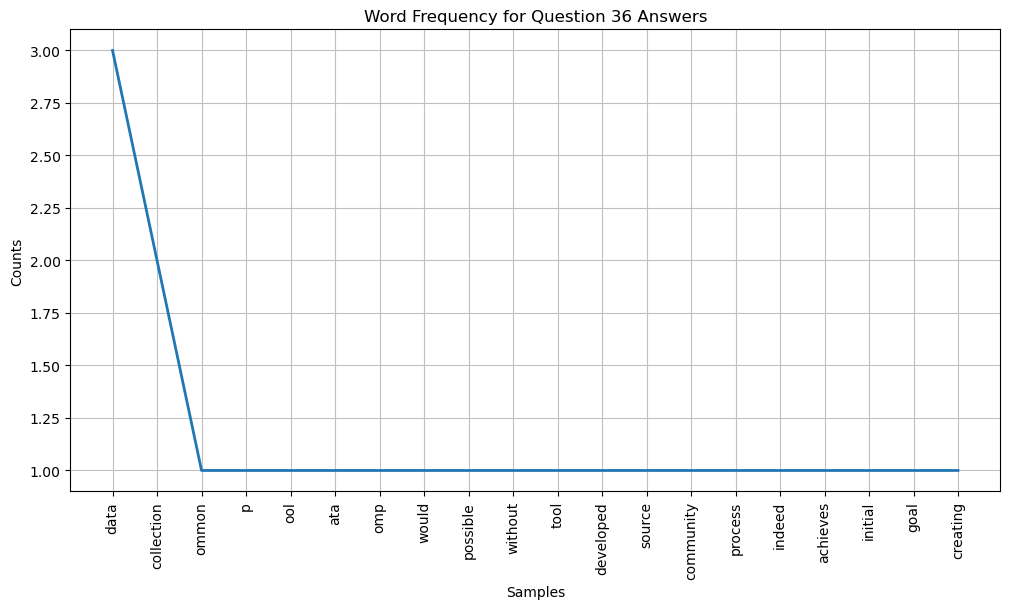

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('model', 30), ('used', 22), ('speech', 21), ('paper', 19), ('task', 18), ('dataset', 18), ('text', 13), ('experiment', 10), ('data', 10), ('yes', 10), ('language', 10), ('transcribed', 10), ('see', 7), ('section', 7), ('evaluated', 7), ('result', 7), ('visual', 6), ('subset', 6), ('evaluate', 6), ('classification', 6)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

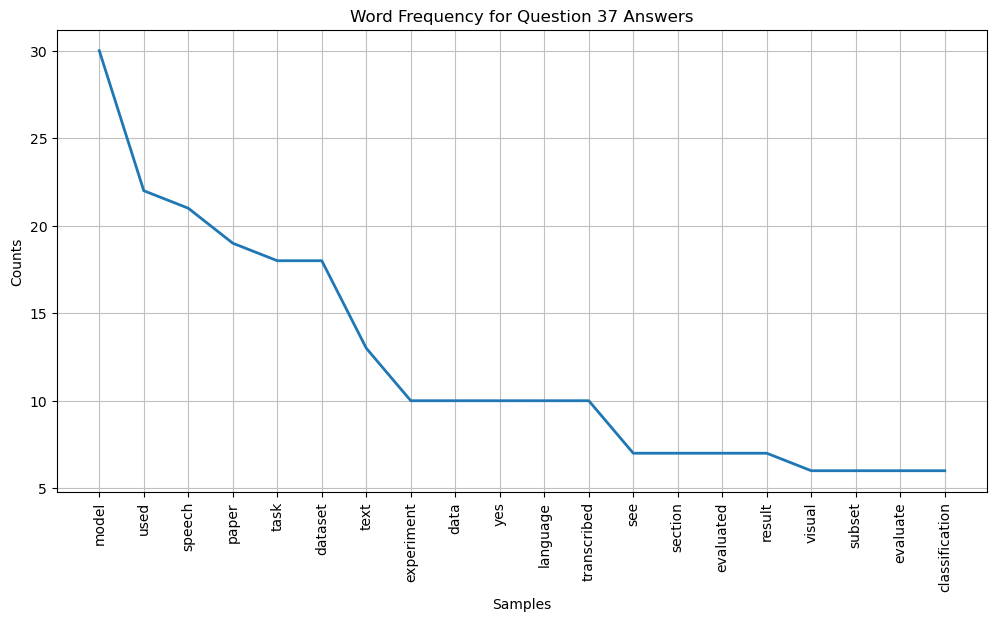

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 19), ('paper', 9), ('use', 7), ('link', 5), ('http', 4), ('currently', 4), ('work', 4), ('model', 4), ('task', 4), ('future', 4), ('repository', 4), ('yes', 4), ('used', 3), ('publication', 3), ('system', 3), ('flair', 3), ('et', 3), ('scholar', 3), ('relevant', 2), ('project', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

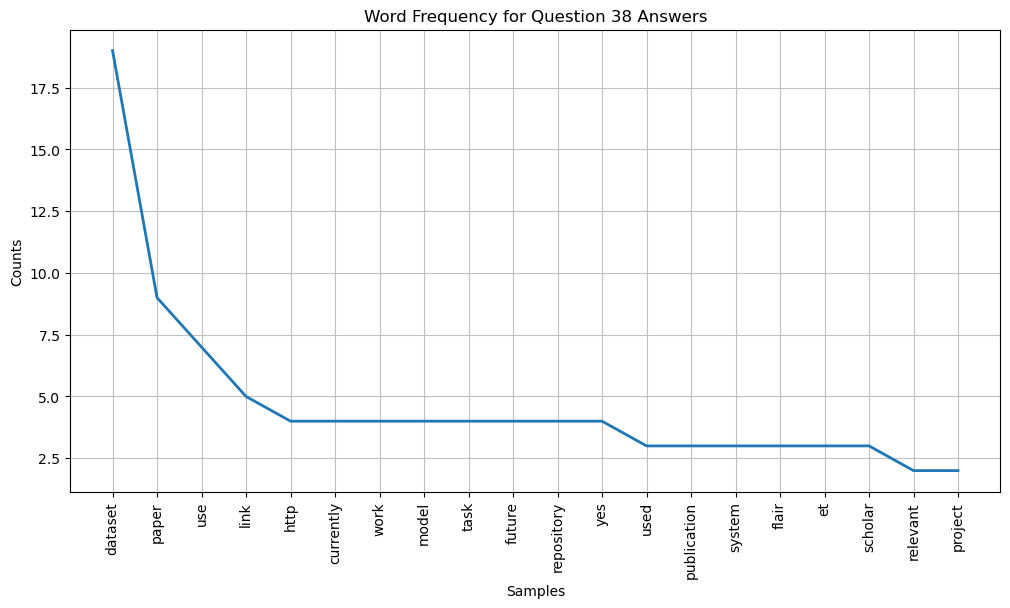

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('used', 29), ('dataset', 27), ('task', 21), ('data', 16), ('model', 14), ('social', 14), ('could', 13), ('learning', 11), ('also', 9), ('image', 9), ('example', 8), ('datasets', 8), ('action', 8), ('human', 7), ('annotation', 7), ('use', 7), ('detection', 7), ('training', 7), ('many', 7), ('conflab', 7)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

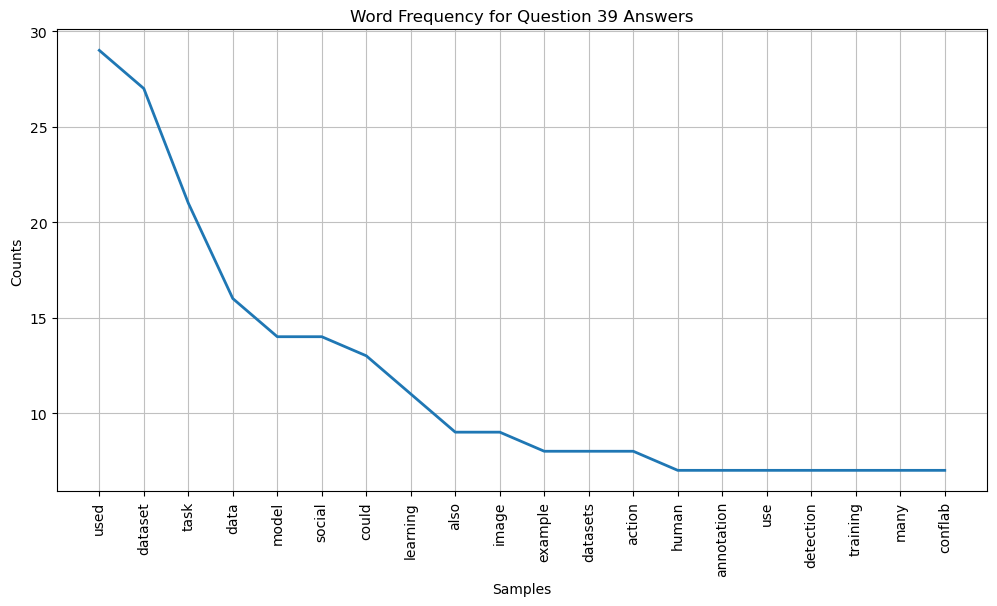

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 18), ('data', 14), ('model', 7), ('individual', 5), ('people', 5), ('application', 5), ('paper', 4), ('use', 4), ('contain', 4), ('ommon', 4), ('p', 4), ('ool', 4), ('bias', 4), ('researcher', 4), ('region', 4), ('may', 4), ('claim', 4), ('could', 4), ('certain', 4), ('population', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

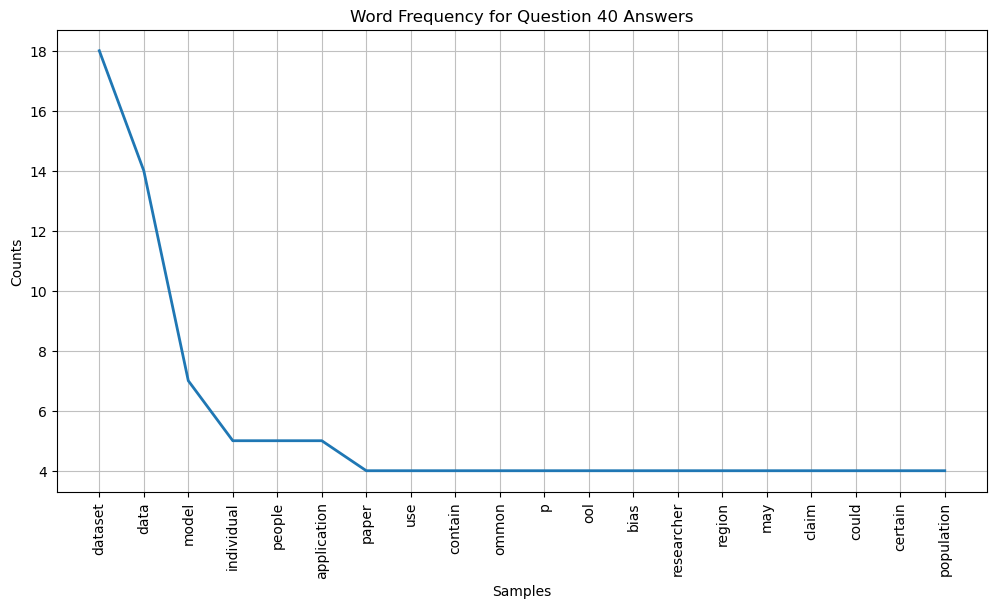

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 15), ('used', 8), ('data', 8), ('task', 6), ('use', 5), ('individual', 5), ('ommon', 4), ('p', 4), ('ool', 4), ('make', 4), ('purpose', 4), ('recognition', 4), ('people', 3), ('research', 3), ('user', 3), ('attribute', 3), ('would', 3), ('without', 3), ('license', 3), ('cancer', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

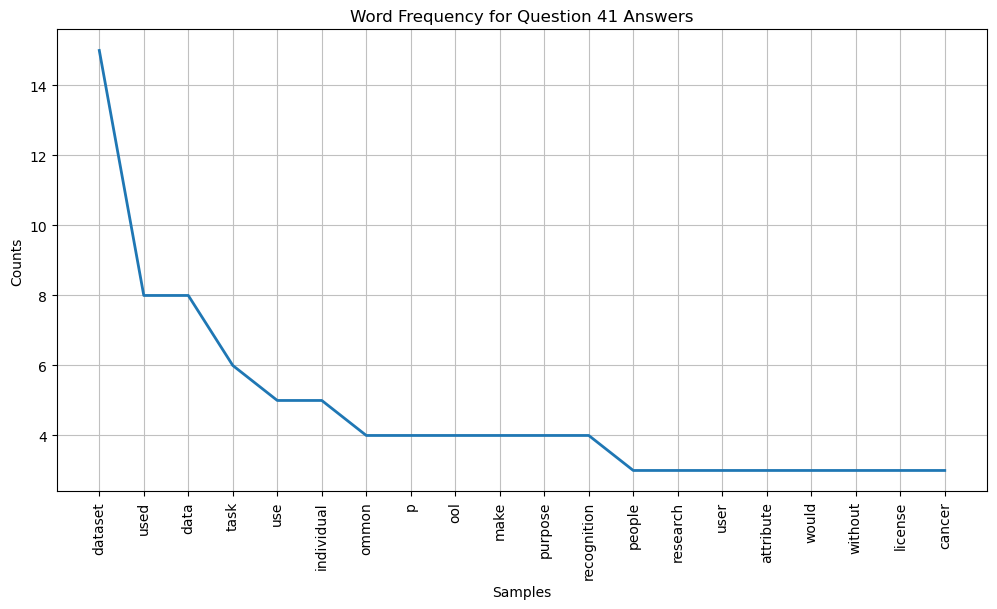

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('goal', 1), ('ommon', 1), ('p', 1), ('ool', 1), ('ata', 1), ('omp', 1), ('put', 1), ('benchmark', 1), ('place', 1), ('community', 1), ('start', 1), ('measuring', 1), ('dataset', 1), ('progress', 1), ('along', 1), ('many', 1), ('different', 1), ('ax', 1), ('model', 1), ('performance', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

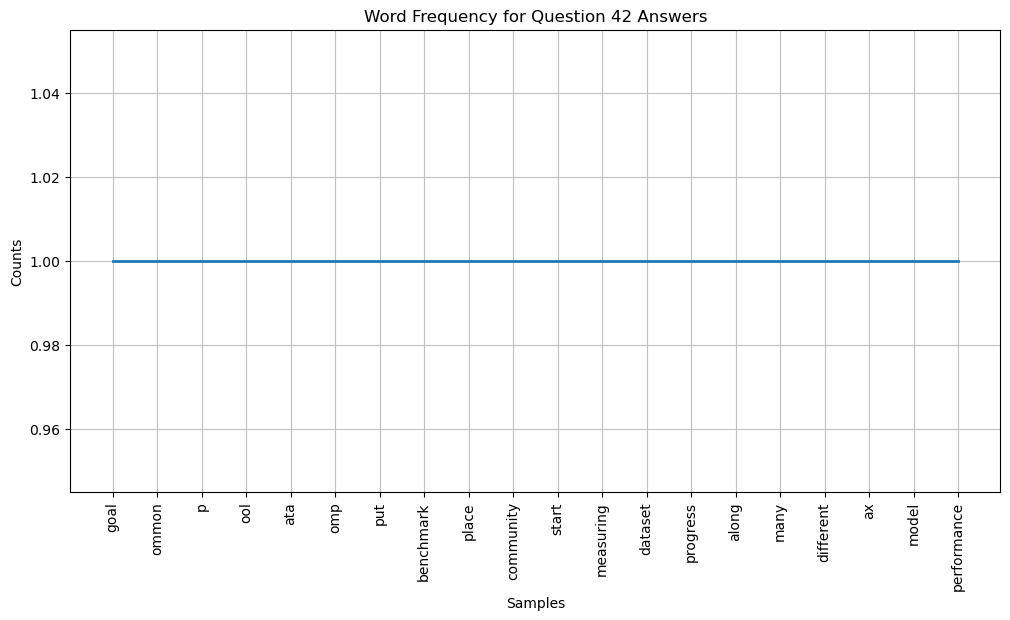

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 26), ('yes', 17), ('available', 17), ('publicly', 11), ('data', 9), ('use', 9), ('public', 5), ('research', 4), ('repository', 3), ('agreement', 3), ('datasets', 3), ('technology', 3), ('full', 3), ('academic', 3), ('see', 3), ('minighosts', 3), ('prompt', 3), ('http', 2), ('already', 2), ('description', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

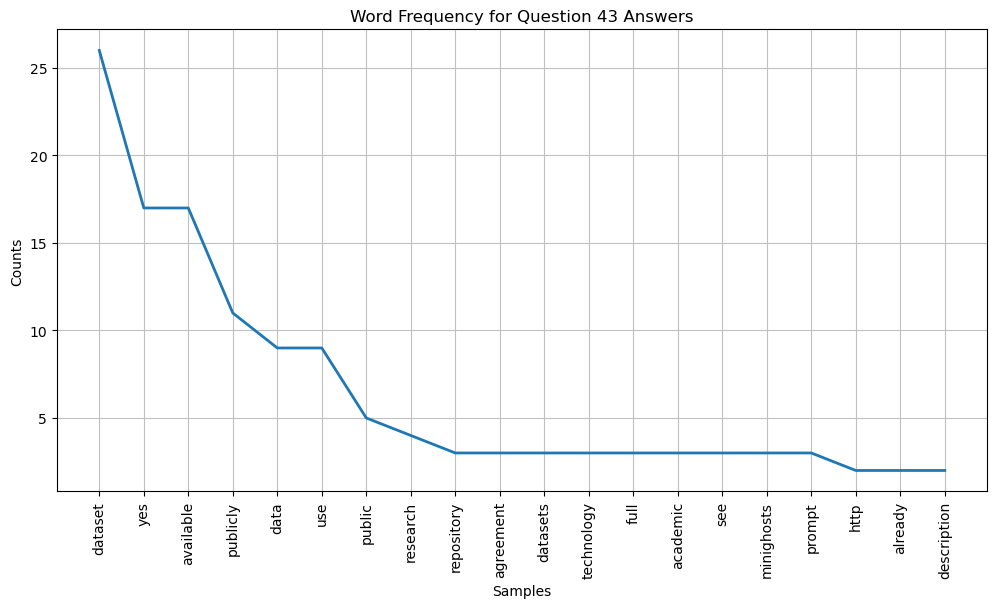

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 37), ('http', 19), ('available', 18), ('github', 13), ('doi', 12), ('data', 11), ('file', 8), ('distributed', 7), ('via', 6), ('released', 6), ('website', 6), ('download', 4), ('repository', 3), ('datasets', 3), ('bucket', 3), ('link', 3), ('huggingface', 3), ('release', 3), ('made', 3), ('page', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

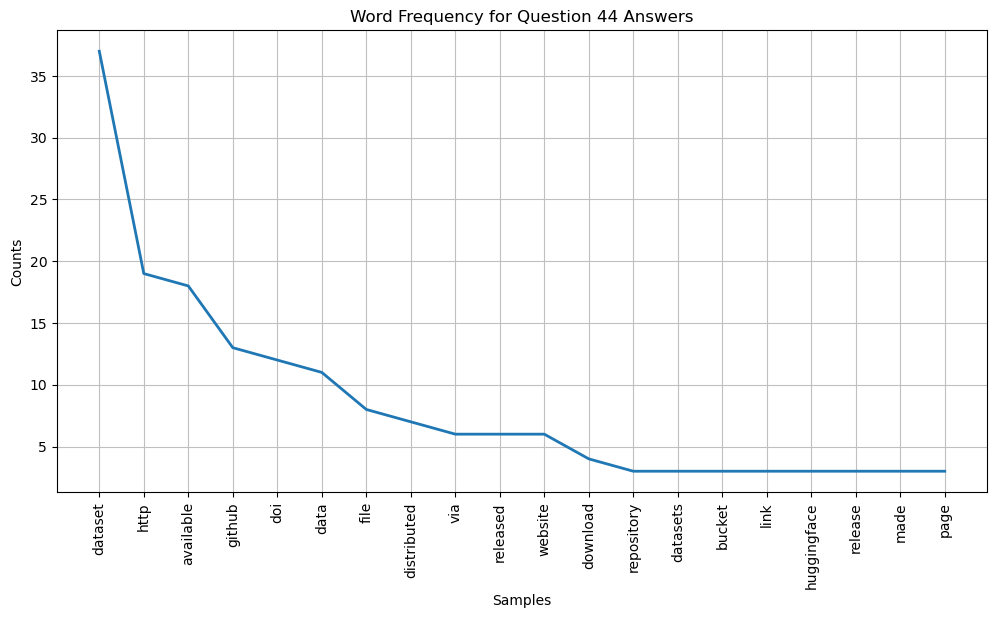

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('dataset', 23), ('available', 14), ('released', 7), ('june', 7), ('distributed', 5), ('data', 5), ('already', 4), ('neurips', 4), ('publicly', 4), ('currently', 4), ('version', 3), ('accessible', 3), ('conference', 3), ('license', 3), ('paper', 3), ('repository', 2), ('code', 2), ('process', 2), ('start', 2), ('october', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


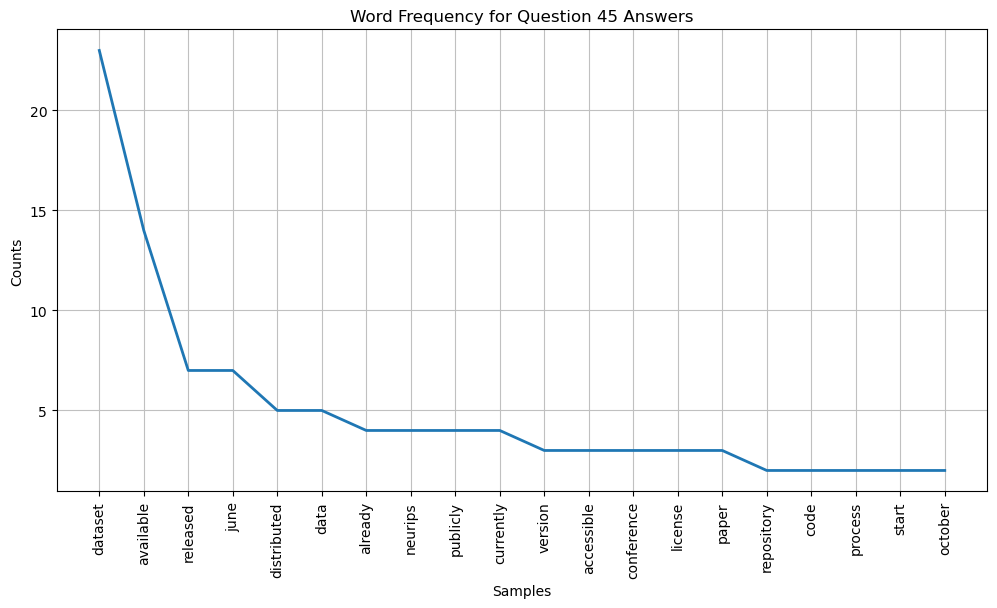

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('license', 37), ('dataset', 28), ('data', 12), ('released', 10), ('user', 9), ('cc', 8), ('creative', 7), ('common', 7), ('http', 7), ('use', 7), ('international', 5), ('distributed', 5), ('commercial', 5), ('purpose', 5), ('yes', 5), ('term', 5), ('research', 5), ('code', 4), ('mit', 4), ('author', 4)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


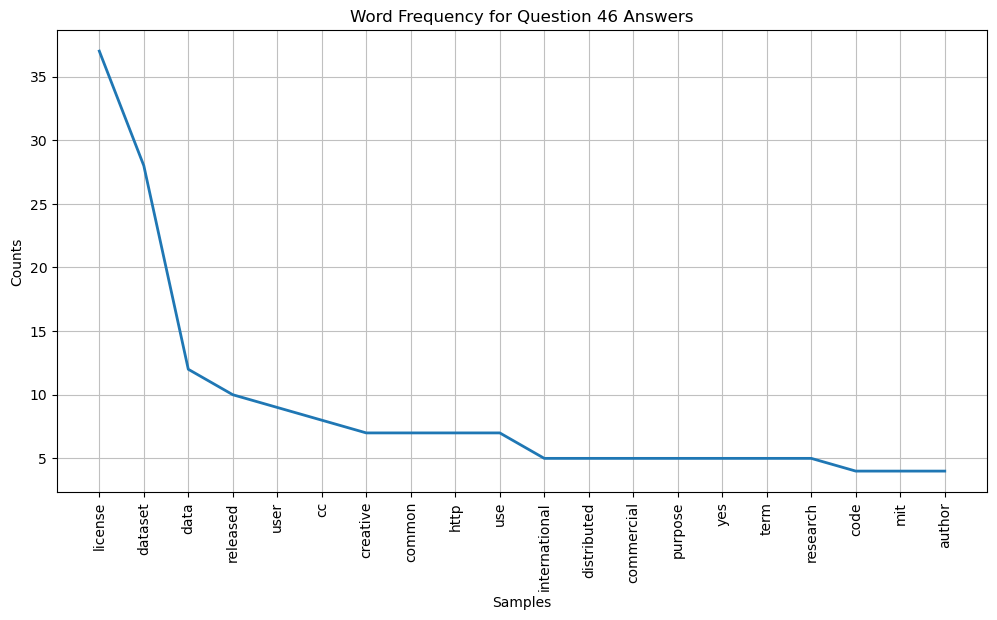

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('problem', 4), ('restriction', 4), ('data', 3), ('dataset', 3), ('use', 3), ('license', 3), ('link', 2), ('back', 2), ('imposed', 2), ('released', 2), ('term', 2), ('third', 2), ('party', 2), ('see', 2), ('youtube', 2), ('user', 2), ('source', 1), ('inspired', 1), ('codeforces', 1), ('original', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


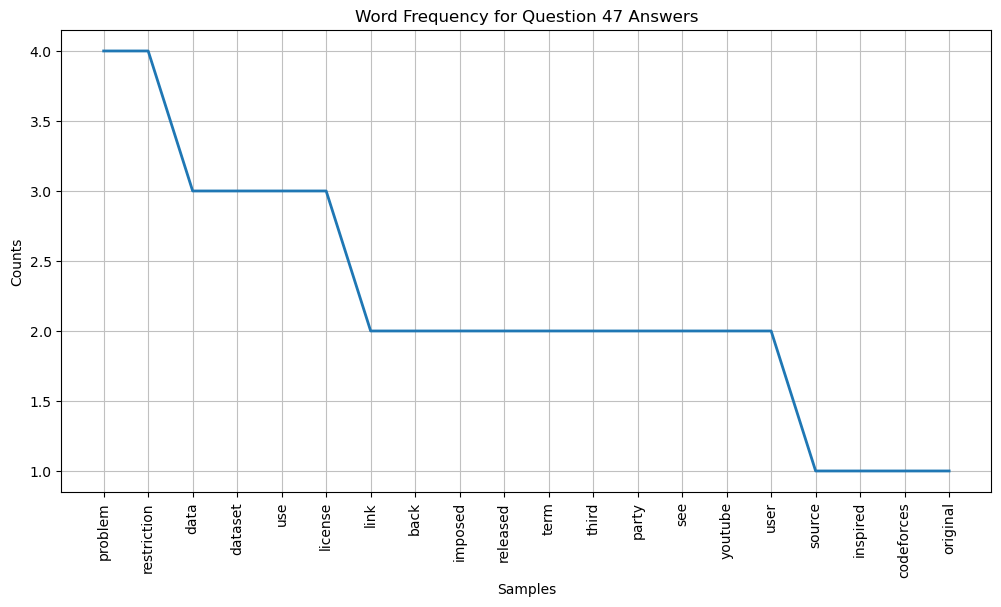

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('dataset', 5), ('restriction', 4), ('export', 3), ('control', 3), ('regulatory', 3), ('apply', 3), ('knowledge', 2), ('individual', 2), ('instance', 2), ('unknown', 1), ('applicable', 1), ('provided', 1), ('index', 1), ('pair', 1), ('aware', 1), ('term', 1), ('eula', 1), ('european', 1), ('general', 1), ('data', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


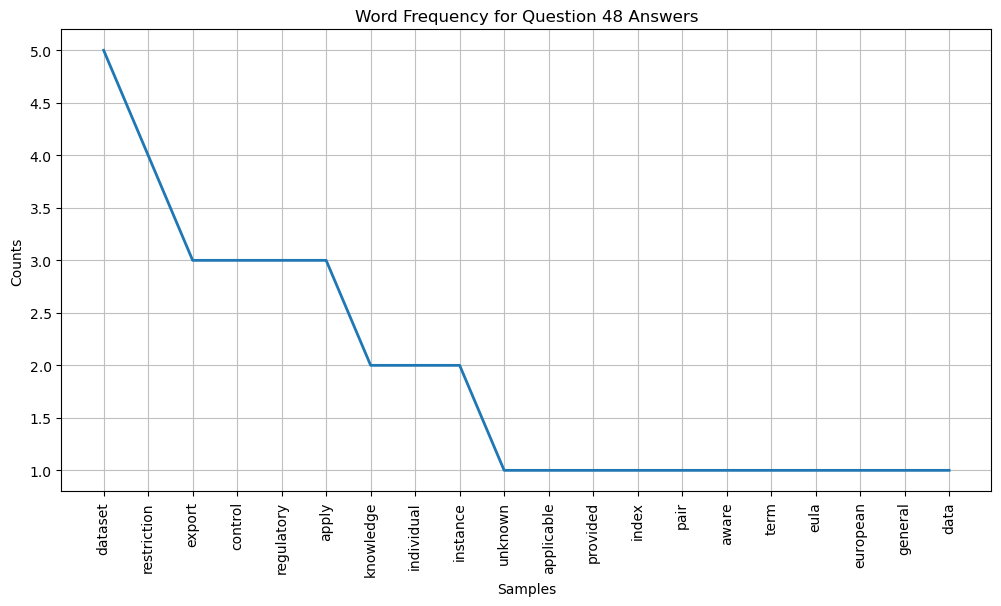

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('subset', 2), ('sample', 2), ('provide', 1), ('several', 1), ('ommon', 1), ('p', 1), ('ool', 1), ('full', 1), ('dataset', 1), ('hence', 1), ('possible', 1), ('download', 1), ('experiment', 1), ('data', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


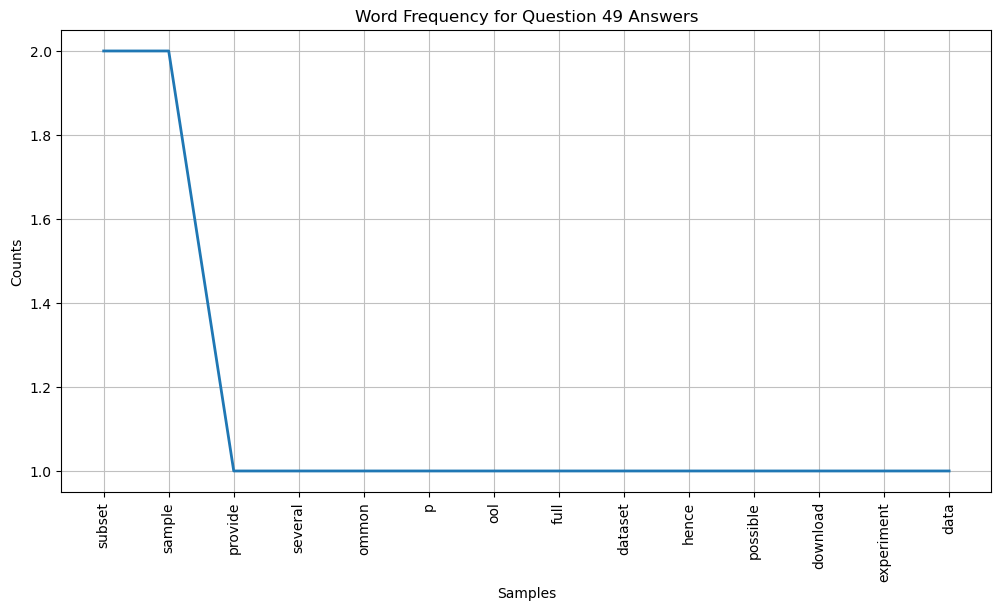

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('dataset', 28), ('hosted', 15), ('maintained', 8), ('repository', 7), ('github', 6), ('author', 6), ('research', 6), ('supported', 4), ('lab', 4), ('department', 4), ('maintaining', 4), ('paper', 4), ('hosting', 4), ('zenodo', 4), ('huggingface', 3), ('currently', 3), ('host', 3), ('team', 3), ('group', 3), ('support', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

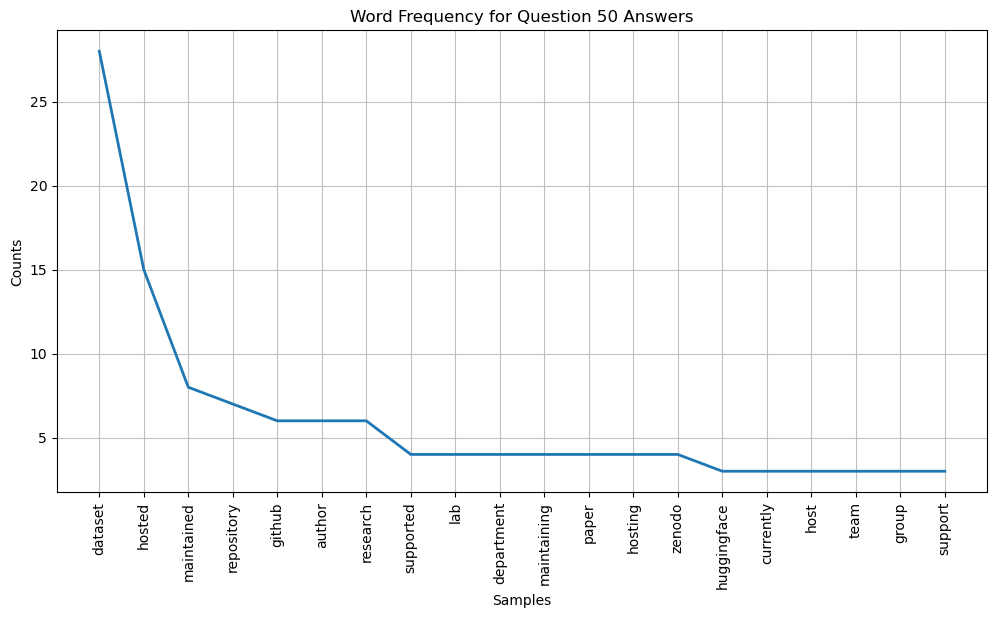

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('email', 14), ('contact', 12), ('github', 8), ('author', 7), ('contacted', 6), ('dataset', 6), ('question', 4), ('via', 4), ('issue', 4), ('please', 4), ('found', 3), ('repository', 3), ('information', 3), ('address', 3), ('page', 3), ('comment', 2), ('sent', 2), ('moosavi', 2), ('related', 2), ('wang', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


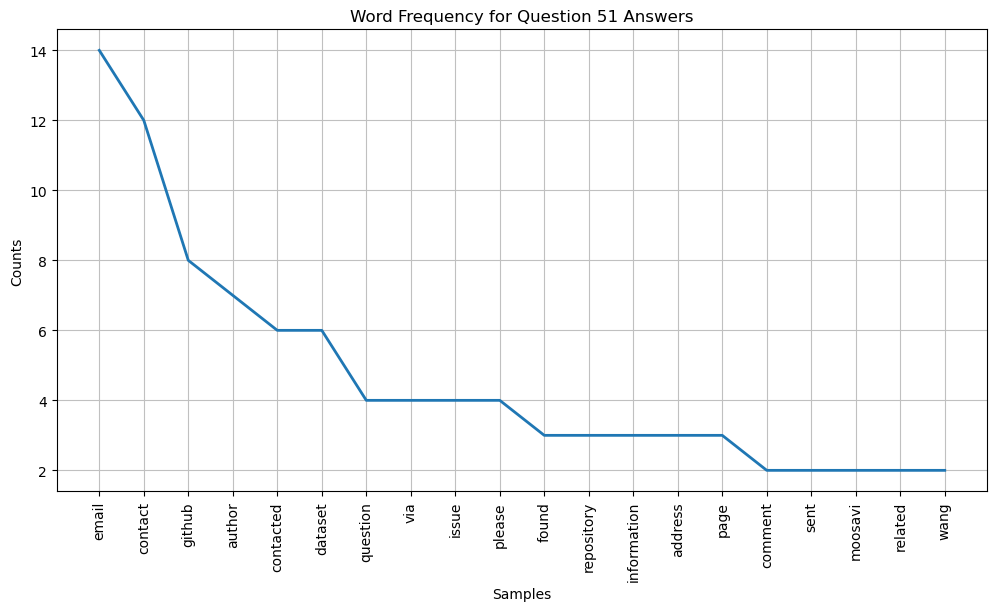

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 12), ('erratum', 10), ('release', 6), ('website', 6), ('change', 5), ('error', 4), ('github', 4), ('http', 3), ('version', 3), ('repository', 3), ('future', 3), ('official', 3), ('issue', 2), ('request', 2), ('announced', 2), ('user', 2), ('currently', 2), ('updated', 2), ('included', 2), ('documented', 2)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

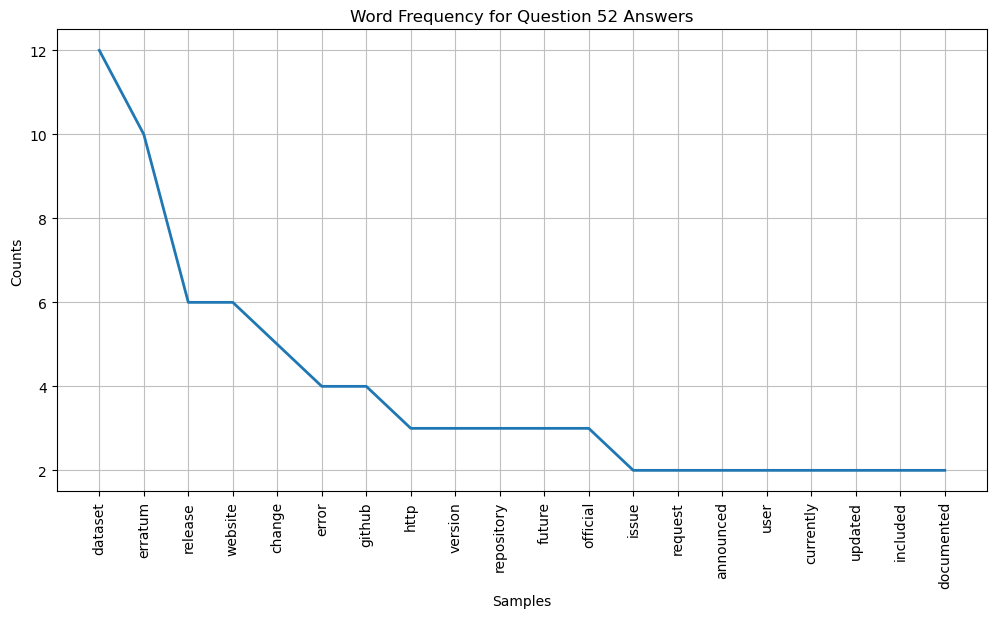

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[('dataset', 25), ('update', 24), ('updated', 11), ('github', 9), ('new', 9), ('plan', 8), ('error', 7), ('version', 7), ('yes', 6), ('data', 6), ('request', 6), ('website', 5), ('may', 5), ('added', 5), ('datasets', 4), ('email', 4), ('via', 3), ('future', 3), ('change', 3), ('page', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

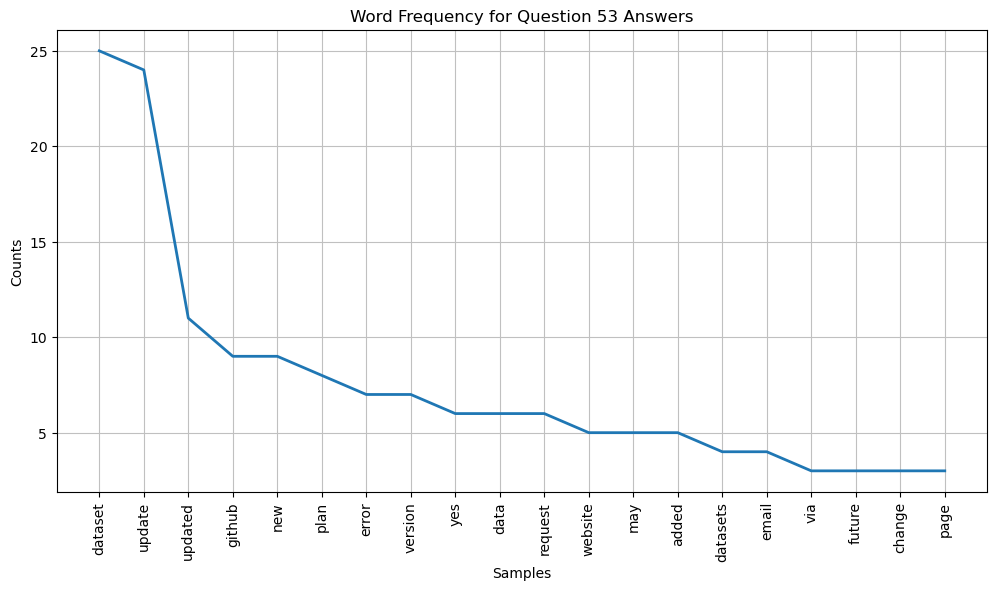

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('data', 9), ('dataset', 5), ('human', 3), ('people', 3), ('applicable', 3), ('user', 3), ('request', 3), ('sample', 3), ('individual', 2), ('public', 2), ('domain', 2), ('available', 2), ('yes', 2), ('specific', 2), ('communicated', 2), ('case', 2), ('personal', 1), ('contain', 1), ('information', 1), ('generated', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

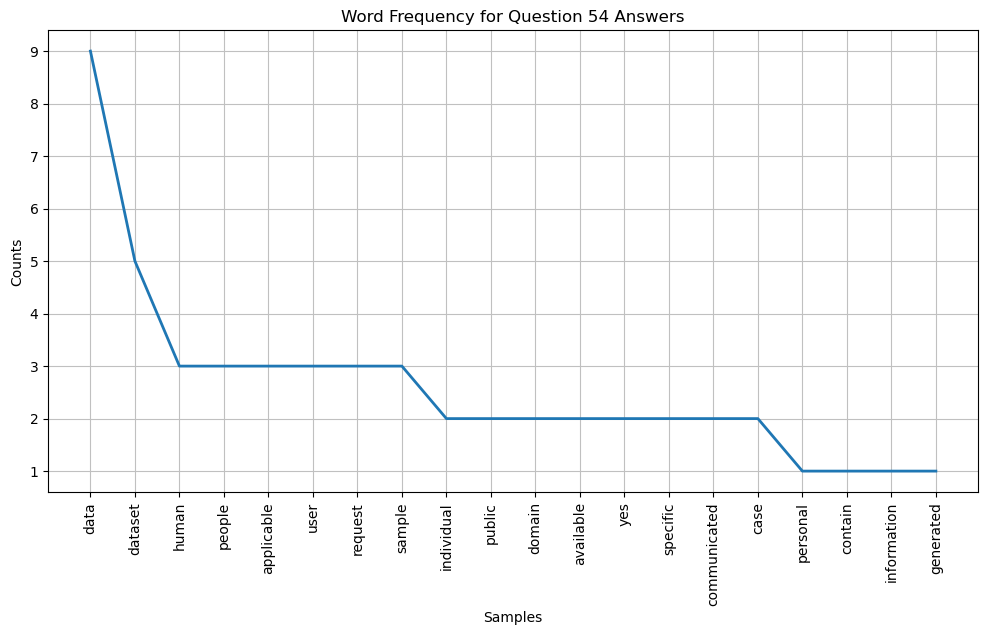

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('version', 27), ('dataset', 14), ('yes', 8), ('older', 6), ('github', 6), ('update', 5), ('website', 5), ('change', 5), ('maintained', 4), ('plan', 4), ('maintain', 4), ('data', 4), ('available', 4), ('asset', 4), ('continue', 3), ('supported', 3), ('repository', 3), ('keep', 3), ('log', 3), ('datasets', 3)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

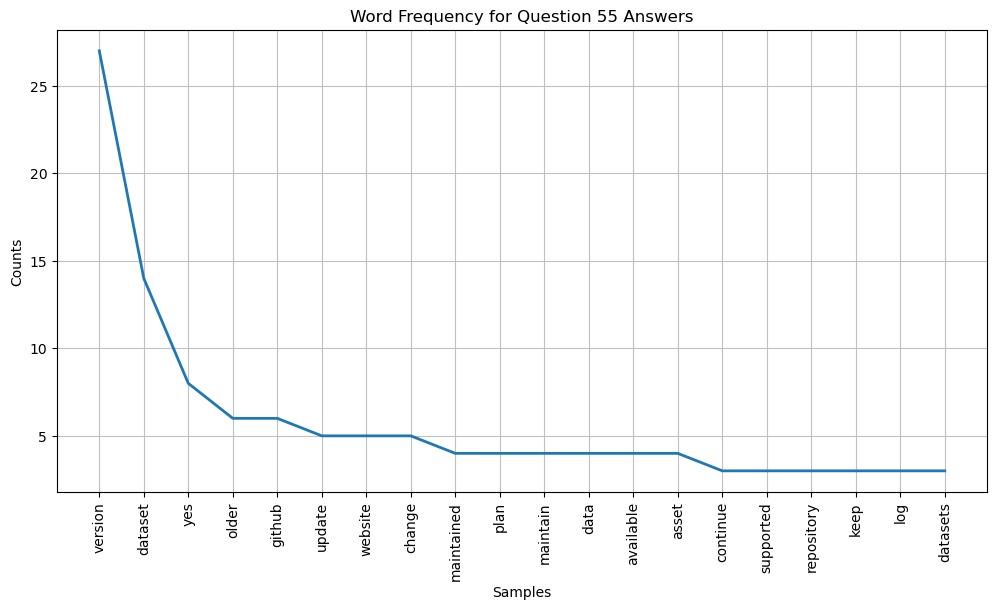

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('dataset', 18), ('contribution', 14), ('github', 10), ('data', 10), ('contact', 9), ('u', 9), ('yes', 8), ('author', 7), ('available', 7), ('welcome', 6), ('others', 6), ('plan', 6), ('repository', 6), ('license', 6), ('paper', 5), ('would', 5), ('extend', 5), ('publicly', 5), ('http', 5), ('use', 5)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

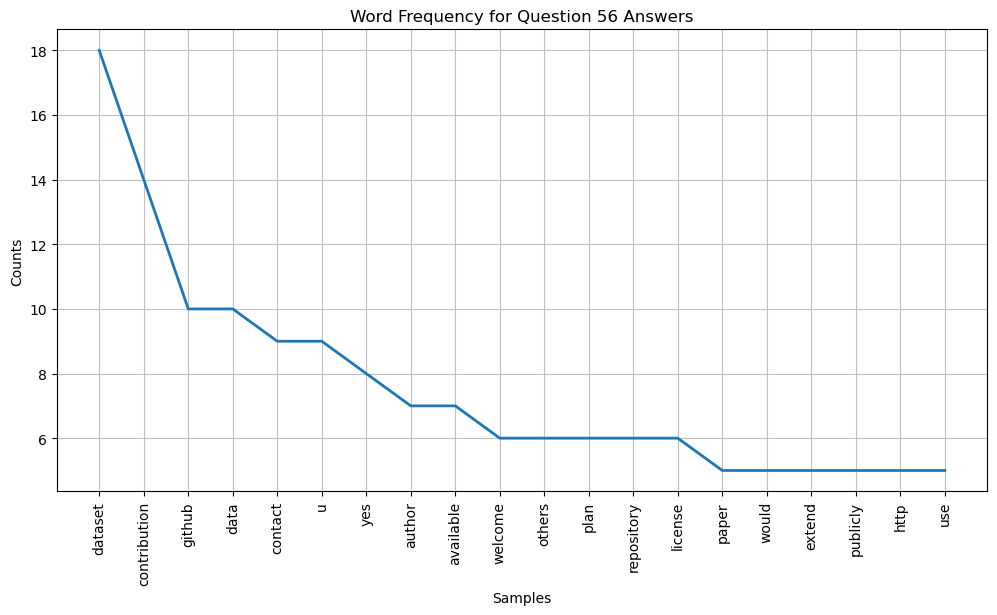

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

[('contact', 2), ('encourage', 1), ('community', 1), ('member', 1), ('u', 1), ('inquiry', 1), ('related', 1), ('dataset', 1), ('maintainence', 1)]


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


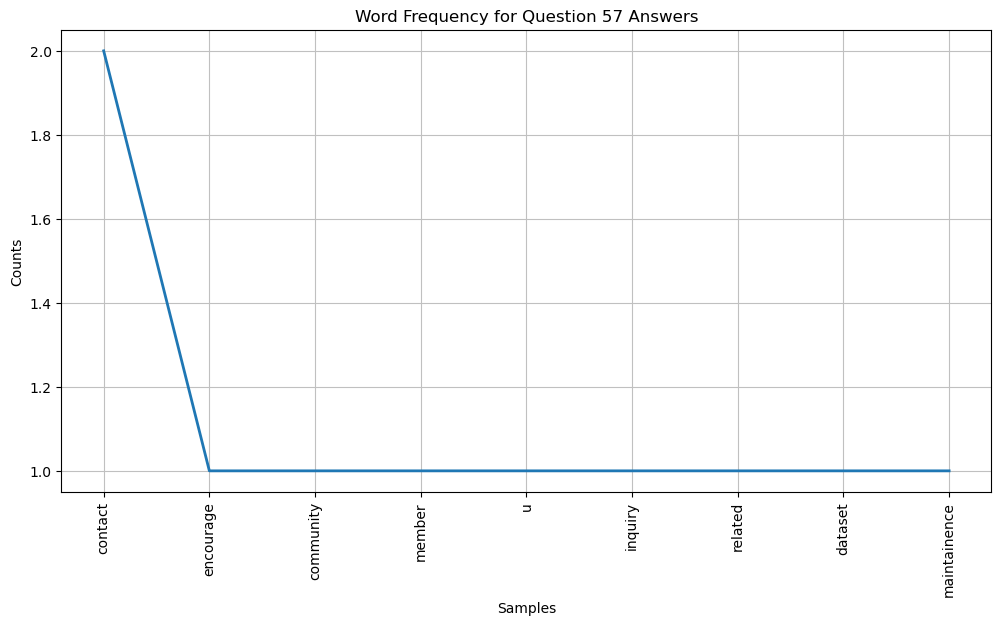

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

In [23]:
##analyze word frequency for each question

##define function to plot frequency distribution of top 10 words
def plotWordFrequency(tokens, title, num_words=20):
    frequencyDistribution = FreqDist(tokens)
    print(frequencyDistribution.most_common(20))
    plt.figure(figsize=(12,6))
    frequencyDistribution.plot(num_words, cumulative=False)
    plt.title(title)
    plt.show()

##generate frequency plot for each question
for _, row in groupedQuestionTokens.iterrows():
    question = row['questionum']
    tokens = row['processedTokens']
    plotWordFrequency(tokens, f'Word Frequency for Question {question} Answers')
    

### *Collocations*

In [24]:
##get collocations for each question

##define function to get bigrams
def get_bigrams(tokens, top_n=10):
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    bigrams = finder.nbest(BigramAssocMeasures.pmi, top_n)
    return [(b, finder.ngram_fd[b]) for b in bigrams]

##define function to get trigrams
def get_trigrams(tokens, top_n=10):
    finder = TrigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    trigrams = finder.nbest(TrigramAssocMeasures.pmi, top_n)
    return [(t, finder.ngram_fd[t]) for t in trigrams]


for _, row in groupedQuestionTokens.iterrows():
    question = row['questionum']
    tokens = row['processedTokens']
    
    print(f"\n Question {question}:")
    
    bigrams = get_bigrams(tokens, top_n=10)
    print("Top bigrams:")
    for collocation, freq in bigrams:
        print(f"{collocation}: {freq}")
    
    trigrams = get_trigrams(tokens, top_n=10)
    print("Top trigrams:")
    for collocation, freq in trigrams:
        print(f"{collocation}: {freq}")

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag


 Question 1:
Top bigrams:
('ata', 'omp'): 2
('brain', 'activity'): 2
('daily', 'life'): 2
('despite', 'impressive'): 2
('five', 'vital'): 2
('layer', 'super'): 2
('lower', 'layer'): 2
('medical', 'prescription'): 2
('super', 'output'): 2
('foia', 'request'): 3
Top trigrams:
('layer', 'super', 'output'): 2
('lower', 'layer', 'super'): 2
('requires', 'performing', 'arithmetic'): 2
('verbal', 'utterance', 'nonverbal'): 3
('super', 'output', 'area'): 2
('event', 'satellite', 'imagery'): 2
('identifying', 'screening', 'participant'): 2
('novel', 'view', 'synthesis'): 2
('performing', 'arithmetic', 'reasoning'): 2
('change', 'event', 'satellite'): 2

 Question 2:
Top bigrams:
('machine', 'learning'): 2
('ntu', 'chen'): 2
('nyalleng', 'moorosi'): 2
('scientific', 'industrial'): 2
('timnit', 'gebru'): 2
('council', 'scientific'): 2
('hong', 'kong'): 3
('south', 'african'): 2
('south', 'africa'): 3
('allen', 'institute'): 2
Top trigrams:
('council', 'scientific', 'industrial'): 2
('industrial'

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

### *Lexical Diversity*

In [25]:
##calculate lexical diversity of answers for each question

##define function to calculate lexical diversity
def lexicalDiversity(tokens):
    totalWords = len(tokens)
    uniqueWords = len(set(tokens))
    return uniqueWords / totalWords if totalWords > 0 else 0

##apply to each paper
groupedQuestionTokens['lexicalDiversity'] = groupedQuestionTokens['processedTokens'].apply(lexicalDiversity)

print(groupedQuestionTokens[['questionum', 'lexicalDiversity']])


    questionum  lexicalDiversity
0            1          0.473491
1            2          0.572687
2            3          0.567227
3            4          0.781457
4            5          0.540218
5            6          0.492323
6            7          0.559624
7            8          0.483243
8            9          0.591422
9           10          0.627717
10          11          0.606918
11          12          0.459016
12          13          0.589796
13          14          0.563786
14          15          0.581699
15          16          0.634686
16          17          0.576017
17          18          0.586957
18          19          0.605714
19          20          0.941176
20          21          0.617949
21          22          0.568579
22          23          0.709360
23          24          0.564743
24          25          0.567130
25          26          0.619565
26          27          0.564854
27          28          0.643077
28          29          0.643836
29        

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

### *TF-IDF and Cosine Similarity*

In [26]:
##calculate TF-IDF (term frequency-inverse document frequency) to view word importance for each question (ACROSS ALL PAPERS), then use cosine similarity to measure how alike the questions are

##make it into a single string
groupedQuestionTokens['text'] = groupedQuestionTokens['processedTokens'].apply(lambda x: ' '.join(x))
##generate tf-idf vectors
vectorizer = TfidfVectorizer()
tfidfMatrix = vectorizer.fit_transform(groupedQuestionTokens['text'])
##calculate cosine similarity and display as a dataframe
cosineSimilarityQuestions = cosine_similarity(tfidfMatrix)
cosineSimilarityQuestionsDataframe = pd.DataFrame(cosineSimilarityQuestions, index=groupedQuestionTokens['questionum'], columns=groupedQuestionTokens['questionum'])
##style dataframe printout for easier interpretation
def bold_if_above_threshold(value, threshold):
    if value > threshold:
        return 'font-weight: bold'
    else:
        return ''   
styledCosineSimilarityQuestionsDataframe = cosineSimilarityQuestionsDataframe.style.applymap(lambda x: bold_if_above_threshold(x, 0.3))
print("Cosine Similarity Across Questions with values > 0.3 bolded:" )
styledCosineSimilarityQuestionsDataframe


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

Cosine Similarity Across Questions with values > 0.3 bolded:


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

### *Topic Modeling*

In [27]:
##create dictionary for LDA ACROSS EACH QUESTION THIS TIME
texts = groupedQuestionTokens['processedTokens'].tolist() ##makes each question's total answer text content into a list of words
dictionary = corpora.Dictionary(texts) ##maps unique IDs to each unique word in the dataset
corpus = [dictionary.doc2bow(text) for text in texts] ##bag of words format; every document (in this case, questions) is represented as a list of each word ID and count of its occurences in that document


##train LDA model
numTopics = 7  ##choose a number of topics to elicit
lda = models.LdaModel(corpus, num_topics=numTopics, id2word=dictionary, random_state=42)

##evaluate LDA model
##first calculate perplexity (lower perplexity = how well our number of topics captures the actual distribution of words in the document = better)
perplexity_score = lda.log_perplexity(corpus)
print(f'Perplexity: {perplexity_score}')
##calculate coherence (higher coherence = higher word similarity across the topic = better)
coherence_model_lda = CoherenceModel(
    model=lda,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence: {coherence_score}')

##view topics (global topics across all questions)
print("\nLDA Topics:")
for idx, topic in lda.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Perplexity: -8.033354364060568


/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/multiproces

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

Coherence: 0.27390903498652863

LDA Topics:
Topic 1: 0.035*"dataset" + 0.025*"data" + 0.008*"people" + 0.007*"image" + 0.007*"yes" + 0.006*"available" + 0.005*"individual" + 0.005*"collection" + 0.004*"annotation" + 0.004*"also"
Topic 2: 0.033*"dataset" + 0.024*"data" + 0.010*"image" + 0.007*"available" + 0.006*"information" + 0.005*"research" + 0.005*"yes" + 0.004*"model" + 0.004*"annotation" + 0.004*"http"
Topic 3: 0.025*"dataset" + 0.012*"data" + 0.006*"image" + 0.005*"yes" + 0.005*"people" + 0.004*"github" + 0.004*"used" + 0.004*"annotation" + 0.004*"update" + 0.004*"information"
Topic 4: 0.030*"dataset" + 0.021*"data" + 0.011*"image" + 0.008*"used" + 0.006*"http" + 0.006*"task" + 0.006*"available" + 0.006*"model" + 0.005*"instance" + 0.005*"use"
Topic 5: 0.021*"dataset" + 0.011*"data" + 0.006*"model" + 0.006*"task" + 0.005*"research" + 0.005*"yes" + 0.005*"used" + 0.005*"image" + 0.004*"datasets" + 0.004*"available"
Topic 6: 0.017*"data" + 0.014*"image" + 0.009*"dataset" + 0.007*"

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packag

In [28]:
import warnings
warnings.filterwarnings('ignore')

##fancy interactive topic modeling viz
####THROWS A LOT OF WARNINGS BECAUSE THE PACKAGE SOURCE CODE USES AN OLD DATETIME VERSION

import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/conda/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


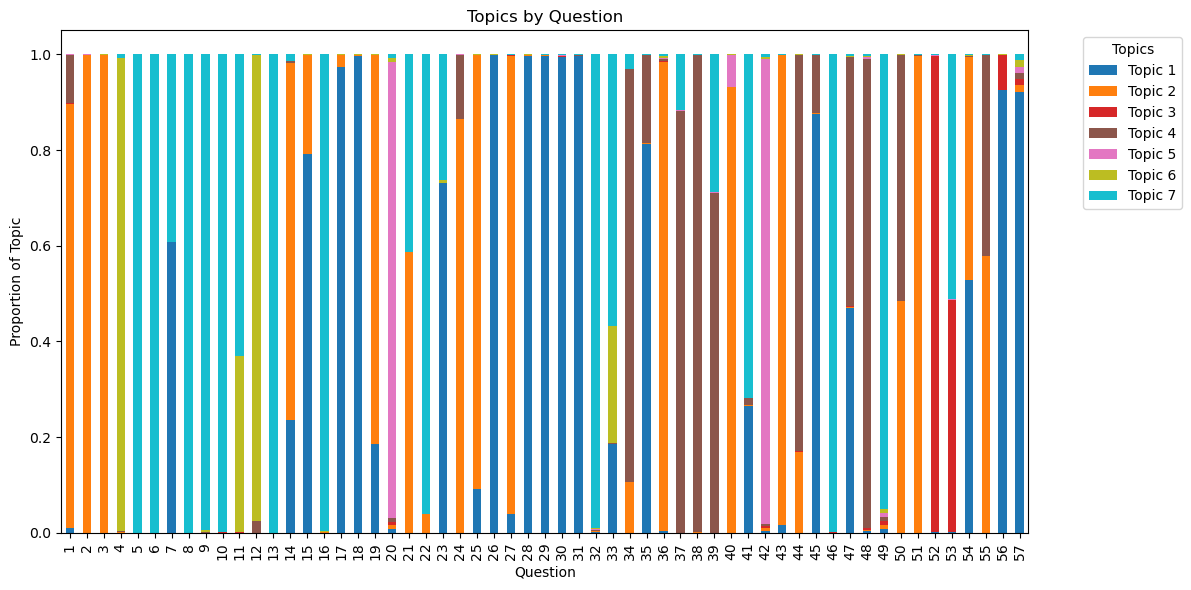

In [29]:
##plot proportion of topics across each questions

questionTopics = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]

##make dataframe of the probability of each topic occuring in each document
questionTopicDistributions = pd.DataFrame(
    [[topic_prob for topic_id, topic_prob in doc] for doc in questionTopics],
    columns=[f'Topic {i+1}' for i in range(numTopics)]
)

##identifying each document by questionnum
questionTopicDistributions['questionum'] = groupedQuestionTokens['questionum'].values
##set questionnum as index
questionTopicDistributions.set_index('questionum', inplace=True)

##make stacked barplot
questionTopicDistributions.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')
plt.ylabel("Proportion of Topic")
plt.xlabel("Question")
plt.title("Topics by Question")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()